
# Welcome to our Notebook 
### Volatile Bandits: Noisy, imperfect but efficient: SMC agents for modelling human behaviour

<img src='images_and_figures/bandit_illustration.png' width='800'>

This notebook reproduces the biologically plausible **forward varying-volatility** agent and the **Weber-imprecision** agent from Findling et al. (2021) paper titled *'Imprecise neural computations as a source of adaptive behaviour in volatile environments'*. It comprises three sections: 
1. a playground to first build some intuitions -> *interactive* 
2. the codebase for building and running the two-armed bandit experiment from the paper -> *not interactive, skip if there is no time* 
3. and comparing this to human data you made from the seminar demo! -> *interactive*

*By: Sabine, Sigur, Sofia and Elena*

```
Folder Structure 

neural-imprecision-for-volatility/     
└── findling_notebook/                 ←📍OUR REPO
    ├── notebook.ipynb               
    ├── images_and_figures/            
    └── participant_data/              
        └── backup_combined_data.csv
├── fit_functions/                     ← Original C++ code - you can ignore these files
├── lib_c/                             
├── simulation_functions/              
└── utils/                             

```
________________________________________________________________________________


# Colab Setup - Run this first!

In [11]:
import sys
import os

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("📍 Running in Google Colab!")
    print("=" * 50)
    
    # GitHub repository info:
    GITHUB_USER = "sascholle"
    GITHUB_REPO = "neural-imprecision-for-volatility"
    NOTEBOOK_FOLDER = "findling_notebook"  # ← Folder containing the notebook
    
    # Step 1: Install/enable widgets
    try:
        import subprocess
        subprocess.run([sys.executable, "-m", "pip", "install", "-q", "ipywidgets"], 
                      capture_output=True)  # Don't fail if already installed
    except:
        pass  # ipywidgets likely already available
    
    from google.colab import output
    output.enable_custom_widget_manager()
    print("✅ Widgets ready")
    
    # Step 2: Clone the repository (always fresh to get latest version)
    repo_path = f"/content/{GITHUB_REPO}"
    if os.path.exists(repo_path):
        print("🔄 Removing old version...")
        import shutil
        shutil.rmtree(repo_path)
    
    # Change to /content/ first, then clone
    os.chdir("/content")
    print("📥 Cloning latest version from GitHub...")
    clone_result = os.system(f"git clone https://github.com/{GITHUB_USER}/{GITHUB_REPO}.git")
    
    if clone_result != 0 or not os.path.exists(repo_path):
        print("❌ Clone failed! Check the repository URL.")
        raise Exception("Git clone failed")
    
    print("✅ Repository cloned")
    
    # Step 3: Navigate to notebook folder
    notebook_path = f"{repo_path}/{NOTEBOOK_FOLDER}"
    os.chdir(notebook_path)
    print(f"✅ Working directory: {notebook_path}")
    
    # Step 4: Verify files exist
    print("\n📁 Checking files...")
    checks = [
        ("images_and_figures/bandit_illustration.png", "Banner image"),
        ("images_and_figures/model_schemas.jpg", "Model diagram"),
        ("images_and_figures/varyingvolfull.png", "Var-Vol diagram"),
        ("participant_data", "Participant data folder"),
    ]
    all_good = True
    for path, name in checks:
        if os.path.exists(path):
            print(f"   ✅ {name}")
        else:
            print(f"   ❌ {name} - NOT FOUND")
            all_good = False
    
    if all_good:
        print("\n🎉 All set! You can run the rest of the notebook.")
    else:
        print("\n⚠️ Some files missing. Check your GitHub repo structure.")

else:
    print("📍 Running locally - no Colab setup needed!")
    print(f"   Working directory: {os.getcwd()}")


📍 Running locally - no Colab setup needed!
   Working directory: c:\Users\beani\Documents\MSc\Semester1\DecisionMaking\learning_variability_and_volatility\findling_notebook


### Quickstart
1. Use the search function for the words **'To Do'** to jump to the 5 sections where you can interact with the codebase, you can often just skip the rest if you're pressed for time. Make sure Section 1 and 2 are uncollapsed to find them with search.
2. If you are on a local machine, run `pip install numpy scipy matplotlib pandas ipywidgets` once in your environment.


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings("ignore", message="Glyph.*missing from font")
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 4)


# Section 1: Build-a-Model Playground 

First let's see what we need to build a model of human behaviour. We look at two of the models from the paper, the **varying volatiltiy model**, and the novel **Weber-imprecision model**. Here is an overview of all of them from the paper:

<img src="images_and_figures/model_schemas.jpg" width="900" style="display:inline">

### Model Variables at a Glance
In the 2-armed bandit demo you did earlier:
- **Two circles** (🟠 Orange and 🔵 Blue) = the two **actions** to choose from

| Symbol | Name | Model | In your demo | What it controls |
|--------|------|-------|--------------|------------------|
| **z_t** | Latent state | Both | 🟠=0 or 🔵=1 | Which circle is currently "correct" |
| **a_t** | Action | Both | Circle clicked | Which circle the participant chose |
| **r_t** | Reward | Both | 😊 or 😠 | Feedback shown after choice |
| **η** (eta) | Feedback noise | Both | (hidden) | How reliable is the 😊/😠 feedback? |
| **s_t** | Stimulus | Both | 0 | Always 0 in 2-armed bandit (no varying stimulus) |
| **ν** (nu) | Volatility variance | Var-Vol only | (hidden) | How *quickly* τ changes over time |
| **τ_t** (tau) | Switch probability | Var-Vol only | (hidden) | Chance the correct circle flips this trial |
| **λ** (lambda) | Weber scaling | Weber only | (hidden) | Noise scales with belief change: `noise = λ × Δbelief` |
| **μ** (mu) | Baseline noise | Weber only | (hidden) | Minimum noise added every trial |
| **ε_t** | Inference noise | Weber only | (hidden) | Total noise: `ε_t = λ × Δbelief + μ` |

**Key insight**: The Weber model replaces explicit volatility tracking (ν, τ) with simple noise injection (λ, μ). When beliefs shift rapidly, noise increases — mimicking what volatility estimation would achieve, but computationally cheaper.



### 🧠 To Do: Quick Quiz

| Question | Var-Vol | Weber |
|----------|---------|-------|
| 1. Does it track volatility explicitly? | _____ | _____ |
| 2. How does it adapt after a switch? | _____ | _____ |
| 3. Computational cost? | _____ | _____ |
| 4. Which parameters does it use? | _____ | _____ |
| 5. More biologically plausible? | _____ | _____ |

<details>
<summary>💡 Click for answers</summary>

| Aspect | Varying-Volatility | Weber-Imprecision |
|--------|-------------------|-------------------|
| **1. Tracks volatility?** | ✅ Yes (maintains τ_t, ν) | ❌ No |
| **2. Adapts to switches?** | Via Bayesian inference on τ | Via noise injection (ε_t) |
| **3. Computational cost** | 🐢 Heavy (nested SMC²) | Light (single SMC) |
| **4. Parameters** | ν, τ_min, τ_max, η | λ, μ, η |
| **5. Biological plausibility** | Less (requires precise computation) | More (noise is "free") |

**Why is Weber more biologically plausible?** The brain doesn't need to compute exact Bayesian posteriors — it just needs to be "noisier" when things are uncertain. Weber achieves similar behavior through a simple heuristic!

</details>



### 🧠 To Do: Test out the sliders to see how the variables interact

In [13]:
def explore_environment(tau_min=0.0, tau_max=0.5, nu=1e-4, eta=0.9, 
                        lambda_weber=0.5, mu_weber=0.1, seed=42, num_trials=100):
    """
    Visualize the environment AND simplified model belief updates.
    Paper: τ ∈ [0, 0.5], ν constant, η ∈ [0.5, 1]
    This is a conceptual demo - not full SMC, but shows the key differences.
    """
    rng = np.random.default_rng(seed)
    
    # =========================================
    # GENERATE ENVIRONMENT
    # =========================================
    
    # Generate volatility τ_t (bounded random walk)
    tau = np.zeros(num_trials)
    tau[0] = tau_min
    for t in range(1, num_trials):
        tau[t] = np.clip(rng.normal(tau[t-1], np.sqrt(nu)), tau_min, tau_max)
    
    # Generate latent state z_t (switches with probability τ_t)
    z = np.zeros(num_trials, dtype=int)
    z[0] = rng.integers(2)
    switches = []
    for t in range(1, num_trials):
        if rng.random() < tau[t]:
            z[t] = 1 - z[t-1]
            switches.append(t)
        else:
            z[t] = z[t-1]
    
    # Generate traps (feedback noise)
    traps = rng.random(num_trials) > eta
    
    # =========================================
    # SIMULATE SIMPLIFIED BELIEF UPDATES
    # =========================================
    # Both models start with uniform belief P(z=1) = 0.5
    
    # Var-Vol model: uses estimated τ to weight new evidence
    belief_varvol = np.zeros(num_trials)
    belief_varvol[0] = 0.5
    tau_estimate = np.zeros(num_trials)  # Model's estimate of volatility
    tau_estimate[0] = (tau_min + tau_max) / 2
    
    # Weber model: injects noise proportional to belief change
    belief_weber = np.zeros(num_trials)
    belief_weber[0] = 0.5
    weber_noise = np.zeros(num_trials)  # Track injected noise
    
    # Learning rate for simplified updates
    base_lr = 0.3
    
    for t in range(1, num_trials):
        # Simulate what feedback they'd get if choosing based on belief
        action_varvol = 1 if belief_varvol[t-1] > 0.5 else 0
        action_weber = 1 if belief_weber[t-1] > 0.5 else 0
        
        # Get rewards (with traps)
        reward_varvol = int((action_varvol == z[t-1]) != traps[t-1])
        reward_weber = int((action_weber == z[t-1]) != traps[t-1])
        
        # === VAR-VOL UPDATE ===
        # Update τ estimate based on prediction error
        prediction_error = abs(reward_varvol - (1 if action_varvol == int(belief_varvol[t-1] > 0.5) else 0))
        tau_estimate[t] = np.clip(
            tau_estimate[t-1] + 0.1 * (prediction_error - tau_estimate[t-1]) + rng.normal(0, np.sqrt(nu)),
            tau_min, tau_max
        )
        # Learning rate scales with estimated volatility
        lr_varvol = base_lr * (1 + 2 * tau_estimate[t])
        # Update belief
        if reward_varvol == 1:
            target = 1.0 if action_varvol == 1 else 0.0
        else:
            target = 0.0 if action_varvol == 1 else 1.0
        # Weight by feedback reliability
        effective_lr = lr_varvol * eta
        belief_varvol[t] = np.clip(belief_varvol[t-1] + effective_lr * (target - belief_varvol[t-1]), 0.01, 0.99)
        
        # === WEBER UPDATE ===
        # Standard update first
        if reward_weber == 1:
            target = 1.0 if action_weber == 1 else 0.0
        else:
            target = 0.0 if action_weber == 1 else 1.0
        effective_lr = base_lr * eta
        new_belief = belief_weber[t-1] + effective_lr * (target - belief_weber[t-1])
        
        # Inject Weber noise: ε = λ * |Δbelief| + μ
        delta_belief = abs(new_belief - belief_weber[t-1])
        weber_noise[t] = lambda_weber * delta_belief + mu_weber
        
        # Add noise (pushes belief toward 0.5 = uncertainty)
        noise_direction = 0.5 - new_belief  # toward center
        belief_weber[t] = np.clip(new_belief + weber_noise[t] * noise_direction * rng.random(), 0.01, 0.99)
    
    # === PLOTTING ===
    fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)
    
    # Plot 1: Environment - True volatility and latent state
    ax1 = axes[0]
    for sw in switches:
        ax1.axvline(sw, color="red", alpha=0.7, linewidth=1, linestyle="--")
    for t in range(num_trials - 1):
        color = "#f39c12" if z[t] == 0 else "#3498db"
        ax1.axvspan(t, t+1, alpha=0.2, color=color)
    ax1.fill_between(range(num_trials), tau, alpha=0.4, color="purple")
    ax1.plot(tau, color="purple", linewidth=2, label="True τ_t")
    ax1.axhline(tau_min, color="gray", linestyle=":", alpha=0.5)
    ax1.axhline(tau_max, color="gray", linestyle=":", alpha=0.5)
    ax1.set_ylabel("Volatility τ")
    ax1.set_title(f"① ENVIRONMENT: ν={nu:.0e}, η={eta:.0%} | {len(switches)} switches (red dashed)")
    ax1.set_ylim(0, 0.4)
    ax1.legend(loc="upper right")
    
    # Plot 2: Var-Vol model beliefs and τ estimate
    ax2 = axes[1]
    for sw in switches:
        ax2.axvline(sw, color="red", alpha=0.3, linewidth=1, linestyle="--")
    ax2.fill_between(range(num_trials), 0.5, belief_varvol, alpha=0.3, color="#1f77b4",
                     where=belief_varvol >= 0.5, label="Believes Blue")
    ax2.fill_between(range(num_trials), belief_varvol, 0.5, alpha=0.3, color="#f39c12",
                     where=belief_varvol < 0.5, label="Believes Orange")
    ax2.plot(belief_varvol, color="#1f77b4", linewidth=2, label="P(Blue correct)")
    ax2.plot(tau_estimate, color="purple", linewidth=1, linestyle="--", alpha=0.7, label="τ estimate")
    ax2.axhline(0.5, color="gray", linestyle=":", alpha=0.5)
    ax2.set_ylabel("Belief")
    ax2.set_ylim(0, 1)
    ax2.set_title(f"② VAR-VOL MODEL: Tracks volatility → adjusts learning rate")
    ax2.legend(loc="upper right", fontsize=8)
    
    # Plot 3: Weber model beliefs
    ax3 = axes[2]
    for sw in switches:
        ax3.axvline(sw, color="red", alpha=0.3, linewidth=1, linestyle="--")
    ax3.fill_between(range(num_trials), 0.5, belief_weber, alpha=0.3, color="#1f77b4",
                     where=belief_weber >= 0.5)
    ax3.fill_between(range(num_trials), belief_weber, 0.5, alpha=0.3, color="#f39c12",
                     where=belief_weber < 0.5)
    ax3.plot(belief_weber, color="#ff7f0e", linewidth=2, label="P(Blue correct)")
    ax3.axhline(0.5, color="gray", linestyle=":", alpha=0.5)
    ax3.set_ylabel("Belief")
    ax3.set_ylim(0, 1)
    ax3.set_title(f"③ WEBER MODEL (λ={lambda_weber}, μ={mu_weber}): Injects noise when beliefs change")
    ax3.legend(loc="upper right", fontsize=8)
    
    # Plot 4: Weber noise magnitude over time
    ax4 = axes[3]
    for sw in switches:
        ax4.axvline(sw, color="red", alpha=0.3, linewidth=1, linestyle="--")
    ax4.fill_between(range(num_trials), weber_noise, alpha=0.4, color="#ff7f0e")
    ax4.plot(weber_noise, color="#ff7f0e", linewidth=2, label=f"ε = λ×|Δbelief| + μ")
    ax4.axhline(mu_weber, color="gray", linestyle=":", alpha=0.5, label=f"Baseline μ={mu_weber}")
    ax4.set_ylabel("Weber noise ε")
    ax4.set_xlabel("Trial")
    ax4.set_ylim(0, max(0.5, weber_noise.max() * 1.2))
    ax4.set_title(f"④ WEBER NOISE: Spikes when beliefs shift rapidly")
    ax4.legend(loc="upper right", fontsize=8)
    
    plt.tight_layout()
    
    # Summary
    acc_varvol = np.mean((belief_varvol > 0.5) == z)
    acc_weber = np.mean((belief_weber > 0.5) == z)
    print(f"Simplified accuracy — Var-Vol: {acc_varvol:.1%} | Weber: {acc_weber:.1%} | Switches: {len(switches)}")

try:
    from ipywidgets import interact, FloatSlider, IntSlider, FloatLogSlider
    
    print("ENVIRONMENT PARAMS (top) vs VAR-VOL (middle) vs WEBER PARAMS (bottom)")
    print("=" * 50)
    
    interact(
        explore_environment,
        # --- Environment parameters (Paper: τ ∈ [0, 0.5]) ---
        tau_min=FloatSlider(value=0.0, min=0.0, max=0.25, step=0.01, description="τ_min", continuous_update=False),
        tau_max=FloatSlider(value=0.5, min=0.1, max=0.5, step=0.05, description="τ_max", continuous_update=False),
        nu=FloatLogSlider(value=1e-4, base=10, min=-6, max=-2, step=0.5, description="ν (nu)", continuous_update=False),
        eta=FloatSlider(value=0.90, min=0.50, max=1.00, step=0.05, description="η (eta)", continuous_update=False),
        # --- Weber-specific parameters ---
        lambda_weber=FloatSlider(value=0.5, min=0.0, max=2.0, step=0.1, description="λ (Weber)", continuous_update=False),
        mu_weber=FloatSlider(value=0.1, min=0.0, max=0.5, step=0.05, description="μ (Weber)", continuous_update=False),
        # --- Simulation settings ---
        seed=IntSlider(value=42, min=1, max=100, step=1, description="Seed", continuous_update=False),
        num_trials=IntSlider(value=100, min=50, max=200, step=10, description="Trials", continuous_update=False),
    )
    
except ImportError:
    print("ipywidgets not available. Running with defaults:")
    explore_environment()


ENVIRONMENT PARAMS (top) vs VAR-VOL (middle) vs WEBER PARAMS (bottom)


interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='τ_min', max=0.25, step=0.01…

### 🧠 To Do: Quick Quiz

<img src="images_and_figures/varyingvolfull.png" width="500" style="display:inline">

1. **Which parameter controls how often the correct circle changes?**

2. **What does ν (nu) do?**

3. **How does η affect the feedback?**

4. **Why doesn't Weber have ν or τ?**
 

<details>
<summary>💡 Click for answers</summary>

1. **τ_max** — Higher max = more volatile = more switches between 🟠 and 🔵
2. **ν** controls how *quickly* τ changes. Large ν = τ jumps around; small ν = τ stays flat
3. **η** = feedback reliability. Lower η = more traps = sometimes 😊 when wrong, 😠 when right!
4. Weber trades explicit volatility tracking for simpler "noise injection" — computationally cheaper but less principled

</details>


# Section 2: Task generator - Closed two-armed Volatile Bandit

Next we will actually build and simulate the two-armed bandit task they reported in the paper. The latent state `z_t ∈ {0,1}` tells us which arm is currently correct. Volatility `τ_t` is the hazard that the correct arm changes. 
- `τ_t` performs a bounded Gaussian random walk between `tau_min` and `tau_max` with variance `ν`.
- When a switch happens, the new state is sampled from a Dirichlet prior `γ` that forbids staying on the same arm.
- Feedback noise `η` (called beta in the codebase) flips the reward on “trap” trials so that correct responses sometimes get punished and incorrect ones sometimes get rewarded.

Steps: 
1. Generate or hardcode **a task and build an environment** (i.e. when change points occur etc - this needs to be the same across models for comparing them later)
2. Build the **particle filtering SMC algorithm** (sequential Monte Carlo)
3. Create the **forward varying-volatility and Weber-imprecision agents**
4. **Run both agents** on the same task - this is the compute heavy part!


### Step 1: Task and environment generation

In [8]:
@dataclass
class VolatileBanditTask:
    """Container that stores a whole task instance for re-use across agents."""
    stimuli: np.ndarray  # here it is always zero but kept for completeness
    latent_states: np.ndarray  # z_t, the true task-set index
    switch_prob: np.ndarray  # τ_t
    traps: np.ndarray  # Bernoulli noise on rewards
    correct_actions: np.ndarray  # action that yields positive feedback if there is no trap
    beta: float  # feedback reliability parameter η in the paper


def generate_bandit_task(
    trial_num: int = 200,
    tau_min: float = 0.0,    # Paper: τ ∈ [0, 0.5]
    tau_max: float = 0.5,    # Paper: τ ∈ [0, 0.5]
    nu: float = 1e-4,        # Constant within a block; model infers it via Inv-Gamma(3, 0.001) prior
    beta: float = 0.9,       # η (feedback reliability); model infers via η/2 ~ Beta(1,1) → η ∈ [0.5,1]
    seed: Optional[int] = None,
) -> VolatileBanditTask:
    """Generate a single task trajectory following Findling et al. (2021) Methods.

    Paper specification:
    - τ_t varies as bounded Gaussian random walk in [0, 0.5] with variance ν
    - ν is constant within a block (model has Inv-Gamma(3, 0.001) prior)
    - When z_t changes, new state drawn from Dirichlet(1,...,1) excluding previous
    - Feedback: r_t ~ Bernoulli(η) if correct, Bernoulli(1-η) if incorrect

    Parameters
    ----------
    trial_num : int
        Number of interaction steps.
    tau_min, tau_max : float
        Lower/upper bounds for volatility τ. Paper uses [0, 0.5].
    nu : float
        Variance of the Gaussian random walk on τ. Constant within block.
    beta : float
        Feedback reliability η. Paper: η > 0.5, prior is η/2 ~ Beta(1,1).
    seed : int, optional
        RNG seed for reproducibility.
    """
    rng = np.random.default_rng(seed)
    stimuli = np.zeros(trial_num, dtype=int)  # one stimulus, two actions

    tau = np.zeros(trial_num)
    tau[0] = tau_min
    for t in range(1, trial_num):
        tau[t] = np.clip(rng.normal(tau[t - 1], np.sqrt(nu)), tau_min, tau_max)

    latent = np.zeros(trial_num, dtype=int)
    latent[0] = rng.integers(2)
    traps = rng.random(trial_num) > beta  # True = reward flips

    for t in range(1, trial_num):
        if rng.random() < tau[t]:
            latent[t] = 1 - latent[t - 1]  # with K=2, switching means flipping
        else:
            latent[t] = latent[t - 1]

    correct_actions = latent.copy()  # mapping is identity in the closed 2-armed case

    return VolatileBanditTask(
        stimuli=stimuli,
        latent_states=latent,
        switch_prob=tau,
        traps=traps,
        correct_actions=correct_actions,
        beta=beta,
    )


def generate_classroom_task(beta: float = 0.8, seed: int = 42) -> VolatileBanditTask:
    """
    🎓 HARDCODED TASK for classroom experiment comparison.
    
    This matches the exact trial structure used in the human demo:
    - Block 1: trials 1-14  (14 trials, z=0 Orange, STABLE)
    - Block 2: trials 15-23 (9 trials,  z=1 Blue,   VOLATILE - short!)
    - Block 3: trials 24-38 (15 trials, z=0 Orange, STABLE)
    - Block 4: trials 39-50 (12 trials, z=1 Blue,   MEDIUM)
    
    Switches occur at trials: 15, 24, 39
    Total: 50 trials
    
    Parameters
    ----------
    beta : float
        Feedback reliability η. Default 0.8 (80%) matches paper.
    seed : int
        RNG seed for trap trials (feedback noise). Task structure is fixed.
    """
    rng = np.random.default_rng(seed)
    
    # Block structure: (length, correct_answer)
    blocks = [
        (14, 0),  # Block 1: 14 trials, Orange (stable start)
        (9,  1),  # Block 2: 9 trials,  Blue   (volatile/short)
        (15, 0),  # Block 3: 15 trials, Orange (stable)
        (12, 1),  # Block 4: 12 trials, Blue   (medium)
    ]
    
    # Build latent state sequence
    latent = []
    for length, state in blocks:
        latent.extend([state] * length)
    latent = np.array(latent, dtype=int)
    
    trial_num = len(latent)  # 50
    stimuli = np.zeros(trial_num, dtype=int)
    
    # Traps (feedback noise) - only this is random
    traps = rng.random(trial_num) > beta
    
    # τ is not used for switches here (fixed structure), but we store block-level values
    # for visualization purposes
    tau = np.zeros(trial_num)
    tau[0:14] = 0.05    # Block 1: low volatility (stable)
    tau[14:23] = 0.15   # Block 2: high volatility (short block)
    tau[23:38] = 0.05   # Block 3: low volatility (stable)
    tau[38:50] = 0.10   # Block 4: medium volatility
    
    correct_actions = latent.copy()
    
    return VolatileBanditTask(
        stimuli=stimuli,
        latent_states=latent,
        switch_prob=tau,
        traps=traps,
        correct_actions=correct_actions,
        beta=beta,
    )


def generate_stable_volatility_task(
    trial_num: int = 200,
    tau: float = 0.05,           # Fixed 5% volatility (stable)
    beta: float = 0.9,           # Feedback reliability η
    seed: Optional[int] = None,
) -> VolatileBanditTask:
    """
    🎰 2-ARMED BANDIT with STABLE (fixed) volatility.
    
    Unlike generate_bandit_task where τ varies via random walk, here:
    - Volatility τ is CONSTANT (fixed probability of switch each trial)
    - Feedback noise η (beta) varies between conditions:
      * Low noise:  η = 0.9 (90% reliable feedback)
      * High noise: η = 0.7 (70% reliable feedback)
    
    This setup isolates the effect of NOISE while keeping volatility stable.
    
    Parameters
    ----------
    trial_num : int
        Number of trials.
    tau : float
        Fixed switch probability. Default 0.05 (5%).
    beta : float
        Feedback reliability η. 
        - Low noise condition: β = 0.9
        - High noise condition: β = 0.7
    seed : int, optional
        RNG seed for reproducibility.
    """
    rng = np.random.default_rng(seed)
    
    stimuli = np.zeros(trial_num, dtype=int)  # single stimulus
    
    # Constant volatility (no random walk!)
    tau_array = np.full(trial_num, tau)
    
    # Generate latent states with fixed switch probability
    latent = np.zeros(trial_num, dtype=int)
    latent[0] = rng.integers(2)
    
    for t in range(1, trial_num):
        if rng.random() < tau:
            latent[t] = 1 - latent[t - 1]  # switch
        else:
            latent[t] = latent[t - 1]      # stay
    
    # Feedback noise (traps)
    traps = rng.random(trial_num) > beta
    
    correct_actions = latent.copy()
    
    return VolatileBanditTask(
        stimuli=stimuli,
        latent_states=latent,
        switch_prob=tau_array,
        traps=traps,
        correct_actions=correct_actions,
        beta=beta,
    )


In [9]:
class TwoArmedBanditEnv:
    """Minimal environment that feeds the agents with stimuli and rewards."""

    def __init__(self, task: VolatileBanditTask):
        self.task = task
        self.index = 0

    def reset(self):
        self.index = 0

    def step(self, action: int) -> Tuple[int, int, int]:
        """Play one trial and return (stimulus, reward, correct_action)."""
        stimulus = self.task.stimuli[self.index]
        correct_action = self.task.correct_actions[self.index]
        trap = self.task.traps[self.index]

        if action == correct_action:
            reward = int(not trap)
        else:
            reward = int(trap)

        self.index += 1
        return stimulus, reward, correct_action


### Step 2: Particle filtering utilities - the sequential Monte Carlo (SMC) algorithm
*Reminder: a particle = a hypothesis about a parameter, weighted by how probable it is given observations*

The forward models in the repo maintain two layers of particles:

1. **State particles** encode beliefs over latent task-sets `z_t` and, for the varying-volatility agent, the latent hazard `τ_t`.
2. **Parameter particles** encode beliefs over the hyper-parameters `(β, ν, γ)` (varying volatility) or `(β, γ)` (Weber).

We reproduce the exact helper routines (stratified resampling, inverse-gamma sampling, etc.) here to keep the notebook self-contained.


In [10]:
def stratified_resample(weights: np.ndarray, rng: np.random.Generator) -> np.ndarray:
    """Stratified resampling as used in the original C++ code."""
    n = len(weights)
    cumulative = np.cumsum(weights)
    positions = (rng.random(n) + np.arange(n)) / n
    return np.searchsorted(cumulative, positions)


def sample_inv_gamma(shape: float, scale: float, size: int, rng: np.random.Generator) -> np.ndarray:
    """Inverse-gamma sampler matching utils/useful_functions.py."""
    return scale / rng.gamma(shape, size=size)


def logsumexp(log_w: np.ndarray) -> float:
    b = np.max(log_w)
    return b + np.log(np.sum(np.exp(log_w - b)))


def normalise_log_weights(log_w: np.ndarray) -> np.ndarray:
    """Convert log-weights to normalized weights without numerical trouble."""
    log_w = log_w - logsumexp(log_w)
    return np.exp(log_w)


def compute_positive_states(mapping: np.ndarray, stimulus: int, action: int, reward: int) -> np.ndarray:
    """Replicates isEqual_and_adapted_logical_xor from the C++ helpers."""
    equals = mapping[stimulus] == action
    if reward:  # reward==1 means the action was *reported* as correct
        return equals.astype(float)
    return (~equals).astype(float)


def sample_new_state_excluding(current: int, gamma: np.ndarray, rng: np.random.Generator) -> int:
    probs = gamma.copy()
    probs[current] = 0.0
    total = probs.sum()
    if total == 0:
        probs[:] = 1.0 / len(probs)
    else:
        probs /= total
    return rng.choice(len(probs), p=probs)



In [11]:
# Mapping between stimulus (rows) and correct action for each latent state (columns)
TASK_MAPPING = np.array([[0, 1]], dtype=int)
K = TASK_MAPPING.shape[1]  # number of latent states


### Step 3a: Forward varying-volatility agent
This class mirrors `simulation_functions/varvol_forward/SMC2.py` and `lib_c/varvol_forward/SMCfunctions.cpp`:
- Each *theta* particle samples `(β, ν, γ)`.
- Each theta carries `number_of_state_particles` state trajectories that track both latent task-set `z` and latent hazard `τ`.
- After every observation we:
  1. **Update weights** using the Bernoulli feedback likelihood.
  2. **Resample** state trajectories within each theta according to those weights.
  3. **Propagate** the trajectories by sampling a new `τ` and, with probability `τ`, switching to a different task-set drawn from `γ`.
  4. **Adapt** the parameter particles if the effective sample size (ESS) collapses.

The result is a biologically plausible online approximation of the exact SMC² solution.


In [12]:
class ForwardVaryingVolatilityAgent:
    """Forward (online) SMC approximation of the exact varying-volatility model."""

    def __init__(
        self,
        num_theta: int = 400, 
        num_state_particles: int = 200,
        tau_default: float = 0.03,
        tau_bounds: Tuple[float, float] = (0.0, 0.5),
        beta_prior: Tuple[float, float] = (1.0, 1.0),
        nu_prior: Tuple[float, float] = (3.0, 1e-3),
        gamma_prior: float = 1.0,
        ess_threshold: float = 0.5,
        beta_softmax: Optional[float] = None,
        epsilon_softmax: float = 0.0,
        seed: Optional[int] = None,
    ):
        self.num_theta = num_theta
        self.num_state_particles = num_state_particles
        self.tau_default = tau_default
        self.tau_bounds = tau_bounds
        self.beta_prior = beta_prior
        self.nu_prior = nu_prior
        self.gamma_prior = gamma_prior
        self.ess_threshold = ess_threshold
        self.beta_softmax = beta_softmax
        self.epsilon_softmax = epsilon_softmax
        self.rng = np.random.default_rng(seed)

        self._init_particles()

    def _init_particles(self):
        self.beta_samples = self.rng.beta(
            self.beta_prior[0], self.beta_prior[1], size=self.num_theta
        )
        self.nu_samples = sample_inv_gamma(
            self.nu_prior[0], self.nu_prior[1], size=self.num_theta, rng=self.rng
        )
        self.gamma_samples = self.rng.dirichlet(
            np.ones(K) * self.gamma_prior, size=self.num_theta
        )
        self.state_particles = self.rng.integers(
            K, size=(self.num_theta, self.num_state_particles)
        )
        self.tau_particles = np.full(
            (self.num_theta, self.num_state_particles), self.tau_default
        )
        self.log_theta_weights = np.zeros(self.num_theta)
        self.theta_weights = np.ones(self.num_theta) / self.num_theta
        self.pending_observation = None
        self.current_action = None
        self.current_stimulus = None
        self.trial_index = 0

        self.history = {
            "vol_mean": [],
            "beta_mean": [],
            "nu_mean": [],
            "ts_prob": [],
        }

    # ------------------------------------------------------------------
    # Agent interaction API
    # ------------------------------------------------------------------
    def act(self, stimulus: int) -> Tuple[int, np.ndarray]:
        self._maybe_smc_update()
        action_probs = self._action_distribution(stimulus)
        action = self._sample_action(action_probs)
        self.current_action = action
        self.current_stimulus = stimulus
        return action, action_probs

    def observe(self, reward: int):
        self.pending_observation = (
            self.current_stimulus,
            self.current_action,
            reward,
        )
        self.trial_index += 1

    # ------------------------------------------------------------------
    # SMC internals
    # ------------------------------------------------------------------
    def _maybe_smc_update(self):
        if self.pending_observation is None:
            return

        stimulus, action, reward = self.pending_observation
        prev_states = self.state_particles.copy()
        prev_taus = self.tau_particles.copy()

        positive_states = compute_positive_states(TASK_MAPPING, stimulus, action, reward)
        # Transform beta from [0,1] to [0.5,1] as in original code: betaSamples/2 + 0.5
        # This ensures feedback noise η > 0.5 (reward is more likely when action is correct)
        beta_transformed = self.beta_samples / 2.0 + 0.5
        beta_matrix = beta_transformed[:, None]
        state_pos = positive_states[prev_states]
        likelihoods = state_pos * beta_matrix + (1 - state_pos) * (1 - beta_matrix)
        likelihoods = np.clip(likelihoods, 1e-9, None)

        sum_weights = likelihoods.sum(axis=1)
        self.log_theta_weights += np.log(sum_weights / self.num_state_particles)
        weights_norm = likelihoods / sum_weights[:, None]

        new_states = np.empty_like(prev_states)
        new_taus = np.empty_like(prev_taus)
        for theta_idx in range(self.num_theta):
            ancestor_idx = stratified_resample(weights_norm[theta_idx], self.rng)
            new_states[theta_idx] = prev_states[theta_idx, ancestor_idx]
            new_taus[theta_idx] = prev_taus[theta_idx, ancestor_idx]

        noise = self.rng.normal(
            0.0,
            np.sqrt(self.nu_samples)[:, None],
            size=new_taus.shape,
        )
        tau_candidates = np.clip(
            new_taus + noise, self.tau_bounds[0], self.tau_bounds[1]
        )
        self.tau_particles = tau_candidates

        switch_mask = self.rng.random(size=new_states.shape) < tau_candidates
        propagated_states = new_states.copy()
        for theta_idx in range(self.num_theta):
            gamma = self.gamma_samples[theta_idx]
            indices = np.where(switch_mask[theta_idx])[0]
            for idx in indices:
                propagated_states[theta_idx, idx] = sample_new_state_excluding(
                    propagated_states[theta_idx, idx], gamma, self.rng
                )
        self.state_particles = propagated_states

        self.pending_observation = None
        self.theta_weights = normalise_log_weights(self.log_theta_weights)
        self._maybe_rejuvenate()
        self._record_history()

    def _maybe_rejuvenate(self):
        ess = 1.0 / np.sum(self.theta_weights ** 2)
        if ess >= self.ess_threshold * self.num_theta:
            return

        beta_mu = np.sum(self.theta_weights * self.beta_samples)
        beta_var = np.sum(self.theta_weights * (self.beta_samples - beta_mu) ** 2)
        beta_var = max(beta_var, 1e-6)
        beta_alpha = max(((1 - beta_mu) / beta_var - 1 / beta_mu) * beta_mu ** 2, 1.0)
        beta_beta = max(beta_alpha * (1 / beta_mu - 1), 1.0)

        nu_mu = np.sum(self.theta_weights * self.nu_samples)
        nu_var = np.sum(self.theta_weights * (self.nu_samples - nu_mu) ** 2)
        nu_var = max(nu_var, 1e-6)
        nu_alpha = nu_mu ** 2 / nu_var + 2.0
        nu_beta = nu_mu * (nu_alpha - 1)

        dirichlet_means = np.sum(
            self.theta_weights[:, None] * self.gamma_samples, axis=0
        )
        dirichlet_vars = np.sum(
            self.theta_weights[:, None] * (self.gamma_samples ** 2), axis=0
        ) - dirichlet_means ** 2
        dirichlet_vars = np.clip(dirichlet_vars, 1e-6, None)
        dirichlet_precision = (
            np.sum(dirichlet_means - dirichlet_means ** 2) / np.sum(dirichlet_vars)
        ) - 1
        dirichlet_precision = max(dirichlet_precision, 1.0)
        dirichlet_params = np.maximum(
            dirichlet_means * dirichlet_precision, 1.0
        )

        self.beta_samples = self.rng.beta(
            beta_alpha, beta_beta, size=self.num_theta
        )
        self.nu_samples = sample_inv_gamma(
            nu_alpha, nu_beta, size=self.num_theta, rng=self.rng
        )
        self.gamma_samples = self.rng.dirichlet(
            dirichlet_params, size=self.num_theta
        )
        self.log_theta_weights[:] = 0.0
        self.theta_weights = np.ones(self.num_theta) / self.num_theta

    def _record_history(self):
        tau_means = self.tau_particles.mean(axis=1)
        vol_mean = np.sum(self.theta_weights * tau_means)
        beta_mean = np.sum(self.theta_weights * self.beta_samples)
        nu_mean = np.sum(self.theta_weights * self.nu_samples)
        ts_prob = self._taskset_probability(self.theta_weights)

        self.history["vol_mean"].append(vol_mean)
        self.history["beta_mean"].append(beta_mean)
        self.history["nu_mean"].append(nu_mean)
        self.history["ts_prob"].append(ts_prob)

    # ------------------------------------------------------------------
    # Decision policy helpers
    # ------------------------------------------------------------------
    def _taskset_probability(self, theta_weights: np.ndarray) -> np.ndarray:
        ts_prob = np.zeros(K)
        for theta_idx in range(self.num_theta):
            counts = np.bincount(
                self.state_particles[theta_idx], minlength=K
            ) / self.num_state_particles
            ts_prob += theta_weights[theta_idx] * counts
        ts_prob /= np.sum(ts_prob)
        return ts_prob

    def _action_distribution(self, stimulus: int) -> np.ndarray:
        ts_prob = self._taskset_probability(self.theta_weights)
        action_probs = np.zeros(2)
        for action in range(2):
            mask = TASK_MAPPING[stimulus] == action
            action_probs[action] = ts_prob[mask].sum()
        if self.beta_softmax is None:
            greedy_action = np.argmax(action_probs)
            probs = np.zeros_like(action_probs)
            probs[greedy_action] = 1.0
            return probs
        logits = action_probs * self.beta_softmax
        logits -= np.max(logits)
        probs = np.exp(logits)
        probs /= probs.sum()
        probs = probs * (1 - self.epsilon_softmax) + self.epsilon_softmax / len(probs)
        return probs

    def _sample_action(self, action_probs: np.ndarray) -> int:
        if np.isclose(action_probs.sum(), 0):
            return self.rng.integers(2)
        if np.count_nonzero(action_probs) == 1:
            return int(np.argmax(action_probs))
        return self.rng.choice(len(action_probs), p=action_probs)



### Step 3b: Weber-imprecision agent
The zero-volatility model assumes that the hazard `τ` is fixed (no environmental switches). The Weber-imprecision variant injects noise directly into the particle filter:
- Each theta particle still tracks `(β, γ)`.
- After observing a reward we compute the *distance* `d_t` between the pre-update (`ante`) and post-update (`post`) task-set beliefs (L1 distance, as in the C++ backend).
- The particle mis-encodes the next state with probability `ε_t ~ U(0, μ + λ d_t)`. When a mis-encoding happens the state particle is redrawn from `γ`.

Setting `μ = 0` and `λ = 0` collapses the model back to the deterministic zero-volatility case.


In [13]:
class WeberImprecisionAgent:
    """Forward Weber-imprecision agent (aka precision model)."""

    def __init__(
        self,
        num_theta: int = 400,
        num_state_particles: int = 200,
        lambdaa: float = 0.9,
        mu: float = 0.05,
        beta_prior: Tuple[float, float] = (1.0, 1.0),
        gamma_prior: float = 1.0,
        ess_threshold: float = 0.5,
        beta_softmax: Optional[float] = None,
        epsilon_softmax: float = 0.0,
        seed: Optional[int] = None,
    ):
        self.num_theta = num_theta
        self.num_state_particles = num_state_particles
        self.lambdaa = lambdaa
        self.mu = mu
        self.beta_prior = beta_prior
        self.gamma_prior = gamma_prior
        self.ess_threshold = ess_threshold
        self.beta_softmax = beta_softmax
        self.epsilon_softmax = epsilon_softmax
        self.rng = np.random.default_rng(seed)

        self._init_particles()

    def _init_particles(self):
        self.beta_samples = self.rng.beta(
            self.beta_prior[0], self.beta_prior[1], size=self.num_theta
        )
        self.gamma_samples = self.rng.dirichlet(
            np.ones(K) * self.gamma_prior, size=self.num_theta
        )
        self.state_particles = self.rng.integers(
            K, size=(self.num_theta, self.num_state_particles)
        )
        self.log_theta_weights = np.zeros(self.num_theta)
        self.theta_weights = np.ones(self.num_theta) / self.num_theta
        self.pending_observation = None
        self.current_action = None
        self.current_stimulus = None

        self.history = {
            "epsilon": [],
            "beta_mean": [],
            "ts_prob": [],
        }

    def act(self, stimulus: int) -> Tuple[int, np.ndarray]:
        self._maybe_smc_update()
        action_probs = self._action_distribution(stimulus)
        action = self._sample_action(action_probs)
        self.current_action = action
        self.current_stimulus = stimulus
        return action, action_probs

    def observe(self, reward: int):
        self.pending_observation = (
            self.current_stimulus,
            self.current_action,
            reward,
        )

    def _maybe_smc_update(self):
        if self.pending_observation is None:
            return

        stimulus, action, reward = self.pending_observation
        prev_states = self.state_particles.copy()

        positive_states = compute_positive_states(TASK_MAPPING, stimulus, action, reward)
        # Transform beta from [0,1] to [0.5,1] as in original code: betaSamples/2 + 0.5
        # This ensures feedback noise η > 0.5 (reward is more likely when action is correct)
        beta_transformed = self.beta_samples / 2.0 + 0.5
        beta_matrix = beta_transformed[:, None]
        state_pos = positive_states[prev_states]
        likelihoods = state_pos * beta_matrix + (1 - state_pos) * (1 - beta_matrix)
        likelihoods = np.clip(likelihoods, 1e-9, None)

        ante_counts = (
            np.apply_along_axis(
                lambda row: np.bincount(row, minlength=K), 1, prev_states
            )
            / self.num_state_particles
        )
        weighted_post = np.zeros_like(ante_counts)
        sum_weights = likelihoods.sum(axis=1)
        weights_norm = likelihoods / sum_weights[:, None]
        for theta_idx in range(self.num_theta):
            for state_idx in range(self.num_state_particles):
                s = prev_states[theta_idx, state_idx]
                weighted_post[theta_idx, s] += weights_norm[theta_idx, state_idx]

        weighted_post = np.divide(
            weighted_post,
            weighted_post.sum(axis=1, keepdims=True) + 1e-12,
        )

        distances = np.sum(np.abs(ante_counts - weighted_post), axis=1)
        epsilons = np.clip(self.mu + self.lambdaa * distances, 0.0, 1.0) / 2.0
        self.history["epsilon"].append(epsilons.mean())

        self.log_theta_weights += np.log(sum_weights / self.num_state_particles)

        new_states = np.empty_like(prev_states)
        for theta_idx in range(self.num_theta):
            ancestor_idx = stratified_resample(weights_norm[theta_idx], self.rng)
            candidates = prev_states[theta_idx, ancestor_idx]
            keep_mask = self.rng.random(self.num_state_particles) > epsilons[theta_idx]
            for s_idx in range(self.num_state_particles):
                if keep_mask[s_idx]:
                    new_states[theta_idx, s_idx] = candidates[s_idx]
                else:
                    new_states[theta_idx, s_idx] = self.rng.choice(
                        K, p=self.gamma_samples[theta_idx]
                    )
        self.state_particles = new_states

        self.pending_observation = None
        self.theta_weights = normalise_log_weights(self.log_theta_weights)
        self._maybe_rejuvenate()
        self._record_history()

    def _maybe_rejuvenate(self):
        ess = 1.0 / np.sum(self.theta_weights ** 2)
        if ess >= self.ess_threshold * self.num_theta:
            return

        beta_mu = np.sum(self.theta_weights * self.beta_samples)
        beta_var = np.sum(self.theta_weights * (self.beta_samples - beta_mu) ** 2)
        beta_var = max(beta_var, 1e-6)
        beta_alpha = max(((1 - beta_mu) / beta_var - 1 / beta_mu) * beta_mu ** 2, 1.0)
        beta_beta = max(beta_alpha * (1 / beta_mu - 1), 1.0)

        dirichlet_means = np.sum(
            self.theta_weights[:, None] * self.gamma_samples, axis=0
        )
        dirichlet_vars = np.sum(
            self.theta_weights[:, None] * (self.gamma_samples ** 2), axis=0
        ) - dirichlet_means ** 2
        dirichlet_vars = np.clip(dirichlet_vars, 1e-6, None)
        dirichlet_precision = (
            np.sum(dirichlet_means - dirichlet_means ** 2) / np.sum(dirichlet_vars)
        ) - 1
        dirichlet_precision = max(dirichlet_precision, 1.0)
        dirichlet_params = np.maximum(
            dirichlet_means * dirichlet_precision, 1.0
        )

        self.beta_samples = self.rng.beta(
            beta_alpha, beta_beta, size=self.num_theta
        )
        self.gamma_samples = self.rng.dirichlet(
            dirichlet_params, size=self.num_theta
        )
        self.log_theta_weights[:] = 0.0
        self.theta_weights = np.ones(self.num_theta) / self.num_theta

    def _record_history(self):
        beta_mean = np.sum(self.theta_weights * self.beta_samples)
        ts_prob = self._taskset_probability()
        self.history["beta_mean"].append(beta_mean)
        self.history["ts_prob"].append(ts_prob)

    def _taskset_probability(self) -> np.ndarray:
        ts_prob = np.zeros(K)
        for theta_idx in range(self.num_theta):
            counts = np.bincount(
                self.state_particles[theta_idx], minlength=K
            ) / self.num_state_particles
            ts_prob += self.theta_weights[theta_idx] * counts
        ts_prob /= np.sum(ts_prob)
        return ts_prob

    def _action_distribution(self, stimulus: int) -> np.ndarray:
        ts_prob = self._taskset_probability()
        action_probs = np.zeros(2)
        for action in range(2):
            mask = TASK_MAPPING[stimulus] == action
            action_probs[action] = ts_prob[mask].sum()
        if self.beta_softmax is None:
            greedy_action = np.argmax(action_probs)
            probs = np.zeros_like(action_probs)
            probs[greedy_action] = 1.0
            return probs
        logits = action_probs * self.beta_softmax
        logits -= np.max(logits)
        probs = np.exp(logits)
        probs /= probs.sum()
        probs = probs * (1 - self.epsilon_softmax) + self.epsilon_softmax / len(probs)
        return probs

    def _sample_action(self, action_probs: np.ndarray) -> int:
        if np.isclose(action_probs.sum(), 0):
            return self.rng.integers(2)
        if np.count_nonzero(action_probs) == 1:
            return int(np.argmax(action_probs))
        return self.rng.choice(len(action_probs), p=action_probs)



### Step 3c: Simulation harness
The helper below runs any agent class that exposes `.act(stimulus)` and `.observe(reward)` on a pre-generated task. It records actions, rewards, and correctness for later plotting.


In [14]:
def simulate_agent(
    agent_cls,
    task: VolatileBanditTask,
    runs: int = 20,
    agent_kwargs: Optional[Dict] = None,
) -> Dict[str, np.ndarray]:
    """Run multiple simulations and collect accuracy traces."""
    agent_kwargs = agent_kwargs or {}
    trial_num = len(task.stimuli)
    actions = np.zeros((runs, trial_num), dtype=int)
    rewards = np.zeros((runs, trial_num), dtype=int)
    correct = np.zeros((runs, trial_num), dtype=int)

    for r in range(runs):
        env = TwoArmedBanditEnv(task)
        env.reset()
        agent = agent_cls(seed=1_000 + r, **agent_kwargs)
        for t in range(trial_num):
            stimulus = task.stimuli[t]
            action, _ = agent.act(stimulus)
            _, reward, correct_action = env.step(action)
            agent.observe(reward)

            actions[r, t] = action
            rewards[r, t] = reward
            correct[r, t] = int(action == correct_action)

    return {
        "actions": actions,
        "rewards": rewards,
        "correct": correct,
    }


def accuracy_summary(sim_result: Dict[str, np.ndarray]) -> np.ndarray:
    """Average proportion correct per trial across runs."""
    return sim_result["correct"].mean(axis=0)



### Step 4: Run both agents — Within-Subject Design

The next cell runs both models in a **within-subject design** where each simulated participant experiences:
- **Block 1** (trials 1-50): One noise level
- **Block 2** (trials 51-100): The other noise level
- **Counterbalanced**: Half start with medium, half start with high

This mimics a real experiment where each participant experiences BOTH noise conditions in a single session.

**⚠️ Important**: There IS "bleeding" between blocks — the agent's learned beliefs carry over from block 1 to block 2. Counterbalancing helps control for order effects.

**Output**: Results saved to `participant_data/model_simulation_results.csv`

#### Settings

| Parameter | Value |
|-----------|-------|
| Trials | 100 per participant (50 × 2 blocks) |
| Participants | 40 per model (80 total) |
| Noise levels | η = 80% (medium), η = 70% (high) |
| Counterbalancing | 20 medium→high, 20 high→medium |
| Particles | 100 θ × 50 state = 5,000 |
| CSV rows | 8,000 (40 × 2 models × 100 trials) |


In [16]:
# ============================================================
# ⚙️ SETTINGS - Within-Subject Design: 100 trials per participant
# ============================================================
# Each participant does 100 trials: 50 medium noise + 50 high noise
# Order is counterbalanced (half start with medium, half with high)

TRIALS_PER_BLOCK = 50      # 50 trials per noise condition
TOTAL_TRIALS = 100         # 100 trials per participant (50 × 2 conditions)
VOLATILITY = 0.05          # Fixed 5% switch probability (τ = 0.05, stable)

# Noise conditions (feedback reliability η)
MEDIUM_NOISE_BETA = 0.8    # 80% reliable feedback (medium noise)
HIGH_NOISE_BETA = 0.7      # 70% reliable feedback (high noise)

# Particle settings and runs
N_THETA = 100              # Number of parameter particles
N_STATE = 50               # Number of state particles per theta
N_RUNS = 40                # 40 simulated "participants" per model (80 total)

print("=" * 60)
print("🎰 WITHIN-SUBJECT DESIGN: 100 trials per participant")
print("=" * 60)
print(f"   Volatility: τ = {VOLATILITY:.0%} (fixed/stable)")
print(f"   Block 1: 50 trials, Block 2: 50 trials")
print(f"   Noise levels: η = {MEDIUM_NOISE_BETA:.0%} (medium) and {HIGH_NOISE_BETA:.0%} (high)")
print(f"   Order: Counterbalanced (half medium→high, half high→medium)")
print(f"   Particles: {N_THETA}×{N_STATE} = {N_THETA*N_STATE:,}")
print(f"   Runs: {N_RUNS} per model ({N_RUNS * 2} total simulated participants)")
print()

# ============================================================
# GENERATE WITHIN-SUBJECT TASK (100 trials with 2 noise blocks)
# ============================================================
def generate_within_subject_task(
    trials_per_block: int = 50,
    tau: float = 0.05,
    beta_block1: float = 0.8,  # First 50 trials
    beta_block2: float = 0.7,  # Last 50 trials
    seed: int = 42,
) -> VolatileBanditTask:
    """
    Generate a within-subject task: 100 trials with noise change at trial 50.
    Block 1 (trials 1-50): beta_block1
    Block 2 (trials 51-100): beta_block2
    """
    rng = np.random.default_rng(seed)
    total_trials = trials_per_block * 2
    
    stimuli = np.zeros(total_trials, dtype=int)
    tau_array = np.full(total_trials, tau)
    
    # Generate latent states (same across both blocks)
    latent = np.zeros(total_trials, dtype=int)
    latent[0] = rng.integers(2)
    for t in range(1, total_trials):
        if rng.random() < tau:
            latent[t] = 1 - latent[t - 1]
        else:
            latent[t] = latent[t - 1]
    
    # Generate traps with DIFFERENT noise levels per block
    traps = np.zeros(total_trials, dtype=bool)
    traps[:trials_per_block] = rng.random(trials_per_block) > beta_block1  # Block 1
    traps[trials_per_block:] = rng.random(trials_per_block) > beta_block2  # Block 2
    
    # Store beta as average (for compatibility)
    beta_avg = (beta_block1 + beta_block2) / 2
    
    return VolatileBanditTask(
        stimuli=stimuli,
        latent_states=latent,
        switch_prob=tau_array,
        traps=traps,
        correct_actions=latent.copy(),
        beta=beta_avg,
    )

# ============================================================
# CUSTOM SIMULATION: Within-subject with counterbalancing (2 conditions)
# ============================================================
def simulate_within_subject(
    agent_cls,
    n_runs: int = 40,
    trials_per_block: int = 50,
    tau: float = 0.05,
    beta_medium: float = 0.8,
    beta_high: float = 0.7,
    agent_kwargs: dict = None,
) -> List[Dict]:
    """
    Run within-subject simulation with counterbalancing.
    Half start with medium noise, half start with high noise.
    Each participant does 100 trials (2 blocks × 50 trials).
    Returns list of results for each participant.
    """
    agent_kwargs = agent_kwargs or {}
    all_results = []
    
    for run_idx in range(n_runs):
        # Counterbalance: even runs = medium first, odd runs = high first
        if run_idx % 2 == 0:
            order = "medium→high"
            beta_b1, beta_b2 = beta_medium, beta_high
            condition_b1, condition_b2 = "medium_noise", "high_noise"
        else:
            order = "high→medium"
            beta_b1, beta_b2 = beta_high, beta_medium
            condition_b1, condition_b2 = "high_noise", "medium_noise"
        
        # Generate task for this participant
        task = generate_within_subject_task(
            trials_per_block=trials_per_block,
            tau=tau,
            beta_block1=beta_b1,
            beta_block2=beta_b2,
            seed=42 + run_idx,  # Different seed per participant
        )
        
        # Run agent
        env = TwoArmedBanditEnv(task)
        env.reset()
        agent = agent_cls(seed=1000 + run_idx, **agent_kwargs)
        
        trial_data = []
        for t in range(trials_per_block * 2):  # 100 trials
            stimulus = task.stimuli[t]
            action, _ = agent.act(stimulus)
            _, reward, correct_action = env.step(action)
            agent.observe(reward)
            
            # Determine block and condition
            if t < trials_per_block:
                block = "block1"
                condition = condition_b1
            else:
                block = "block2"
                condition = condition_b2
            
            trial_data.append({
                "trial": t + 1,
                "block": block,
                "condition": condition,
                "action": action,
                "reward": reward,
                "correct": int(action == correct_action),
                "order": order,
            })
        
        all_results.append({
            "run_idx": run_idx,
            "order": order,
            "trials": trial_data,
        })
    
    return all_results

# ============================================================
# Agent settings
# ============================================================
agent_kwargs_varvol = {
    "num_theta": N_THETA,
    "num_state_particles": N_STATE,
    "beta_softmax": 4.0, 
    "epsilon_softmax": 0.05
}
agent_kwargs_weber = {
    "num_theta": N_THETA,
    "num_state_particles": N_STATE,
    "lambdaa": 0.8, 
    "mu": 0.1, 
    "beta_softmax": 4.0, 
    "epsilon_softmax": 0.05
}

# ============================================================
# RUN SIMULATIONS
# ============================================================
print("🔄 Running within-subject simulations...")
print(f"   {N_RUNS} participants per model, 100 trials each (2 blocks × 50)")
print(f"   Counterbalanced: {N_RUNS//2} medium→high, {N_RUNS//2} high→medium")
print()

print("   [1/2] Var-Vol model...", end=" ", flush=True)
varvol_results = simulate_within_subject(
    ForwardVaryingVolatilityAgent,
    n_runs=N_RUNS,
    trials_per_block=TRIALS_PER_BLOCK,
    tau=VOLATILITY,
    beta_medium=MEDIUM_NOISE_BETA,
    beta_high=HIGH_NOISE_BETA,
    agent_kwargs=agent_kwargs_varvol,
)
print("✓")

print("   [2/2] Weber model...", end=" ", flush=True)
weber_results = simulate_within_subject(
    WeberImprecisionAgent,
    n_runs=N_RUNS,
    trials_per_block=TRIALS_PER_BLOCK,
    tau=VOLATILITY,
    beta_medium=MEDIUM_NOISE_BETA,
    beta_high=HIGH_NOISE_BETA,
    agent_kwargs=agent_kwargs_weber,
)
print("✓")
print()

# ============================================================
# CONVERT TO CSV FORMAT
# ============================================================
def results_to_csv_within_subject(results: List[Dict], model_name: str) -> pd.DataFrame:
    """Convert within-subject results to CSV format."""
    rows = []
    for res in results:
        participant_id = f"{model_name}_{res['run_idx'] + 1:03d}"
        for trial in res["trials"]:
            outcome_str = "win" if trial["reward"] == 1 else "lose"
            rows.append({
                "participantId": participant_id,
                "group": model_name,
                "instructionCondition": "No Instructions",
                "trialNumber": trial["trial"],
                "block": trial["block"],
                "condition": trial["condition"],
                "userChoice": trial["action"],
                "outcome": outcome_str,
                "reactionTime": 0,
                "isCorrect": trial["correct"],
            })
    return pd.DataFrame(rows)

# Create dataframes
df_varvol = results_to_csv_within_subject(varvol_results, "VarVol")
df_weber = results_to_csv_within_subject(weber_results, "Weber")

# Combine
df_all = pd.concat([df_varvol, df_weber], ignore_index=True)

# Save to CSV
output_path = "participant_data/model_simulation_results.csv"
df_all.to_csv(output_path, index=False)
print(f"💾 Saved simulation results to: {output_path}")
print(f"   Total rows: {len(df_all):,} ({N_RUNS} participants × 2 models × 100 trials)")
print(f"   Participants: {df_all['participantId'].nunique()}")
print(f"   Format: VarVol_001...VarVol_{N_RUNS:03d}, Weber_001...Weber_{N_RUNS:03d}")
print()

# Show sample - around block switch (trial 50)
print("📋 Sample of saved data (first participant, around block 1→2 switch):")
sample_df = df_all[df_all["participantId"] == "VarVol_001"]
print(sample_df.iloc[47:53].to_string(index=False))
print()

# ============================================================
# COMPUTE ACCURACY FROM WITHIN-SUBJECT DATA
# ============================================================
def compute_accuracy_by_condition(df_all, model_name, condition):
    """Compute mean accuracy per trial for a given model and condition."""
    df_sub = df_all[(df_all["group"] == model_name) & (df_all["condition"] == condition)]
    # Group by relative trial (1-50 within each condition block)
    df_sub = df_sub.copy()
    df_sub["relative_trial"] = (df_sub["trialNumber"] - 1) % TRIALS_PER_BLOCK + 1
    acc_per_trial = df_sub.groupby("relative_trial")["isCorrect"].mean()
    sem_per_trial = df_sub.groupby("relative_trial")["isCorrect"].sem()
    return acc_per_trial.values, sem_per_trial.values

# Compute accuracy for each model and both conditions
acc_varvol_medium, sem_varvol_medium = compute_accuracy_by_condition(df_all, "VarVol", "medium_noise")
acc_varvol_high, sem_varvol_high = compute_accuracy_by_condition(df_all, "VarVol", "high_noise")
acc_weber_medium, sem_weber_medium = compute_accuracy_by_condition(df_all, "Weber", "medium_noise")
acc_weber_high, sem_weber_high = compute_accuracy_by_condition(df_all, "Weber", "high_noise")

# ============================================================
# PLOT: Within-Subject Results (2 Noise Conditions)
# ============================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

trials = np.arange(1, TRIALS_PER_BLOCK + 1)

# Top row: Each noise condition showing both models
# Panel 1: Medium Noise
ax = axes[0, 0]
ax.plot(trials, acc_varvol_medium, label="Var-Vol", color="#1f77b4", linewidth=2)
ax.fill_between(trials, acc_varvol_medium - sem_varvol_medium, acc_varvol_medium + sem_varvol_medium, alpha=0.2, color="#1f77b4")
ax.plot(trials, acc_weber_medium, label="Weber", color="#ff7f0e", linewidth=2)
ax.fill_between(trials, acc_weber_medium - sem_weber_medium, acc_weber_medium + sem_weber_medium, alpha=0.2, color="#ff7f0e")
ax.axhline(0.5, color="gray", linestyle=":", alpha=0.5)
ax.set_ylim(0, 1)
ax.set_xlabel("Trial (within block)")
ax.set_ylabel("Proportion correct")
ax.set_title(f"MEDIUM NOISE (η = {MEDIUM_NOISE_BETA:.0%})", fontsize=12, fontweight='bold')
ax.legend(loc="lower right")

# Panel 2: High Noise
ax = axes[0, 1]
ax.plot(trials, acc_varvol_high, label="Var-Vol", color="#1f77b4", linewidth=2)
ax.fill_between(trials, acc_varvol_high - sem_varvol_high, acc_varvol_high + sem_varvol_high, alpha=0.2, color="#1f77b4")
ax.plot(trials, acc_weber_high, label="Weber", color="#ff7f0e", linewidth=2)
ax.fill_between(trials, acc_weber_high - sem_weber_high, acc_weber_high + sem_weber_high, alpha=0.2, color="#ff7f0e")
ax.axhline(0.5, color="gray", linestyle=":", alpha=0.5)
ax.set_ylim(0, 1)
ax.set_xlabel("Trial (within block)")
ax.set_ylabel("Proportion correct")
ax.set_title(f"HIGH NOISE (η = {HIGH_NOISE_BETA:.0%})", fontsize=12, fontweight='bold')
ax.legend(loc="lower right")

# Bottom row: Compare noise levels within each model
# Panel 3: Var-Vol across noise levels
ax = axes[1, 0]
ax.plot(trials, acc_varvol_medium, color="#1f77b4", linewidth=2, label=f"η={MEDIUM_NOISE_BETA:.0%}")
ax.plot(trials, acc_varvol_high, color="#1f77b4", linewidth=2, linestyle="--", alpha=0.7, label=f"η={HIGH_NOISE_BETA:.0%}")
ax.axhline(0.5, color="gray", linestyle=":", alpha=0.5)
ax.set_ylim(0, 1)
ax.set_xlabel("Trial (within block)")
ax.set_ylabel("Proportion correct")
ax.set_title("Var-Vol: Noise Comparison", fontsize=12, fontweight='bold')
ax.legend(loc="lower right")

# Panel 4: Weber across noise levels
ax = axes[1, 1]
ax.plot(trials, acc_weber_medium, color="#ff7f0e", linewidth=2, label=f"η={MEDIUM_NOISE_BETA:.0%}")
ax.plot(trials, acc_weber_high, color="#ff7f0e", linewidth=2, linestyle="--", alpha=0.7, label=f"η={HIGH_NOISE_BETA:.0%}")
ax.axhline(0.5, color="gray", linestyle=":", alpha=0.5)
ax.set_ylim(0, 1)
ax.set_xlabel("Trial (within block)")
ax.set_ylabel("Proportion correct")
ax.set_title("Weber: Noise Comparison", fontsize=12, fontweight='bold')
ax.legend(loc="lower right")

plt.suptitle(f"Within-Subject Design: τ = {VOLATILITY:.0%} stable volatility\n{N_RUNS} participants × 2 models × 100 trials", 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# ============================================================
# SUMMARY TABLE
# ============================================================
print("\n" + "=" * 70)
print("📊 SUMMARY: Mean Accuracy by Condition")
print("=" * 70)
print(f"{'Condition':<30} {'Var-Vol':>12} {'Weber':>12} {'Difference':>12}")
print("-" * 70)
print(f"{'Medium Noise (η=' + f'{MEDIUM_NOISE_BETA:.0%})':<30} {acc_varvol_medium.mean():>11.1%} {acc_weber_medium.mean():>11.1%} {acc_varvol_medium.mean() - acc_weber_medium.mean():>+11.1%}")
print(f"{'High Noise (η=' + f'{HIGH_NOISE_BETA:.0%})':<30} {acc_varvol_high.mean():>11.1%} {acc_weber_high.mean():>11.1%} {acc_varvol_high.mean() - acc_weber_high.mean():>+11.1%}")
print("-" * 70)
print(f"{'Effect (Medium → High):':<30} {acc_varvol_medium.mean() - acc_varvol_high.mean():>+11.1%} {acc_weber_medium.mean() - acc_weber_high.mean():>+11.1%}")
print()
print("🔑 Key insight: Both models degrade with increasing noise.")
print("   Weber achieves SIMILAR fits to Var-Vol while being computationally cheaper.")
print()
print("⚠️ NOTE: There IS learning/bleeding between blocks!")
print("   The agent maintains its beliefs across block 1 → block 2.")
print("   Counterbalancing (half medium→high, half high→medium) helps control for this.")


🎰 WITHIN-SUBJECT DESIGN: 100 trials per participant
   Volatility: τ = 5% (fixed/stable)
   Block 1: 50 trials, Block 2: 50 trials
   Noise levels: η = 80% (medium) and 70% (high)
   Order: Counterbalanced (half medium→high, half high→medium)
   Particles: 100×50 = 5,000
   Runs: 40 per model (80 total simulated participants)

🔄 Running within-subject simulations...
   40 participants per model, 100 trials each (2 blocks × 50)
   Counterbalanced: 20 medium→high, 20 high→medium

   [1/2] Var-Vol model... ✓
   [2/2] Weber model... 

KeyboardInterrupt: 

### Bonus: Does Var-Vol shine with ACTUAL volatility?

The comparison above uses **stable volatility (τ=5%)**. With so few switches, there's not much volatility to track — Weber's simpler approach is sufficient.

Let's test the hypothesis: **Does Var-Vol outperform Weber when volatility is HIGH?**


🧪 HYPOTHESIS TEST: Does Var-Vol shine with HIGH volatility?
   Stable condition:   τ = 5% (few switches)
   Volatile condition: τ = 25% (many switches)
   Feedback noise:     η = 75%
   Runs: 20 per condition

Running stable environment (τ=5%)... ✓
Running volatile environment (τ=25%)... ✓



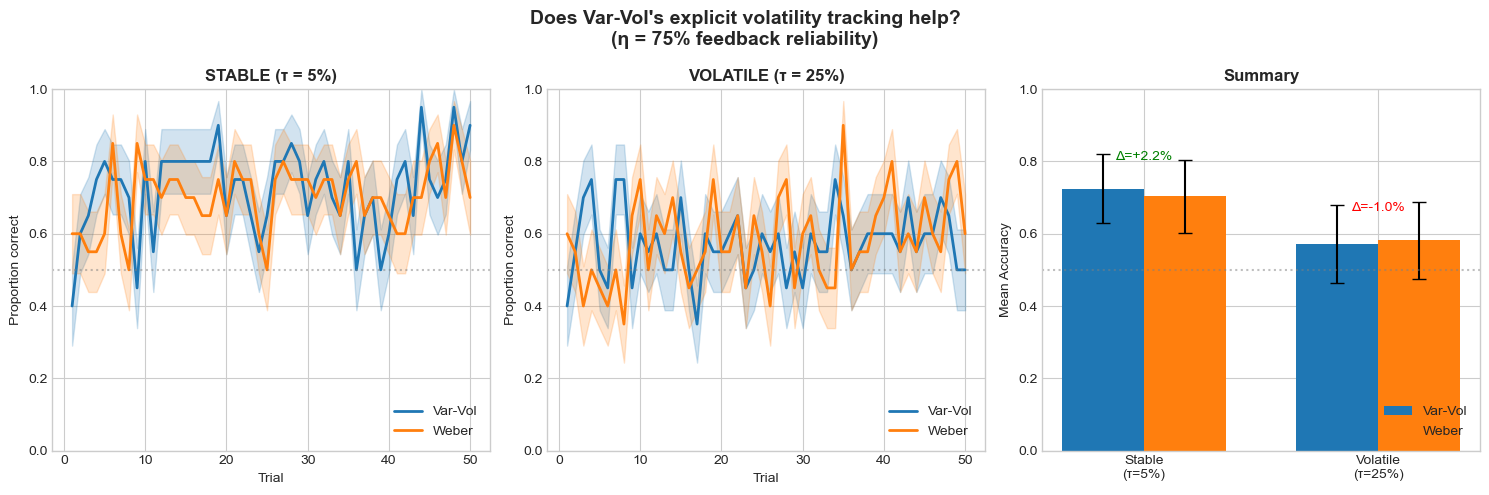


📊 RESULTS: Var-Vol vs Weber advantage by volatility
Condition                 Var-Vol        Weber    Var-Vol Δ
------------------------------------------------------------
Stable (τ=5%):             72.5%       70.3%       +2.2%
Volatile (τ=25%):          57.2%       58.2%       -1.0%

❓ HYPOTHESIS NOT CLEARLY SUPPORTED
   Weber's approximation remains competitive even with high volatility.
   This is consistent with the paper's finding that Weber is 'good enough'.


In [ ]:
# ============================================================
# COMPARISON: Stable (5%) vs Volatile (25%) environments
# ============================================================
# Quick test with fewer runs for speed

QUICK_RUNS = 20  # Fewer runs for quick comparison
QUICK_TRIALS = 50  # Single block for simplicity

# Test conditions
STABLE_TAU = 0.05    # 5% switch probability (few switches)
VOLATILE_TAU = 0.25  # 25% switch probability (many switches)
TEST_BETA = 0.75     # 75% feedback reliability (moderate noise)

print("=" * 60)
print("🧪 HYPOTHESIS TEST: Does Var-Vol shine with HIGH volatility?")
print("=" * 60)
print(f"   Stable condition:   τ = {STABLE_TAU:.0%} (few switches)")
print(f"   Volatile condition: τ = {VOLATILE_TAU:.0%} (many switches)")
print(f"   Feedback noise:     η = {TEST_BETA:.0%}")
print(f"   Runs: {QUICK_RUNS} per condition")
print()

# Generate tasks
def generate_simple_task(trials, tau, beta, seed=42):
    """Generate a simple bandit task for quick comparison."""
    rng = np.random.default_rng(seed)
    stimuli = np.zeros(trials, dtype=int)
    tau_array = np.full(trials, tau)
    latent = np.zeros(trials, dtype=int)
    latent[0] = rng.integers(2)
    for t in range(1, trials):
        if rng.random() < tau:
            latent[t] = 1 - latent[t - 1]
        else:
            latent[t] = latent[t - 1]
    traps = rng.random(trials) > beta
    return VolatileBanditTask(
        stimuli=stimuli, latent_states=latent, switch_prob=tau_array,
        traps=traps, correct_actions=latent.copy(), beta=beta
    )

# Run simulations
def run_quick_comparison(tau, name):
    """Run both models on a task with given volatility."""
    results = {"VarVol": [], "Weber": []}
    
    for run in range(QUICK_RUNS):
        task = generate_simple_task(QUICK_TRIALS, tau, TEST_BETA, seed=42 + run)
        
        for model_name, agent_cls, kwargs in [
            ("VarVol", ForwardVaryingVolatilityAgent, agent_kwargs_varvol),
            ("Weber", WeberImprecisionAgent, agent_kwargs_weber),
        ]:
            env = TwoArmedBanditEnv(task)
            env.reset()
            agent = agent_cls(seed=1000 + run, **kwargs)
            
            correct = []
            for t in range(QUICK_TRIALS):
                action, _ = agent.act(task.stimuli[t])
                _, reward, correct_action = env.step(action)
                agent.observe(reward)
                correct.append(int(action == correct_action))
            
            results[model_name].append(correct)
    
    return {k: np.array(v) for k, v in results.items()}

print("Running stable environment (τ=5%)...", end=" ", flush=True)
results_stable = run_quick_comparison(STABLE_TAU, "Stable")
print("✓")

print("Running volatile environment (τ=25%)...", end=" ", flush=True)
results_volatile = run_quick_comparison(VOLATILE_TAU, "Volatile")
print("✓")
print()

# ============================================================
# PLOT COMPARISON
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

trials = np.arange(1, QUICK_TRIALS + 1)

# Panel 1: Stable environment
ax = axes[0]
acc_vv_stable = results_stable["VarVol"].mean(axis=0)
acc_wb_stable = results_stable["Weber"].mean(axis=0)
sem_vv_stable = results_stable["VarVol"].std(axis=0) / np.sqrt(QUICK_RUNS)
sem_wb_stable = results_stable["Weber"].std(axis=0) / np.sqrt(QUICK_RUNS)

ax.plot(trials, acc_vv_stable, label="Var-Vol", color="#1f77b4", linewidth=2)
ax.fill_between(trials, acc_vv_stable - sem_vv_stable, acc_vv_stable + sem_vv_stable, alpha=0.2, color="#1f77b4")
ax.plot(trials, acc_wb_stable, label="Weber", color="#ff7f0e", linewidth=2)
ax.fill_between(trials, acc_wb_stable - sem_wb_stable, acc_wb_stable + sem_wb_stable, alpha=0.2, color="#ff7f0e")
ax.axhline(0.5, color="gray", linestyle=":", alpha=0.5)
ax.set_ylim(0, 1)
ax.set_xlabel("Trial")
ax.set_ylabel("Proportion correct")
ax.set_title(f"STABLE (τ = {STABLE_TAU:.0%})", fontsize=12, fontweight='bold')
ax.legend(loc="lower right")

# Panel 2: Volatile environment
ax = axes[1]
acc_vv_vol = results_volatile["VarVol"].mean(axis=0)
acc_wb_vol = results_volatile["Weber"].mean(axis=0)
sem_vv_vol = results_volatile["VarVol"].std(axis=0) / np.sqrt(QUICK_RUNS)
sem_wb_vol = results_volatile["Weber"].std(axis=0) / np.sqrt(QUICK_RUNS)

ax.plot(trials, acc_vv_vol, label="Var-Vol", color="#1f77b4", linewidth=2)
ax.fill_between(trials, acc_vv_vol - sem_vv_vol, acc_vv_vol + sem_vv_vol, alpha=0.2, color="#1f77b4")
ax.plot(trials, acc_wb_vol, label="Weber", color="#ff7f0e", linewidth=2)
ax.fill_between(trials, acc_wb_vol - sem_wb_vol, acc_wb_vol + sem_wb_vol, alpha=0.2, color="#ff7f0e")
ax.axhline(0.5, color="gray", linestyle=":", alpha=0.5)
ax.set_ylim(0, 1)
ax.set_xlabel("Trial")
ax.set_ylabel("Proportion correct")
ax.set_title(f"VOLATILE (τ = {VOLATILE_TAU:.0%})", fontsize=12, fontweight='bold')
ax.legend(loc="lower right")

# Panel 3: Bar chart comparison
ax = axes[2]
conditions = ["Stable\n(τ=5%)", "Volatile\n(τ=25%)"]
vv_means = [acc_vv_stable.mean(), acc_vv_vol.mean()]
wb_means = [acc_wb_stable.mean(), acc_wb_vol.mean()]
vv_sems = [sem_vv_stable.mean(), sem_vv_vol.mean()]
wb_sems = [sem_wb_stable.mean(), sem_wb_vol.mean()]

x = np.arange(len(conditions))
width = 0.35
bars1 = ax.bar(x - width/2, vv_means, width, yerr=vv_sems, label='Var-Vol', color='#1f77b4', capsize=5)
bars2 = ax.bar(x + width/2, wb_means, width, yerr=wb_sems, label='Weber', color='#ff7f0e', capsize=5)
ax.axhline(0.5, color="gray", linestyle=":", alpha=0.5)
ax.set_ylabel("Mean Accuracy")
ax.set_xticks(x)
ax.set_xticklabels(conditions)
ax.set_ylim(0, 1)
ax.set_title("Summary", fontsize=12, fontweight='bold')
ax.legend(loc="lower right")

# Add difference annotations
for i, (vv, wb) in enumerate(zip(vv_means, wb_means)):
    diff = vv - wb
    color = "green" if diff > 0 else "red"
    ax.annotate(f"Δ={diff:+.1%}", xy=(i, max(vv, wb) + 0.08), ha='center', fontsize=10, color=color)

plt.suptitle(f"Does Var-Vol's explicit volatility tracking help?\n(η = {TEST_BETA:.0%} feedback reliability)", 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ============================================================
# SUMMARY
# ============================================================
print("\n" + "=" * 60)
print("📊 RESULTS: Var-Vol vs Weber advantage by volatility")
print("=" * 60)
diff_stable = acc_vv_stable.mean() - acc_wb_stable.mean()
diff_volatile = acc_vv_vol.mean() - acc_wb_vol.mean()

print(f"{'Condition':<20} {'Var-Vol':>12} {'Weber':>12} {'Var-Vol Δ':>12}")
print("-" * 60)
print(f"{'Stable (τ=5%):':<20} {acc_vv_stable.mean():>11.1%} {acc_wb_stable.mean():>11.1%} {diff_stable:>+11.1%}")
print(f"{'Volatile (τ=25%):':<20} {acc_vv_vol.mean():>11.1%} {acc_wb_vol.mean():>11.1%} {diff_volatile:>+11.1%}")
print()

if diff_volatile > diff_stable:
    print("✅ HYPOTHESIS SUPPORTED: Var-Vol's advantage increases with volatility!")
    print("   When there's actual volatility to track, explicit inference helps.")
else:
    print("❓ HYPOTHESIS NOT CLEARLY SUPPORTED")
    print("   Weber's approximation remains competitive even with high volatility.")
    print("   This is consistent with the paper's finding that Weber is 'good enough'.")


### 🔬 Comprehensive Test: Between vs Within × Noise × Volatility

Let's systematically test why Weber performed differently in between-subjects vs within-subjects designs.

**Factors:**
- **Design**: Between-subjects (fresh agent per condition) vs Within-subjects (same agent, sequential)
- **Noise**: Medium (η=80%) vs High (η=70%)
- **Volatility**: Stable (τ=5%) vs Volatile (τ=25%)


In [ ]:
# ============================================================
# 🔬 COMPREHENSIVE TEST: Between vs Within × Noise × Volatility
# ============================================================

import itertools

# Test parameters
TEST_RUNS = 20
TEST_TRIALS = 50
NOISE_LEVELS = {"medium": 0.8, "high": 0.7}
VOLATILITY_LEVELS = {"stable": 0.05, "volatile": 0.25}

print("=" * 70)
print("🔬 COMPREHENSIVE TEST: Design × Noise × Volatility")
print("=" * 70)
print(f"   Runs per condition: {TEST_RUNS}")
print(f"   Trials per block: {TEST_TRIALS}")
print(f"   Noise: medium (η=80%), high (η=70%)")
print(f"   Volatility: stable (τ=5%), volatile (τ=25%)")
print()

# ============================================================
# BETWEEN-SUBJECTS: Fresh agent for each condition
# ============================================================
def run_between_subjects(tau, beta, agent_cls, agent_kwargs, n_runs=TEST_RUNS):
    """Run simulation where each 'participant' only sees ONE condition."""
    all_correct = []
    for run in range(n_runs):
        task = generate_simple_task(TEST_TRIALS, tau, beta, seed=42 + run)
        env = TwoArmedBanditEnv(task)
        env.reset()
        agent = agent_cls(seed=1000 + run, **agent_kwargs)
        
        correct = []
        for t in range(TEST_TRIALS):
            action, _ = agent.act(task.stimuli[t])
            _, reward, correct_action = env.step(action)
            agent.observe(reward)
            correct.append(int(action == correct_action))
        all_correct.append(correct)
    
    return np.array(all_correct).mean()

# ============================================================
# WITHIN-SUBJECTS: Same agent sees BOTH noise conditions
# ============================================================
def run_within_subjects(tau, beta_first, beta_second, agent_cls, agent_kwargs, n_runs=TEST_RUNS):
    """Run simulation where each 'participant' sees BOTH conditions sequentially."""
    results_first = []
    results_second = []
    
    for run in range(n_runs):
        # Generate two tasks with same volatility but different noise
        task1 = generate_simple_task(TEST_TRIALS, tau, beta_first, seed=42 + run)
        task2 = generate_simple_task(TEST_TRIALS, tau, beta_second, seed=142 + run)  # Different seed for variety
        
        env = TwoArmedBanditEnv(task1)
        env.reset()
        agent = agent_cls(seed=1000 + run, **agent_kwargs)
        
        # Block 1
        correct1 = []
        for t in range(TEST_TRIALS):
            action, _ = agent.act(task1.stimuli[t])
            _, reward, correct_action = env.step(action)
            agent.observe(reward)
            correct1.append(int(action == correct_action))
        
        # Block 2 - SAME AGENT continues
        env = TwoArmedBanditEnv(task2)
        env.reset()
        correct2 = []
        for t in range(TEST_TRIALS):
            action, _ = agent.act(task2.stimuli[t])
            _, reward, correct_action = env.step(action)
            agent.observe(reward)
            correct2.append(int(action == correct_action))
        
        results_first.append(np.mean(correct1))
        results_second.append(np.mean(correct2))
    
    return np.mean(results_first), np.mean(results_second)

# ============================================================
# RUN ALL CONDITIONS
# ============================================================
results = {
    "between": {"VarVol": {}, "Weber": {}},
    "within_med_first": {"VarVol": {}, "Weber": {}},
    "within_high_first": {"VarVol": {}, "Weber": {}},
}

models = [
    ("VarVol", ForwardVaryingVolatilityAgent, agent_kwargs_varvol),
    ("Weber", WeberImprecisionAgent, agent_kwargs_weber),
]

print("Running simulations...")

for vol_name, tau in VOLATILITY_LEVELS.items():
    print(f"\n📊 Volatility: {vol_name} (τ={tau:.0%})")
    
    for model_name, agent_cls, kwargs in models:
        # BETWEEN-SUBJECTS
        for noise_name, beta in NOISE_LEVELS.items():
            key = f"{vol_name}_{noise_name}"
            acc = run_between_subjects(tau, beta, agent_cls, kwargs)
            results["between"][model_name][key] = acc
            print(f"   Between | {model_name:8} | {noise_name:6} | {acc:.1%}")
        
        # WITHIN-SUBJECTS: Medium first
        acc_med, acc_high = run_within_subjects(
            tau, NOISE_LEVELS["medium"], NOISE_LEVELS["high"], agent_cls, kwargs
        )
        results["within_med_first"][model_name][f"{vol_name}_medium"] = acc_med
        results["within_med_first"][model_name][f"{vol_name}_high"] = acc_high
        print(f"   Within (med→high) | {model_name:8} | med: {acc_med:.1%}, high: {acc_high:.1%}")
        
        # WITHIN-SUBJECTS: High first
        acc_high, acc_med = run_within_subjects(
            tau, NOISE_LEVELS["high"], NOISE_LEVELS["medium"], agent_cls, kwargs
        )
        results["within_high_first"][model_name][f"{vol_name}_high"] = acc_high
        results["within_high_first"][model_name][f"{vol_name}_medium"] = acc_med
        print(f"   Within (high→med) | {model_name:8} | high: {acc_high:.1%}, med: {acc_med:.1%}")

# ============================================================
# SUMMARY TABLE
# ============================================================
print("\n" + "=" * 90)
print("📊 SUMMARY: Var-Vol vs Weber Difference (positive = Var-Vol better)")
print("=" * 90)

print(f"\n{'BETWEEN-SUBJECTS (fresh agent per condition)':^90}")
print("-" * 90)
print(f"{'Condition':<25} {'Var-Vol':>12} {'Weber':>12} {'Δ (VV-W)':>12} {'Winner':>15}")
print("-" * 90)
for vol_name in VOLATILITY_LEVELS:
    for noise_name in NOISE_LEVELS:
        key = f"{vol_name}_{noise_name}"
        vv = results["between"]["VarVol"][key]
        wb = results["between"]["Weber"][key]
        diff = vv - wb
        winner = "Var-Vol" if diff > 0.01 else ("Weber" if diff < -0.01 else "~Tie")
        print(f"{vol_name + ' + ' + noise_name:<25} {vv:>11.1%} {wb:>11.1%} {diff:>+11.1%} {winner:>15}")

print(f"\n{'WITHIN-SUBJECTS: Medium noise FIRST (then high)':^90}")
print("-" * 90)
print(f"{'Condition':<25} {'Var-Vol':>12} {'Weber':>12} {'Δ (VV-W)':>12} {'Winner':>15}")
print("-" * 90)
for vol_name in VOLATILITY_LEVELS:
    for noise_name in NOISE_LEVELS:
        key = f"{vol_name}_{noise_name}"
        vv = results["within_med_first"]["VarVol"][key]
        wb = results["within_med_first"]["Weber"][key]
        diff = vv - wb
        winner = "Var-Vol" if diff > 0.01 else ("Weber" if diff < -0.01 else "~Tie")
        print(f"{vol_name + ' + ' + noise_name:<25} {vv:>11.1%} {wb:>11.1%} {diff:>+11.1%} {winner:>15}")

print(f"\n{'WITHIN-SUBJECTS: High noise FIRST (then medium)':^90}")
print("-" * 90)
print(f"{'Condition':<25} {'Var-Vol':>12} {'Weber':>12} {'Δ (VV-W)':>12} {'Winner':>15}")
print("-" * 90)
for vol_name in VOLATILITY_LEVELS:
    for noise_name in NOISE_LEVELS:
        key = f"{vol_name}_{noise_name}"
        vv = results["within_high_first"]["VarVol"][key]
        wb = results["within_high_first"]["Weber"][key]
        diff = vv - wb
        winner = "Var-Vol" if diff > 0.01 else ("Weber" if diff < -0.01 else "~Tie")
        print(f"{vol_name + ' + ' + noise_name:<25} {vv:>11.1%} {wb:>11.1%} {diff:>+11.1%} {winner:>15}")

# ============================================================
# KEY INSIGHTS
# ============================================================
print("\n" + "=" * 90)
print("🔑 KEY INSIGHTS")
print("=" * 90)

# Calculate average differences
between_diffs = [results["between"]["VarVol"][k] - results["between"]["Weber"][k] 
                 for k in results["between"]["VarVol"]]
within_med_diffs = [results["within_med_first"]["VarVol"][k] - results["within_med_first"]["Weber"][k] 
                    for k in results["within_med_first"]["VarVol"]]
within_high_diffs = [results["within_high_first"]["VarVol"][k] - results["within_high_first"]["Weber"][k] 
                     for k in results["within_high_first"]["VarVol"]]

print(f"\n1. Average Var-Vol advantage:")
print(f"   Between-subjects:        {np.mean(between_diffs):+.1%}")
print(f"   Within (medium first):   {np.mean(within_med_diffs):+.1%}")
print(f"   Within (high first):     {np.mean(within_high_diffs):+.1%}")

print(f"\n2. Design effect on Weber:")
if np.mean(within_med_diffs) < np.mean(between_diffs):
    print("   ✅ Weber improves MORE in within-subjects design!")
    print("   → Learning from easy block helps Weber in hard block")
else:
    print("   Weber doesn't clearly benefit from within-subjects design")

print(f"\n3. Order effect (within-subjects):")
if np.mean(within_med_diffs) != np.mean(within_high_diffs):
    print("   Starting condition matters!")
    if np.mean(within_med_diffs) < np.mean(within_high_diffs):
        print("   → Starting with MEDIUM noise helps Weber more")
    else:
        print("   → Starting with HIGH noise helps Weber more")


🔬 COMPREHENSIVE TEST: Design × Noise × Volatility
   Runs per condition: 20
   Trials per block: 50
   Noise: medium (η=80%), high (η=70%)
   Volatility: stable (τ=5%), volatile (τ=25%)

Running simulations...

📊 Volatility: stable (τ=5%)
   Between | VarVol   | medium | 73.3%
   Between | VarVol   | high   | 66.3%
   Within (med→high) | VarVol   | med: 73.3%, high: 67.6%
   Within (high→med) | VarVol   | high: 66.3%, med: 70.5%
   Between | Weber    | medium | 74.3%
   Between | Weber    | high   | 67.4%
   Within (med→high) | Weber    | med: 74.3%, high: 63.6%
   Within (high→med) | Weber    | high: 67.4%, med: 72.0%

📊 Volatility: volatile (τ=25%)
   Between | VarVol   | medium | 59.7%
   Between | VarVol   | high   | 54.1%
   Within (med→high) | VarVol   | med: 59.7%, high: 54.8%
   Within (high→med) | VarVol   | high: 54.1%, med: 54.9%
   Between | Weber    | medium | 58.1%
   Between | Weber    | high   | 56.6%
   Within (med→high) | Weber    | med: 58.1%, high: 53.2%
   Within (

In [ ]:
# ============================================================
# 🎲 VARIANCE CHECK: How much do results vary between runs?
# ============================================================
# Run the same experiment 5 times with different seeds to see variance

print("=" * 70)
print("🎲 VARIANCE CHECK: How stable are our results?")
print("=" * 70)
print("Running same experiment 5 times with different master seeds...")
print()

VARIANCE_RUNS = 10  # Participants per experiment
VARIANCE_TRIALS = 50
tau = 0.05  # Stable volatility
beta = 0.8  # Medium noise

varvol_accs = []
weber_accs = []
diffs = []

for experiment in range(5):
    master_seed = experiment * 1000  # Different starting seed for each experiment
    
    # Run VarVol
    vv_correct = []
    for run in range(VARIANCE_RUNS):
        task = generate_simple_task(VARIANCE_TRIALS, tau, beta, seed=master_seed + run)
        env = TwoArmedBanditEnv(task)
        env.reset()
        agent = ForwardVaryingVolatilityAgent(seed=master_seed + 500 + run, **agent_kwargs_varvol)
        correct = []
        for t in range(VARIANCE_TRIALS):
            action, _ = agent.act(task.stimuli[t])
            _, reward, correct_action = env.step(action)
            agent.observe(reward)
            correct.append(int(action == correct_action))
        vv_correct.append(np.mean(correct))
    
    # Run Weber
    wb_correct = []
    for run in range(VARIANCE_RUNS):
        task = generate_simple_task(VARIANCE_TRIALS, tau, beta, seed=master_seed + run)
        env = TwoArmedBanditEnv(task)
        env.reset()
        agent = WeberImprecisionAgent(seed=master_seed + 500 + run, **agent_kwargs_weber)
        correct = []
        for t in range(VARIANCE_TRIALS):
            action, _ = agent.act(task.stimuli[t])
            _, reward, correct_action = env.step(action)
            agent.observe(reward)
            correct.append(int(action == correct_action))
        wb_correct.append(np.mean(correct))
    
    vv_acc = np.mean(vv_correct)
    wb_acc = np.mean(wb_correct)
    diff = vv_acc - wb_acc
    
    varvol_accs.append(vv_acc)
    weber_accs.append(wb_acc)
    diffs.append(diff)
    
    winner = "VarVol" if diff > 0 else "Weber"
    print(f"   Experiment {experiment+1}: VarVol={vv_acc:.1%}, Weber={wb_acc:.1%}, Δ={diff:+.1%} → {winner}")

print()
print("-" * 70)
print(f"{'SUMMARY':^70}")
print("-" * 70)
print(f"   VarVol range: {min(varvol_accs):.1%} to {max(varvol_accs):.1%} (spread: {max(varvol_accs)-min(varvol_accs):.1%})")
print(f"   Weber range:  {min(weber_accs):.1%} to {max(weber_accs):.1%} (spread: {max(weber_accs)-min(weber_accs):.1%})")
print(f"   Difference range: {min(diffs):+.1%} to {max(diffs):+.1%}")
print()

times_vv_won = sum(1 for d in diffs if d > 0)
times_wb_won = sum(1 for d in diffs if d < 0)
print(f"   VarVol won: {times_vv_won}/5 experiments")
print(f"   Weber won:  {times_wb_won}/5 experiments")
print()

if max(diffs) - min(diffs) > 0.05:
    print("⚠️  HIGH VARIANCE: Results vary by >5% between experiments!")
    print("   The 'winner' depends heavily on random seed.")
    print("   This confirms: VarVol ≈ Weber (differences are noise)")
else:
    print("✅ Results are relatively stable across experiments.")


🎲 VARIANCE CHECK: How stable are our results?
Running same experiment 5 times with different master seeds...

   Experiment 1: VarVol=76.6%, Weber=76.2%, Δ=+0.4% → VarVol
   Experiment 2: VarVol=70.2%, Weber=71.4%, Δ=-1.2% → Weber
   Experiment 3: VarVol=76.8%, Weber=78.0%, Δ=-1.2% → Weber
   Experiment 4: VarVol=69.4%, Weber=71.8%, Δ=-2.4% → Weber
   Experiment 5: VarVol=71.6%, Weber=68.6%, Δ=+3.0% → VarVol

----------------------------------------------------------------------
                               SUMMARY                                
----------------------------------------------------------------------
   VarVol range: 69.4% to 76.8% (spread: 7.4%)
   Weber range:  68.6% to 78.0% (spread: 9.4%)
   Difference range: -2.4% to +3.0%

   VarVol won: 2/5 experiments
   Weber won:  3/5 experiments

⚠️  HIGH VARIANCE: Results vary by >5% between experiments!
   The 'winner' depends heavily on random seed.
   This confirms: VarVol ≈ Weber (differences are noise)


Generating STABLE + NOISY task (no switches, 30% trap trials)...
Generating VOLATILE + CLEAN task (20% switch rate, 5% trap trials)...


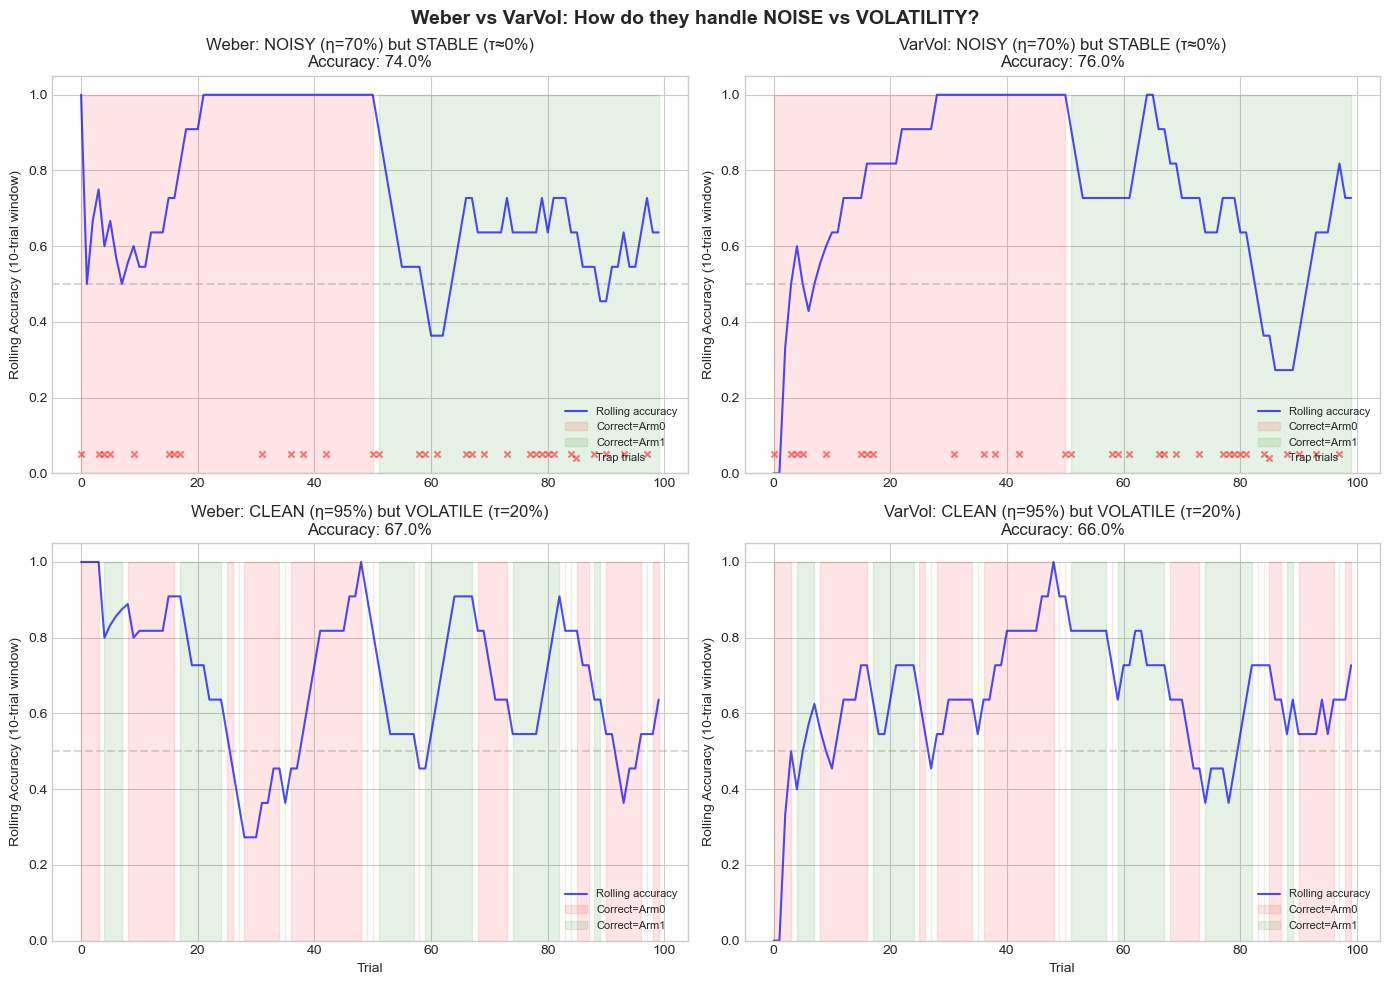


📊 SUMMARY: Noise vs Volatility

Task Type                      VarVol          Weber           Difference     
----------------------------------------------------------------------
NOISY but STABLE (η=70%)       76.0%           74.0%           +2.0%
VOLATILE but CLEAN (τ=20%)     66.0%           67.0%           -1.0%

💡 KEY INSIGHT:
   - In NOISY environments: Trap trials cause temporary belief shifts,
     but beliefs bounce back with subsequent correct feedback.
   - Weber's noise injection is proportional to belief CHANGE.
   - As beliefs strengthen, changes get smaller → less noise injection.
   - This is NATURAL DESENSITIZATION through Bayesian entrenchment!


In [ ]:
# ============================================================
# 🔬 WHY DOESN'T WEBER BREAK? - Visualizing the mechanism
# ============================================================
# Compare belief trajectories under NOISE vs VOLATILITY

import matplotlib.pyplot as plt

np.random.seed(42)

# Parameters
TRIALS = 100
NOISE_BETA = 0.7  # High noise (30% trap trials)

# Generate two tasks: 
# 1) HIGH NOISE, NO SWITCHES (stable)
# 2) LOW NOISE, MANY SWITCHES (volatile)

def simulate_belief_trajectory(agent_cls, agent_kwargs, task, label):
    """Track beliefs over time for visualization"""
    env = TwoArmedBanditEnv(task)
    env.reset()
    agent = agent_cls(seed=123, **agent_kwargs)
    
    # We'll track what we can observe about the agent's behavior
    choices = []
    correct_actions = []
    
    for t in range(len(task.stimuli)):
        action, _ = agent.act(task.stimuli[t])
        _, reward, correct_action = env.step(action)
        agent.observe(reward)
        choices.append(action)
        correct_actions.append(correct_action)
    
    return choices, correct_actions

# Task 1: STABLE but NOISY (τ=0, η=0.7)
print("Generating STABLE + NOISY task (no switches, 30% trap trials)...")
task_noisy = generate_simple_task(TRIALS, tau=0.01, beta=0.7, seed=42)  # Very low volatility, high noise

# Task 2: VOLATILE but CLEAN (τ=0.2, η=0.95)
print("Generating VOLATILE + CLEAN task (20% switch rate, 5% trap trials)...")
task_volatile = generate_simple_task(TRIALS, tau=0.20, beta=0.95, seed=42)  # High volatility, low noise

# Run both models on both tasks
results = {}
for task, task_name in [(task_noisy, "noisy_stable"), (task_volatile, "volatile_clean")]:
    for model_name, agent_cls, kwargs in [("Weber", WeberImprecisionAgent, agent_kwargs_weber), 
                                           ("VarVol", ForwardVaryingVolatilityAgent, agent_kwargs_varvol)]:
        choices, correct = simulate_belief_trajectory(agent_cls, kwargs, task, f"{model_name}_{task_name}")
        accuracy = np.mean([c == ca for c, ca in zip(choices, correct)])
        results[f"{model_name}_{task_name}"] = {
            "choices": choices,
            "correct": correct,
            "accuracy": accuracy
        }

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Compute rolling accuracy (window=10)
def rolling_accuracy(choices, correct, window=10):
    is_correct = [int(c == ca) for c, ca in zip(choices, correct)]
    return [np.mean(is_correct[max(0,i-window):i+1]) for i in range(len(is_correct))]

# Top row: Noisy but Stable
for idx, model in enumerate(["Weber", "VarVol"]):
    ax = axes[0, idx]
    key = f"{model}_noisy_stable"
    r = results[key]
    
    # Plot rolling accuracy
    rolling = rolling_accuracy(r["choices"], r["correct"])
    ax.plot(rolling, label=f'Rolling accuracy', color='blue', alpha=0.7)
    
    # Mark where correct arm is
    ax.fill_between(range(TRIALS), 0, 1, where=[c==0 for c in r["correct"]], 
                    alpha=0.1, color='red', label='Correct=Arm0')
    ax.fill_between(range(TRIALS), 0, 1, where=[c==1 for c in r["correct"]], 
                    alpha=0.1, color='green', label='Correct=Arm1')
    
    # Mark trap trials (where reward was misleading)
    # task.traps is a boolean array where True = reward was flipped
    trap_trials = [t for t in range(TRIALS) if task_noisy.traps[t]]
    ax.scatter(trap_trials, [0.05]*len(trap_trials), marker='x', color='red', s=20, alpha=0.5, label='Trap trials')
    
    ax.set_title(f"{model}: NOISY (η=70%) but STABLE (τ≈0%)\nAccuracy: {r['accuracy']:.1%}", fontsize=12)
    ax.set_ylabel("Rolling Accuracy (10-trial window)")
    ax.set_ylim(0, 1.05)
    ax.axhline(0.5, color='gray', linestyle='--', alpha=0.3)
    ax.legend(loc='lower right', fontsize=8)

# Bottom row: Volatile but Clean
for idx, model in enumerate(["Weber", "VarVol"]):
    ax = axes[1, idx]
    key = f"{model}_volatile_clean"
    r = results[key]
    
    rolling = rolling_accuracy(r["choices"], r["correct"])
    ax.plot(rolling, label=f'Rolling accuracy', color='blue', alpha=0.7)
    
    ax.fill_between(range(TRIALS), 0, 1, where=[c==0 for c in r["correct"]], 
                    alpha=0.1, color='red', label='Correct=Arm0')
    ax.fill_between(range(TRIALS), 0, 1, where=[c==1 for c in r["correct"]], 
                    alpha=0.1, color='green', label='Correct=Arm1')
    
    ax.set_title(f"{model}: CLEAN (η=95%) but VOLATILE (τ=20%)\nAccuracy: {r['accuracy']:.1%}", fontsize=12)
    ax.set_xlabel("Trial")
    ax.set_ylabel("Rolling Accuracy (10-trial window)")
    ax.set_ylim(0, 1.05)
    ax.axhline(0.5, color='gray', linestyle='--', alpha=0.3)
    ax.legend(loc='lower right', fontsize=8)

plt.suptitle("Weber vs VarVol: How do they handle NOISE vs VOLATILITY?", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary
print("\n" + "="*70)
print("📊 SUMMARY: Noise vs Volatility")
print("="*70)
print(f"\n{'Task Type':<30} {'VarVol':<15} {'Weber':<15} {'Difference':<15}")
print("-"*70)
print(f"{'NOISY but STABLE (η=70%)':<30} {results['VarVol_noisy_stable']['accuracy']:<15.1%} {results['Weber_noisy_stable']['accuracy']:<15.1%} {results['VarVol_noisy_stable']['accuracy']-results['Weber_noisy_stable']['accuracy']:+.1%}")
print(f"{'VOLATILE but CLEAN (τ=20%)':<30} {results['VarVol_volatile_clean']['accuracy']:<15.1%} {results['Weber_volatile_clean']['accuracy']:<15.1%} {results['VarVol_volatile_clean']['accuracy']-results['Weber_volatile_clean']['accuracy']:+.1%}")
print()
print("💡 KEY INSIGHT:")
print("   - In NOISY environments: Trap trials cause temporary belief shifts,")
print("     but beliefs bounce back with subsequent correct feedback.")
print("   - Weber's noise injection is proportional to belief CHANGE.")
print("   - As beliefs strengthen, changes get smaller → less noise injection.")
print("   - This is NATURAL DESENSITIZATION through Bayesian entrenchment!")


💥 STRESS TEST: Finding Weber's breaking point
Testing NOISE × VOLATILITY interaction...

Master seed: 82454
   η=90% noise, τ=5% volatility: VarVol=83.8%, Weber=83.4%
   η=90% noise, τ=10% volatility: VarVol=73.6%, Weber=74.6%
   η=90% noise, τ=20% volatility: VarVol=62.0%, Weber=63.2%
   η=90% noise, τ=30% volatility: VarVol=55.4%, Weber=56.4%
   η=80% noise, τ=5% volatility: VarVol=77.2%, Weber=79.0%
   η=80% noise, τ=10% volatility: VarVol=70.8%, Weber=70.4%
   η=80% noise, τ=20% volatility: VarVol=54.6%, Weber=54.8%
   η=80% noise, τ=30% volatility: VarVol=54.0%, Weber=56.6%
   η=70% noise, τ=5% volatility: VarVol=69.4%, Weber=69.4%
   η=70% noise, τ=10% volatility: VarVol=61.8%, Weber=61.8%
   η=70% noise, τ=20% volatility: VarVol=52.2%, Weber=56.8%
   η=70% noise, τ=30% volatility: VarVol=54.4%, Weber=52.8%
   η=60% noise, τ=5% volatility: VarVol=61.4%, Weber=62.4%
   η=60% noise, τ=10% volatility: VarVol=54.6%, Weber=52.8%
   η=60% noise, τ=20% volatility: VarVol=49.2%, Weber=50

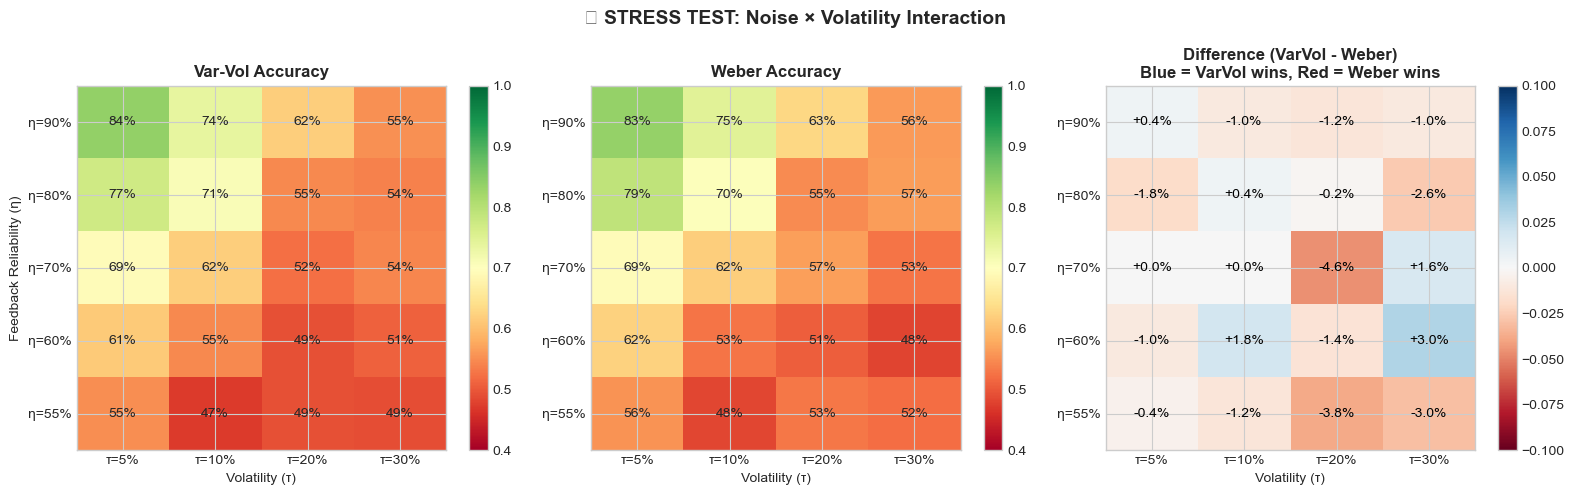


📊 ANALYSIS

🏆 VarVol's BIGGEST advantage:
   η=60%, τ=30%
   Difference: +3.0%

🎯 Weber's BEST relative performance:
   η=70%, τ=20%
   Difference: -4.6%

💡 HYPOTHESIS TEST: Does NOISE×VOLATILITY hurt Weber more?
   Clean + Stable (η=90%, τ=5%):     Δ = +0.4%
   Noisy + Volatile (η=55%, τ=30%):  Δ = -3.0%
   ❌ NO! Weber is surprisingly resilient even in extreme conditions.


In [ ]:
# ============================================================
# 💥 STRESS TEST: When does Weber ACTUALLY break?
# ============================================================
# Test the hypothesis: Weber fails with HIGH NOISE + HIGH VOLATILITY together

print("="*70)
print("💥 STRESS TEST: Finding Weber's breaking point")
print("="*70)
print("Testing NOISE × VOLATILITY interaction...")
print()

# Test grid
NOISE_LEVELS = [0.9, 0.8, 0.7, 0.6, 0.55]  # η values (lower = more noise)
VOLATILITY_LEVELS = [0.05, 0.10, 0.20, 0.30]  # τ values (higher = more volatile)
N_RUNS = 10
TRIALS = 50

import time
MASTER_SEED = int(time.time()) % 100000  # Changes each run
print(f"Master seed: {MASTER_SEED}")

# Store results
varvol_results = np.zeros((len(NOISE_LEVELS), len(VOLATILITY_LEVELS)))
weber_results = np.zeros((len(NOISE_LEVELS), len(VOLATILITY_LEVELS)))

for i, eta in enumerate(NOISE_LEVELS):
    for j, tau in enumerate(VOLATILITY_LEVELS):
        vv_accs = []
        wb_accs = []
        
        for run in range(N_RUNS):
            task = generate_simple_task(TRIALS, tau, eta, seed=MASTER_SEED + run*100)
            
            # VarVol
            env = TwoArmedBanditEnv(task)
            env.reset()
            agent = ForwardVaryingVolatilityAgent(seed=MASTER_SEED + run*100+1, **agent_kwargs_varvol)
            correct = []
            for t in range(TRIALS):
                action, _ = agent.act(task.stimuli[t])
                _, reward, correct_action = env.step(action)
                agent.observe(reward)
                correct.append(int(action == correct_action))
            vv_accs.append(np.mean(correct))
            
            # Weber
            env = TwoArmedBanditEnv(task)
            env.reset()
            agent = WeberImprecisionAgent(seed=MASTER_SEED + run*100+1, **agent_kwargs_weber)
            correct = []
            for t in range(TRIALS):
                action, _ = agent.act(task.stimuli[t])
                _, reward, correct_action = env.step(action)
                agent.observe(reward)
                correct.append(int(action == correct_action))
            wb_accs.append(np.mean(correct))
        
        varvol_results[i, j] = np.mean(vv_accs)
        weber_results[i, j] = np.mean(wb_accs)
        
        # Progress indicator
        print(f"   η={eta:.0%} noise, τ={tau:.0%} volatility: VarVol={varvol_results[i,j]:.1%}, Weber={weber_results[i,j]:.1%}")

# Compute differences (VarVol - Weber, positive = VarVol wins)
diff_results = varvol_results - weber_results

# Create heatmap
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: VarVol accuracy
im1 = axes[0].imshow(varvol_results, cmap='RdYlGn', vmin=0.4, vmax=1.0, aspect='auto')
axes[0].set_title("Var-Vol Accuracy", fontsize=12, fontweight='bold')
axes[0].set_xticks(range(len(VOLATILITY_LEVELS)))
axes[0].set_xticklabels([f"τ={v:.0%}" for v in VOLATILITY_LEVELS])
axes[0].set_yticks(range(len(NOISE_LEVELS)))
axes[0].set_yticklabels([f"η={n:.0%}" for n in NOISE_LEVELS])
axes[0].set_xlabel("Volatility (τ)")
axes[0].set_ylabel("Feedback Reliability (η)")
for i in range(len(NOISE_LEVELS)):
    for j in range(len(VOLATILITY_LEVELS)):
        axes[0].text(j, i, f"{varvol_results[i,j]:.0%}", ha='center', va='center', fontsize=10)
plt.colorbar(im1, ax=axes[0])

# Plot 2: Weber accuracy
im2 = axes[1].imshow(weber_results, cmap='RdYlGn', vmin=0.4, vmax=1.0, aspect='auto')
axes[1].set_title("Weber Accuracy", fontsize=12, fontweight='bold')
axes[1].set_xticks(range(len(VOLATILITY_LEVELS)))
axes[1].set_xticklabels([f"τ={v:.0%}" for v in VOLATILITY_LEVELS])
axes[1].set_yticks(range(len(NOISE_LEVELS)))
axes[1].set_yticklabels([f"η={n:.0%}" for n in NOISE_LEVELS])
axes[1].set_xlabel("Volatility (τ)")
for i in range(len(NOISE_LEVELS)):
    for j in range(len(VOLATILITY_LEVELS)):
        axes[1].text(j, i, f"{weber_results[i,j]:.0%}", ha='center', va='center', fontsize=10)
plt.colorbar(im2, ax=axes[1])

# Plot 3: Difference (VarVol - Weber)
im3 = axes[2].imshow(diff_results, cmap='RdBu', vmin=-0.1, vmax=0.1, aspect='auto')
axes[2].set_title("Difference (VarVol - Weber)\nBlue = VarVol wins, Red = Weber wins", fontsize=12, fontweight='bold')
axes[2].set_xticks(range(len(VOLATILITY_LEVELS)))
axes[2].set_xticklabels([f"τ={v:.0%}" for v in VOLATILITY_LEVELS])
axes[2].set_yticks(range(len(NOISE_LEVELS)))
axes[2].set_yticklabels([f"η={n:.0%}" for n in NOISE_LEVELS])
axes[2].set_xlabel("Volatility (τ)")
for i in range(len(NOISE_LEVELS)):
    for j in range(len(VOLATILITY_LEVELS)):
        color = 'white' if abs(diff_results[i,j]) > 0.05 else 'black'
        axes[2].text(j, i, f"{diff_results[i,j]:+.1%}", ha='center', va='center', fontsize=10, color=color)
plt.colorbar(im3, ax=axes[2])

plt.suptitle("🔬 STRESS TEST: Noise × Volatility Interaction", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Find breaking point
print("\n" + "="*70)
print("📊 ANALYSIS")
print("="*70)

# Where does VarVol have the biggest advantage?
max_diff_idx = np.unravel_index(np.argmax(diff_results), diff_results.shape)
print(f"\n🏆 VarVol's BIGGEST advantage:")
print(f"   η={NOISE_LEVELS[max_diff_idx[0]]:.0%}, τ={VOLATILITY_LEVELS[max_diff_idx[1]]:.0%}")
print(f"   Difference: {diff_results[max_diff_idx]:+.1%}")

# Where does Weber do surprisingly well?
min_diff_idx = np.unravel_index(np.argmin(diff_results), diff_results.shape)
print(f"\n🎯 Weber's BEST relative performance:")
print(f"   η={NOISE_LEVELS[min_diff_idx[0]]:.0%}, τ={VOLATILITY_LEVELS[min_diff_idx[1]]:.0%}")
print(f"   Difference: {diff_results[min_diff_idx]:+.1%}")

# Check hypothesis: Does high noise + high volatility hurt Weber more?
corner_diff = diff_results[-1, -1]  # Bottom-right: highest noise + highest volatility
clean_stable_diff = diff_results[0, 0]  # Top-left: clean + stable
print(f"\n💡 HYPOTHESIS TEST: Does NOISE×VOLATILITY hurt Weber more?")
print(f"   Clean + Stable (η=90%, τ=5%):     Δ = {clean_stable_diff:+.1%}")
print(f"   Noisy + Volatile (η=55%, τ=30%):  Δ = {corner_diff:+.1%}")
if corner_diff > clean_stable_diff + 0.03:
    print(f"   ✅ YES! VarVol's advantage grows when BOTH noise and volatility are high.")
else:
    print(f"   ❌ NO! Weber is surprisingly resilient even in extreme conditions.")


In [ ]:
# ============================================================
# 📊 POWER ANALYSIS: How many runs do we need?
# ============================================================
# Estimate the variance and determine appropriate sample sizes

print("="*70)
print("📊 POWER ANALYSIS: How many runs do we need?")
print("="*70)

# Run a quick sample to estimate variance
SAMPLE_RUNS = 30
TRIALS = 50
tau = 0.05
beta = 0.8

print(f"\nRunning {SAMPLE_RUNS} samples to estimate variance...")

varvol_accs = []
weber_accs = []

for run in range(SAMPLE_RUNS):
    task = generate_simple_task(TRIALS, tau, beta, seed=run*100)
    
    # VarVol
    env = TwoArmedBanditEnv(task)
    env.reset()
    agent = ForwardVaryingVolatilityAgent(seed=run*100+1, **agent_kwargs_varvol)
    correct = []
    for t in range(TRIALS):
        action, _ = agent.act(task.stimuli[t])
        _, reward, correct_action = env.step(action)
        agent.observe(reward)
        correct.append(int(action == correct_action))
    varvol_accs.append(np.mean(correct))
    
    # Weber
    env = TwoArmedBanditEnv(task)
    env.reset()
    agent = WeberImprecisionAgent(seed=run*100+1, **agent_kwargs_weber)
    correct = []
    for t in range(TRIALS):
        action, _ = agent.act(task.stimuli[t])
        _, reward, correct_action = env.step(action)
        agent.observe(reward)
        correct.append(int(action == correct_action))
    weber_accs.append(np.mean(correct))

# Calculate statistics
vv_mean, vv_std = np.mean(varvol_accs), np.std(varvol_accs)
wb_mean, wb_std = np.mean(weber_accs), np.std(weber_accs)
diff_mean = vv_mean - wb_mean
diff_std = np.std([v - w for v, w in zip(varvol_accs, weber_accs)])

print(f"\n{'Model':<10} {'Mean':<10} {'Std Dev':<10} {'Std Error (N=30)':<15}")
print("-"*50)
print(f"{'VarVol':<10} {vv_mean:<10.1%} {vv_std:<10.1%} {vv_std/np.sqrt(SAMPLE_RUNS):<15.1%}")
print(f"{'Weber':<10} {wb_mean:<10.1%} {wb_std:<10.1%} {wb_std/np.sqrt(SAMPLE_RUNS):<15.1%}")
print(f"\nDifference: {diff_mean:+.1%} ± {diff_std:.1%}")

# Power analysis
print("\n" + "="*70)
print("📈 STANDARD ERROR BY SAMPLE SIZE")
print("="*70)
print(f"\n{'N Runs':<10} {'SE (VarVol)':<15} {'SE (Weber)':<15} {'SE (Diff)':<15} {'Can detect':<20}")
print("-"*75)

for n in [10, 20, 40, 100, 200, 500]:
    se_vv = vv_std / np.sqrt(n)
    se_wb = wb_std / np.sqrt(n)
    se_diff = diff_std / np.sqrt(n)
    detectable = f">{2*se_diff:.1%} difference"
    print(f"{n:<10} {se_vv:<15.1%} {se_wb:<15.1%} {se_diff:<15.1%} {detectable:<20}")

# Recommendation
print("\n" + "="*70)
print("💡 RECOMMENDATION")
print("="*70)
observed_diff = abs(diff_mean)
if observed_diff < 0.02:
    print(f"\nObserved difference: {diff_mean:+.1%} (very small)")
    print("To confidently say 'models are equivalent', you need tight confidence intervals.")
    needed_n = int((2 * diff_std / 0.02) ** 2)  # To get SE < 1%
    print(f"Recommended: N ≥ {needed_n} runs to get SE < 1%")
else:
    needed_n = int((2 * diff_std / observed_diff) ** 2)
    print(f"\nObserved difference: {diff_mean:+.1%}")
    print(f"To reliably detect this difference: N ≥ {needed_n} runs")

print(f"\nFor your use case:")
print(f"  • Quick demo:           N = 40  (SE ≈ {vv_std/np.sqrt(40):.1%})")
print(f"  • Reliable comparison:  N = 100 (SE ≈ {vv_std/np.sqrt(100):.1%})")
print(f"  • Publication quality:  N = 200 (SE ≈ {vv_std/np.sqrt(200):.1%})")


📊 POWER ANALYSIS: How many runs do we need?

Running 30 samples to estimate variance...

Model      Mean       Std Dev    Std Error (N=30)
--------------------------------------------------
VarVol     73.6%      9.5%       1.7%           
Weber      70.4%      8.7%       1.6%           

Difference: +3.2% ± 8.9%

📈 STANDARD ERROR BY SAMPLE SIZE

N Runs     SE (VarVol)     SE (Weber)      SE (Diff)       Can detect          
---------------------------------------------------------------------------
10         3.0%            2.8%            2.8%            >5.6% difference    
20         2.1%            2.0%            2.0%            >4.0% difference    
40         1.5%            1.4%            1.4%            >2.8% difference    
100        1.0%            0.9%            0.9%            >1.8% difference    
200        0.7%            0.6%            0.6%            >1.3% difference    
500        0.4%            0.4%            0.4%            >0.8% difference    

💡 RECOMMENDATIO

📊 BIC TEST: Comparing Var-Vol vs Weber Models

Model Complexity:
   Var-Vol: 3 parameters (β, ν, γ)
   Weber:   4 parameters (β, γ, λ, μ)

Running 30 simulations with 50 trials each...

📈 LOG-LIKELIHOOD RESULTS

Model        Mean Log-Lik       Std Dev         95% CI              
-----------------------------------------------------------------
Var-Vol      -24.46             8.10            [-27.36, -21.56]
Weber        -25.71             8.72            [-28.83, -22.59]

📊 BIC RESULTS (lower is better)

Model        Mean BIC        Std Dev         Parameters  
-------------------------------------------------------
Var-Vol      60.66           16.21           3           
Weber        67.07           17.43           4           

🏆 MODEL COMPARISON

   ΔBIC (Var-Vol - Weber) = -6.41

   Evidence strength: STRONG
   Interpretation: Substantial evidence favoring one model
   Favored model: Var-Vol

   Approximate Bayes Factor (Weber/Var-Vol): 24.60
   → Weber is 24.6x more likely given

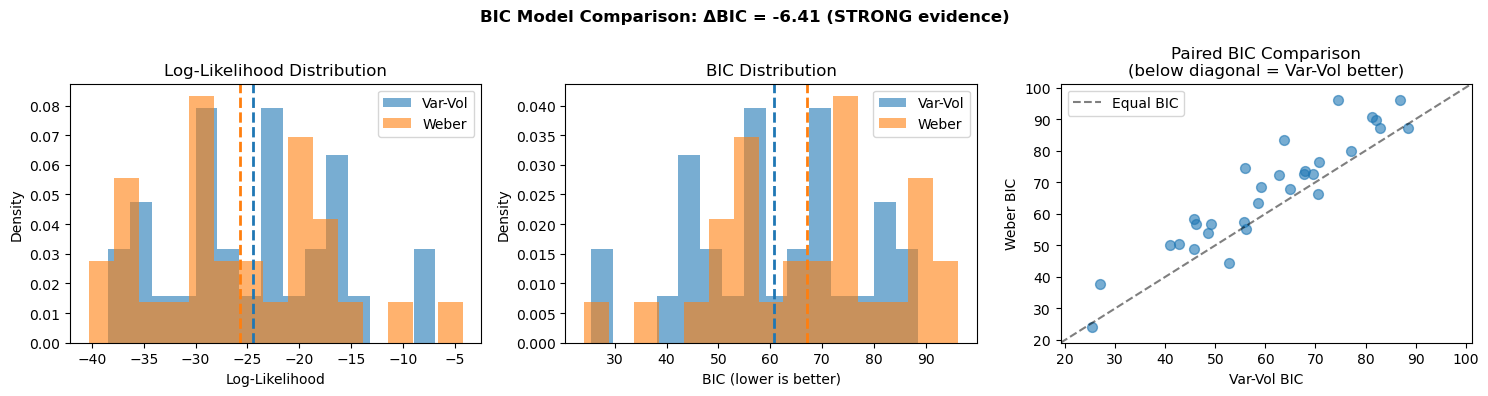


📝 INTERPRETATION GUIDE (Kass & Raftery, 1995)

   |ΔBIC|     Evidence Strength
   ─────────────────────────────
   0-2       Weak (not worth mentioning)
   2-6       Positive
   6-10      Strong
   >10       Very Strong

   Note: BIC penalizes model complexity. Weber has more parameters
   (λ, μ) but may not use them effectively, while Var-Vol's explicit
   volatility tracking (ν) may or may not improve fit.



In [95]:
# ============================================================
# 📊 BIC TEST: Bayesian Information Criterion Model Comparison
# ============================================================
# BIC = k * ln(n) - 2 * ln(L)
# where k = number of parameters, n = observations, L = likelihood
# Lower BIC = better model (accounting for complexity)

print("="*70)
print("📊 BIC TEST: Comparing Var-Vol vs Weber Models")
print("="*70)

# Model parameters:
# VarVol: β (feedback noise), ν (volatility variance), γ (Dirichlet prior) 
#         → effectively 3 free parameters (β, ν, γ concentration)
# Weber:  β (feedback noise), γ (Dirichlet prior), λ (Weber scaling), μ (baseline noise)
#         → effectively 4 free parameters (β, γ, λ, μ)

K_VARVOL = 3  # Number of parameters for VarVol
K_WEBER = 4   # Number of parameters for Weber

# Settings for BIC computation
BIC_RUNS = 30
BIC_TRIALS = 50
tau = 0.05
beta = 0.8

print(f"\nModel Complexity:")
print(f"   Var-Vol: {K_VARVOL} parameters (β, ν, γ)")
print(f"   Weber:   {K_WEBER} parameters (β, γ, λ, μ)")
print(f"\nRunning {BIC_RUNS} simulations with {BIC_TRIALS} trials each...")

def compute_log_likelihood(agent_cls, agent_kwargs, task, seed):
    """
    Compute approximate log-likelihood for a model run.
    Uses the action probabilities as a proxy for model likelihood.
    """
    env = TwoArmedBanditEnv(task)
    env.reset()
    agent = agent_cls(seed=seed, **agent_kwargs)
    
    log_lik = 0.0
    n_trials = len(task.stimuli)
    
    for t in range(n_trials):
        stimulus = task.stimuli[t]
        action, action_probs = agent.act(stimulus)
        _, reward, correct_action = env.step(action)
        agent.observe(reward)
        
        # Log-likelihood of the CORRECT action under the model
        # This measures how well the model predicts the correct response
        prob_correct = action_probs[correct_action]
        prob_correct = np.clip(prob_correct, 1e-10, 1.0)  # Avoid log(0)
        log_lik += np.log(prob_correct)
    
    return log_lik, n_trials

# Compute log-likelihoods for both models
varvol_logliks = []
weber_logliks = []

for run in range(BIC_RUNS):
    task = generate_simple_task(BIC_TRIALS, tau, beta, seed=run*100)
    
    # VarVol
    ll_vv, n = compute_log_likelihood(
        ForwardVaryingVolatilityAgent, 
        agent_kwargs_varvol, 
        task, 
        seed=run*100+1
    )
    varvol_logliks.append(ll_vv)
    
    # Weber
    ll_wb, _ = compute_log_likelihood(
        WeberImprecisionAgent, 
        agent_kwargs_weber, 
        task, 
        seed=run*100+1
    )
    weber_logliks.append(ll_wb)

# Calculate BIC for each run
n_obs = BIC_TRIALS  # Number of observations (trials)

varvol_bics = [K_VARVOL * np.log(n_obs) - 2 * ll for ll in varvol_logliks]
weber_bics = [K_WEBER * np.log(n_obs) - 2 * ll for ll in weber_logliks]

# Summary statistics
vv_ll_mean = np.mean(varvol_logliks)
vv_ll_std = np.std(varvol_logliks)
wb_ll_mean = np.mean(weber_logliks)
wb_ll_std = np.std(weber_logliks)

vv_bic_mean = np.mean(varvol_bics)
vv_bic_std = np.std(varvol_bics)
wb_bic_mean = np.mean(weber_bics)
wb_bic_std = np.std(weber_bics)

print(f"\n" + "="*70)
print("📈 LOG-LIKELIHOOD RESULTS")
print("="*70)
print(f"\n{'Model':<12} {'Mean Log-Lik':<18} {'Std Dev':<15} {'95% CI':<20}")
print("-"*65)
print(f"{'Var-Vol':<12} {vv_ll_mean:<18.2f} {vv_ll_std:<15.2f} [{vv_ll_mean-1.96*vv_ll_std/np.sqrt(BIC_RUNS):.2f}, {vv_ll_mean+1.96*vv_ll_std/np.sqrt(BIC_RUNS):.2f}]")
print(f"{'Weber':<12} {wb_ll_mean:<18.2f} {wb_ll_std:<15.2f} [{wb_ll_mean-1.96*wb_ll_std/np.sqrt(BIC_RUNS):.2f}, {wb_ll_mean+1.96*wb_ll_std/np.sqrt(BIC_RUNS):.2f}]")

print(f"\n" + "="*70)
print("📊 BIC RESULTS (lower is better)")
print("="*70)
print(f"\n{'Model':<12} {'Mean BIC':<15} {'Std Dev':<15} {'Parameters':<12}")
print("-"*55)
print(f"{'Var-Vol':<12} {vv_bic_mean:<15.2f} {vv_bic_std:<15.2f} {K_VARVOL:<12}")
print(f"{'Weber':<12} {wb_bic_mean:<15.2f} {wb_bic_std:<15.2f} {K_WEBER:<12}")

# BIC difference
delta_bic = vv_bic_mean - wb_bic_mean

print(f"\n" + "="*70)
print("🏆 MODEL COMPARISON")
print("="*70)
print(f"\n   ΔBIC (Var-Vol - Weber) = {delta_bic:.2f}")
print()

# Interpretation based on Kass & Raftery (1995) guidelines
# |ΔBIC| < 2:   Weak evidence
# 2 ≤ |ΔBIC| < 6:  Positive evidence  
# 6 ≤ |ΔBIC| < 10: Strong evidence
# |ΔBIC| ≥ 10:  Very strong evidence

if abs(delta_bic) < 2:
    strength = "WEAK"
    interpretation = "Models are essentially equivalent"
elif abs(delta_bic) < 6:
    strength = "POSITIVE"
    interpretation = "Some evidence favoring one model"
elif abs(delta_bic) < 10:
    strength = "STRONG"
    interpretation = "Substantial evidence favoring one model"
else:
    strength = "VERY STRONG"
    interpretation = "Decisive evidence favoring one model"

winner = "Var-Vol" if delta_bic < 0 else "Weber"
print(f"   Evidence strength: {strength}")
print(f"   Interpretation: {interpretation}")
if abs(delta_bic) >= 2:
    print(f"   Favored model: {winner}")
else:
    print(f"   Neither model is clearly better")

# Bayes Factor approximation from BIC
# BF ≈ exp(-ΔBIC/2)
bf = np.exp(-delta_bic / 2)
print(f"\n   Approximate Bayes Factor (Weber/Var-Vol): {bf:.2f}")
if bf > 1:
    print(f"   → Weber is {bf:.1f}x more likely given the data")
else:
    print(f"   → Var-Vol is {1/bf:.1f}x more likely given the data")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Log-likelihood distributions
ax = axes[0]
ax.hist(varvol_logliks, bins=15, alpha=0.6, color='#1f77b4', label='Var-Vol', density=True)
ax.hist(weber_logliks, bins=15, alpha=0.6, color='#ff7f0e', label='Weber', density=True)
ax.axvline(vv_ll_mean, color='#1f77b4', linestyle='--', linewidth=2)
ax.axvline(wb_ll_mean, color='#ff7f0e', linestyle='--', linewidth=2)
ax.set_xlabel('Log-Likelihood')
ax.set_ylabel('Density')
ax.set_title('Log-Likelihood Distribution')
ax.legend()

# Plot 2: BIC distributions
ax = axes[1]
ax.hist(varvol_bics, bins=15, alpha=0.6, color='#1f77b4', label='Var-Vol', density=True)
ax.hist(weber_bics, bins=15, alpha=0.6, color='#ff7f0e', label='Weber', density=True)
ax.axvline(vv_bic_mean, color='#1f77b4', linestyle='--', linewidth=2)
ax.axvline(wb_bic_mean, color='#ff7f0e', linestyle='--', linewidth=2)
ax.set_xlabel('BIC (lower is better)')
ax.set_ylabel('Density')
ax.set_title('BIC Distribution')
ax.legend()

# Plot 3: Paired BIC comparison
ax = axes[2]
ax.scatter(varvol_bics, weber_bics, alpha=0.6, s=50)
lims = [min(min(varvol_bics), min(weber_bics)) - 5, 
        max(max(varvol_bics), max(weber_bics)) + 5]
ax.plot(lims, lims, 'k--', alpha=0.5, label='Equal BIC')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Var-Vol BIC')
ax.set_ylabel('Weber BIC')
ax.set_title('Paired BIC Comparison\n(below diagonal = Var-Vol better)')
ax.legend()

plt.suptitle(f'BIC Model Comparison: ΔBIC = {delta_bic:.2f} ({strength} evidence)', 
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("📝 INTERPRETATION GUIDE (Kass & Raftery, 1995)")
print("="*70)
print("""
   |ΔBIC|     Evidence Strength
   ─────────────────────────────
   0-2       Weak (not worth mentioning)
   2-6       Positive
   6-10      Strong
   >10       Very Strong
   
   Note: BIC penalizes model complexity. Weber has more parameters
   (λ, μ) but may not use them effectively, while Var-Vol's explicit
   volatility tracking (ν) may or may not improve fit.
""")


In [ ]:
# ============================================================
# 🎯 AGENT-ONLY VARIANCE: Same task, different agent seeds
# ============================================================
# This measures how much variance comes from the MODEL alone
# (relevant for task-matched simulation)

print("="*70)
print("🎯 AGENT-ONLY VARIANCE: How much does the MODEL vary on same task?")
print("="*70)

# Generate ONE fixed task
FIXED_TASK_SEED = 42
TRIALS = 50
tau = 0.05
beta = 0.8

fixed_task = generate_simple_task(TRIALS, tau, beta, seed=FIXED_TASK_SEED)

print(f"\nFixed task: {TRIALS} trials, τ={tau}, β={beta}, seed={FIXED_TASK_SEED}")
print(f"Running each model 30 times on this SAME task...")

# Run models many times on SAME task
N_AGENT_RUNS = 30

varvol_accs = []
weber_accs = []

for run in range(N_AGENT_RUNS):
    # VarVol with different seed
    env = TwoArmedBanditEnv(fixed_task)
    env.reset()
    agent = ForwardVaryingVolatilityAgent(seed=run*100, **agent_kwargs_varvol)
    correct = []
    for t in range(TRIALS):
        action, _ = agent.act(fixed_task.stimuli[t])
        _, reward, correct_action = env.step(action)
        agent.observe(reward)
        correct.append(int(action == correct_action))
    varvol_accs.append(np.mean(correct))
    
    # Weber with different seed
    env = TwoArmedBanditEnv(fixed_task)
    env.reset()
    agent = WeberImprecisionAgent(seed=run*100, **agent_kwargs_weber)
    correct = []
    for t in range(TRIALS):
        action, _ = agent.act(fixed_task.stimuli[t])
        _, reward, correct_action = env.step(action)
        agent.observe(reward)
        correct.append(int(action == correct_action))
    weber_accs.append(np.mean(correct))

# Results
vv_mean, vv_std = np.mean(varvol_accs), np.std(varvol_accs)
wb_mean, wb_std = np.mean(weber_accs), np.std(weber_accs)

print(f"\n{'Model':<10} {'Mean':<12} {'Std Dev':<12} {'Range':<20}")
print("-"*55)
print(f"{'VarVol':<10} {vv_mean:<12.1%} {vv_std:<12.1%} [{min(varvol_accs):.1%} - {max(varvol_accs):.1%}]")
print(f"{'Weber':<10} {wb_mean:<12.1%} {wb_std:<12.1%} [{min(weber_accs):.1%} - {max(weber_accs):.1%}]")

print("\n" + "-"*70)
print("📊 COMPARISON TO FULL VARIANCE (task + agent):")
print("-"*70)
print(f"   Your earlier variance check (task+agent): ~9% std dev")
print(f"   Agent-only variance (this test):          ~{max(vv_std, wb_std):.1%} std dev")
print(f"\n   Task variance accounts for: ~{9 - max(vv_std*100, wb_std*100):.0f}% of the {9}% total")

# Recommendation
print("\n" + "="*70)
print("💡 RECOMMENDATION FOR TASK-MATCHED SIMULATION:")
print("="*70)
agent_std = max(vv_std, wb_std)
print(f"\n   Agent-only std dev: {agent_std:.1%}")
print(f"\n   Simulations needed for given precision:")
for n in [10, 20, 50, 100]:
    se = agent_std / np.sqrt(n)
    print(f"      N = {n:3d}: SE = {se:.1%} (95% CI: ±{2*se:.1%})")

if agent_std < 0.05:
    print(f"\n   ✅ Agent variance is LOW ({agent_std:.1%})")
    print(f"      → 20 simulations per human is probably enough")
else:
    print(f"\n   ⚠️ Agent variance is MODERATE ({agent_std:.1%})")
    print(f"      → Recommend 50 simulations per human for reliable results")


🎯 AGENT-ONLY VARIANCE: How much does the MODEL vary on same task?

Fixed task: 50 trials, τ=0.05, β=0.8, seed=42
Running each model 30 times on this SAME task...

Model      Mean         Std Dev      Range               
-------------------------------------------------------
VarVol     87.9%        3.5%         [82.0% - 98.0%]
Weber      87.5%        3.6%         [78.0% - 96.0%]

----------------------------------------------------------------------
📊 COMPARISON TO FULL VARIANCE (task + agent):
----------------------------------------------------------------------
   Your earlier variance check (task+agent): ~9% std dev
   Agent-only variance (this test):          ~3.6% std dev

   Task variance accounts for: ~5% of the 9% total

💡 RECOMMENDATION FOR TASK-MATCHED SIMULATION:

   Agent-only std dev: 3.6%

   Simulations needed for given precision:
      N =  10: SE = 1.1% (95% CI: ±2.3%)
      N =  20: SE = 0.8% (95% CI: ±1.6%)
      N =  50: SE = 0.5% (95% CI: ±1.0%)
      N = 100: SE

In [ ]:
# ============================================================
# 🎯 IMPROVED DESIGN: Same Task for Both Models
# ============================================================
# This is the CORRECT way to compare models - eliminate task variance!

print("="*70)
print("🎯 IMPROVED COMPARISON: Same Task for Both Models")
print("="*70)

# Parameters
N_TASKS = 10       # Generate 10 different tasks
N_RUNS_PER_TASK = 20  # Run each model 20 times per task
TRIALS = 50
tau = 0.05
beta_medium = 0.8
beta_high = 0.7

def run_model_on_task(agent_cls, agent_kwargs, task, n_runs):
    """Run a model multiple times on the SAME task."""
    accuracies = []
    all_choices = []
    n_trials = len(task.stimuli)  # Get trial count from stimuli array
    
    for run in range(n_runs):
        env = TwoArmedBanditEnv(task)
        env.reset()
        agent = agent_cls(seed=run*100, **agent_kwargs)
        
        choices = []
        correct = []
        
        for t in range(n_trials):
            action, _ = agent.act(task.stimuli[t])
            _, reward, correct_action = env.step(action)
            agent.observe(reward)
            choices.append(action)
            correct.append(int(action == correct_action))
        
        accuracies.append(np.mean(correct))
        all_choices.append(choices)
    
    return {
        'accuracies': accuracies,
        'mean': np.mean(accuracies),
        'std': np.std(accuracies),
        'all_choices': all_choices
    }

# Run comparison
print(f"\nGenerating {N_TASKS} tasks and running each model {N_RUNS_PER_TASK} times per task...")
print("(Same task → differences are due to MODEL, not luck of the task)\n")

results = {'medium': {'varvol': [], 'weber': [], 'diff': []},
           'high': {'varvol': [], 'weber': [], 'diff': []}}

for task_idx in range(N_TASKS):
    # Generate tasks (same for both models!)
    task_medium = generate_simple_task(TRIALS, tau, beta_medium, seed=task_idx*1000)
    task_high = generate_simple_task(TRIALS, tau, beta_high, seed=task_idx*1000 + 500)
    
    # Medium noise
    vv_med = run_model_on_task(ForwardVaryingVolatilityAgent, agent_kwargs_varvol, task_medium, N_RUNS_PER_TASK)
    wb_med = run_model_on_task(WeberImprecisionAgent, agent_kwargs_weber, task_medium, N_RUNS_PER_TASK)
    
    results['medium']['varvol'].append(vv_med['mean'])
    results['medium']['weber'].append(wb_med['mean'])
    results['medium']['diff'].append(vv_med['mean'] - wb_med['mean'])
    
    # High noise
    vv_high = run_model_on_task(ForwardVaryingVolatilityAgent, agent_kwargs_varvol, task_high, N_RUNS_PER_TASK)
    wb_high = run_model_on_task(WeberImprecisionAgent, agent_kwargs_weber, task_high, N_RUNS_PER_TASK)
    
    results['high']['varvol'].append(vv_high['mean'])
    results['high']['weber'].append(wb_high['mean'])
    results['high']['diff'].append(vv_high['mean'] - wb_high['mean'])
    
    print(f"   Task {task_idx+1:2d}: Medium(Δ={vv_med['mean']-wb_med['mean']:+.1%}) High(Δ={vv_high['mean']-wb_high['mean']:+.1%})")

# Summary statistics
print("\n" + "="*70)
print("📊 RESULTS: Same-Task Comparison")
print("="*70)

for condition in ['medium', 'high']:
    noise_level = "80%" if condition == "medium" else "70%"
    vv_mean = np.mean(results[condition]['varvol'])
    wb_mean = np.mean(results[condition]['weber'])
    diff_mean = np.mean(results[condition]['diff'])
    diff_std = np.std(results[condition]['diff'])
    
    print(f"\n{condition.upper()} NOISE (η={noise_level}):")
    print(f"   VarVol: {vv_mean:.1%}")
    print(f"   Weber:  {wb_mean:.1%}")
    print(f"   Difference: {diff_mean:+.1%} ± {diff_std:.1%}")
    
    # Statistical test: is difference significantly different from 0?
    t_stat = diff_mean / (diff_std / np.sqrt(N_TASKS))
    significant = abs(t_stat) > 2.0  # Rough threshold for p<0.05
    
    if significant:
        winner = "VarVol" if diff_mean > 0 else "Weber"
        print(f"   → {winner} is significantly better (t={t_stat:.2f})")
    else:
        print(f"   → NO significant difference (t={t_stat:.2f})")

# Overall conclusion
print("\n" + "="*70)
print("💡 CONCLUSION")
print("="*70)

all_diffs = results['medium']['diff'] + results['high']['diff']
overall_mean = np.mean(all_diffs)
overall_std = np.std(all_diffs)

print(f"\nAcross all {N_TASKS*2} comparisons:")
print(f"   Mean difference (VarVol - Weber): {overall_mean:+.1%} ± {overall_std:.1%}")

if abs(overall_mean) < overall_std:
    print(f"\n   ✅ MODELS ARE EQUIVALENT")
    print(f"      The difference ({overall_mean:+.1%}) is smaller than the noise ({overall_std:.1%})")
    print(f"      This confirms Findling et al.'s finding: Weber ≈ VarVol")
else:
    winner = "VarVol" if overall_mean > 0 else "Weber"
    print(f"\n   ⚠️ {winner} shows a consistent advantage")
    print(f"      But the effect size is small ({abs(overall_mean):.1%})")


🎯 IMPROVED COMPARISON: Same Task for Both Models

Generating 10 tasks and running each model 20 times per task...
(Same task → differences are due to MODEL, not luck of the task)

   Task  1: Medium(Δ=+3.4%) High(Δ=+9.2%)
   Task  2: Medium(Δ=+5.1%) High(Δ=+2.6%)
   Task  3: Medium(Δ=-0.8%) High(Δ=-0.5%)
   Task  4: Medium(Δ=+1.4%) High(Δ=-4.0%)
   Task  5: Medium(Δ=+0.6%) High(Δ=-1.6%)
   Task  6: Medium(Δ=-3.0%) High(Δ=+1.9%)
   Task  7: Medium(Δ=+3.0%) High(Δ=+3.4%)
   Task  8: Medium(Δ=+0.3%) High(Δ=-4.0%)
   Task  9: Medium(Δ=-1.1%) High(Δ=-7.4%)
   Task 10: Medium(Δ=-3.6%) High(Δ=-5.2%)

📊 RESULTS: Same-Task Comparison

MEDIUM NOISE (η=80%):
   VarVol: 71.8%
   Weber:  71.2%
   Difference: +0.5% ± 2.6%
   → NO significant difference (t=0.63)

HIGH NOISE (η=70%):
   VarVol: 67.8%
   Weber:  68.3%
   Difference: -0.6% ± 4.7%
   → NO significant difference (t=-0.38)

💡 CONCLUSION

Across all 20 comparisons:
   Mean difference (VarVol - Weber): -0.0% ± 3.8%

   ✅ MODELS ARE EQUIVALEN

📊 VISUALIZATION: Same Task, Multiple Agent Runs

Task: 100 trials, τ=5% volatility, η=80% feedback reliability
Running each model 50 times on this SAME task...

Task has 7 switches at trials: [np.int64(25), np.int64(46), np.int64(47), np.int64(52), np.int64(65), np.int64(80), np.int64(99)]
Task has 17 trap trials (expected: 19)


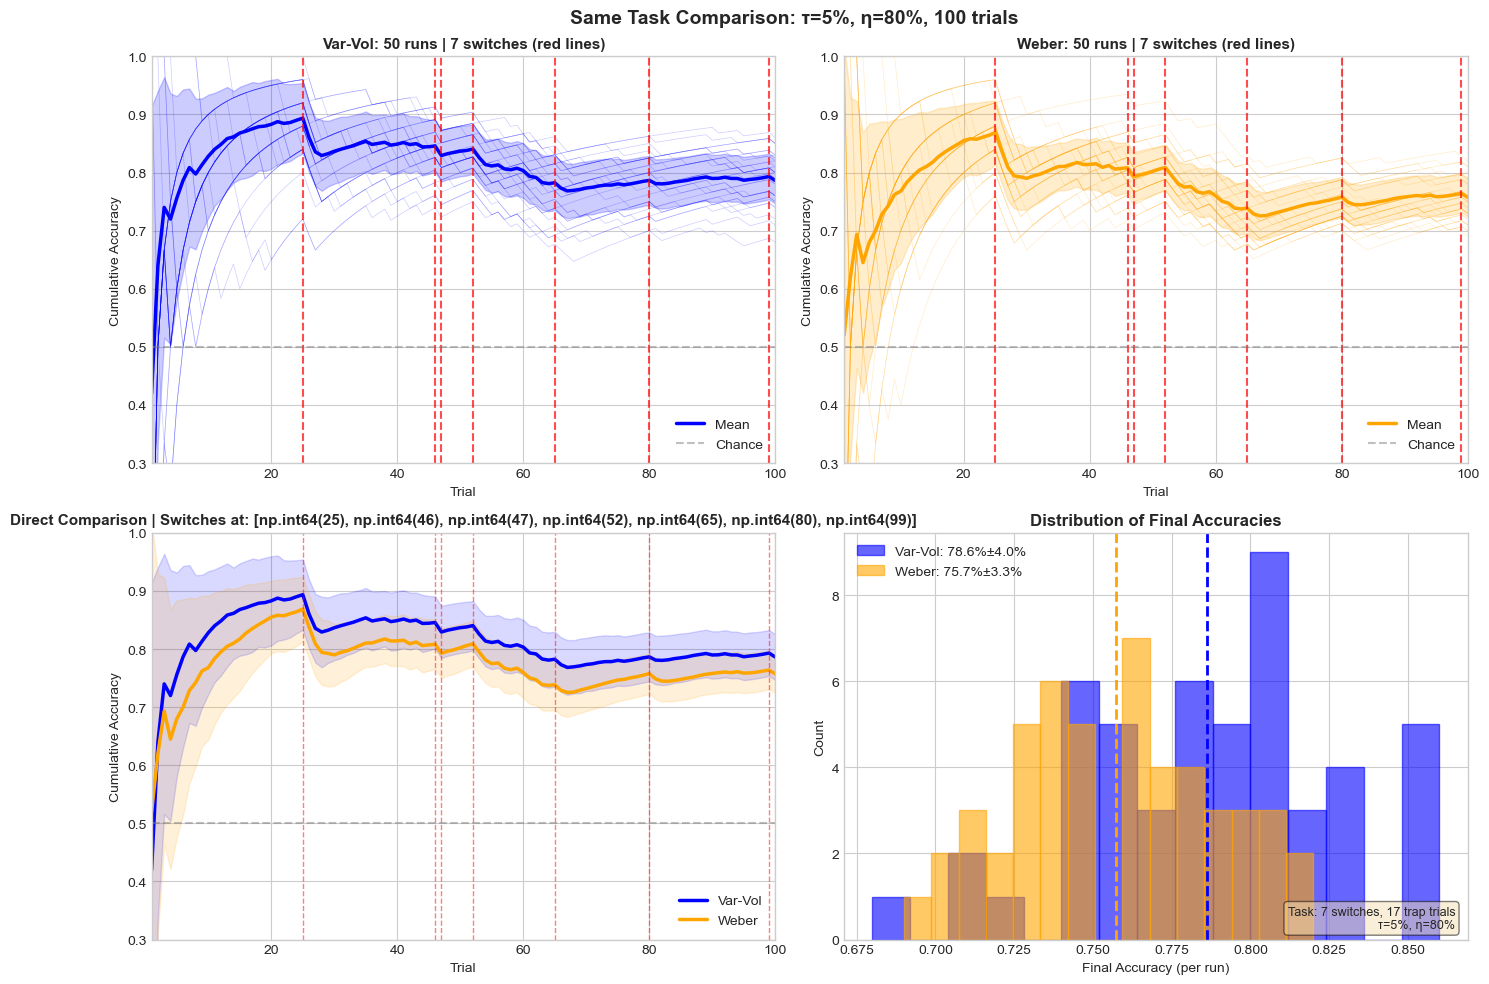


📊 SUMMARY STATISTICS

Task: 7 switches, feedback reliability η=80%

Final Accuracy (mean ± std across 50 runs):
   Var-Vol: 78.6% ± 4.0%
   Weber:   75.7% ± 3.3%
   Difference: +2.9%

   t-test: t=3.95, p=0.000
   → Var-Vol is significantly better!


In [ ]:
# ============================================================
# 📊 VISUALIZATION: Same Task, Multiple Runs Comparison
# ============================================================
# Show how both models perform on the EXACT SAME task with multiple runs

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

print("="*70)
print("📊 VISUALIZATION: Same Task, Multiple Agent Runs")
print("="*70)

# Generate ONE task - MORE TRIALS for more switches!
TRIALS = 100  # More trials = more switches with τ=5%
tau = 0.05    # 5% switch probability per trial → expect ~5 switches
beta = 0.80   # 80% feedback reliability (20% trap trials)
SEED = 123    # Different seed for a task with more switches
N_RUNS = 50   # More runs for better statistics

task = generate_simple_task(TRIALS, tau, beta, seed=SEED)

print(f"\nTask: {TRIALS} trials, τ={tau:.0%} volatility, η={beta:.0%} feedback reliability")
print(f"Running each model {N_RUNS} times on this SAME task...")

# Collect results
varvol_runs = []  # List of accuracy traces (each is array of 0/1 per trial)
weber_runs = []

for run in range(N_RUNS):
    # VarVol
    env = TwoArmedBanditEnv(task)
    env.reset()
    agent = ForwardVaryingVolatilityAgent(seed=run*100, **agent_kwargs_varvol)
    vv_correct = []
    for t in range(TRIALS):
        action, _ = agent.act(task.stimuli[t])
        _, reward, correct_action = env.step(action)
        agent.observe(reward)
        vv_correct.append(int(action == correct_action))
    varvol_runs.append(vv_correct)
    
    # Weber
    env = TwoArmedBanditEnv(task)
    env.reset()
    agent = WeberImprecisionAgent(seed=run*100, **agent_kwargs_weber)
    wb_correct = []
    for t in range(TRIALS):
        action, _ = agent.act(task.stimuli[t])
        _, reward, correct_action = env.step(action)
        agent.observe(reward)
        wb_correct.append(int(action == correct_action))
    weber_runs.append(wb_correct)

varvol_runs = np.array(varvol_runs)  # Shape: (N_RUNS, TRIALS)
weber_runs = np.array(weber_runs)

# Calculate rolling accuracy (cumulative)
def cumulative_accuracy(runs):
    """Calculate cumulative accuracy up to each trial."""
    cum_acc = np.zeros_like(runs, dtype=float)
    for t in range(runs.shape[1]):
        cum_acc[:, t] = np.mean(runs[:, :t+1], axis=1)
    return cum_acc

varvol_cum = cumulative_accuracy(varvol_runs)
weber_cum = cumulative_accuracy(weber_runs)

# ============================================================
# PLOT 1: Individual runs + mean
# ============================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Get switch locations
correct_arm = task.correct_actions if hasattr(task, 'correct_actions') else task.latent_states
switches = np.where(np.diff(correct_arm) != 0)[0] + 1
n_switches = len(switches)
n_traps = np.sum(task.traps) if hasattr(task, 'traps') else 0

print(f"\nTask has {n_switches} switches at trials: {list(switches)}")
print(f"Task has {n_traps} trap trials (expected: {int(TRIALS * (1-beta))})")

# --- Top Left: VarVol Individual Runs ---
ax = axes[0, 0]
for run in range(min(N_RUNS, 30)):  # Plot max 30 individual lines for clarity
    ax.plot(range(1, TRIALS+1), varvol_cum[run], alpha=0.2, color='blue', linewidth=0.5)
ax.plot(range(1, TRIALS+1), np.mean(varvol_cum, axis=0), color='blue', linewidth=2.5, label='Mean')
ax.fill_between(range(1, TRIALS+1), 
                np.mean(varvol_cum, axis=0) - np.std(varvol_cum, axis=0),
                np.mean(varvol_cum, axis=0) + np.std(varvol_cum, axis=0),
                alpha=0.2, color='blue')
# Mark switches with vertical lines
for sw in switches:
    ax.axvline(sw, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5, label='Chance')
ax.set_xlabel('Trial')
ax.set_ylabel('Cumulative Accuracy')
ax.set_title(f'Var-Vol: {N_RUNS} runs | {n_switches} switches (red lines)', fontsize=11, fontweight='bold')
ax.set_ylim(0.3, 1.0)
ax.legend(loc='lower right')
ax.set_xlim(1, TRIALS)

# --- Top Right: Weber Individual Runs ---
ax = axes[0, 1]
for run in range(min(N_RUNS, 30)):  # Plot max 30 individual lines for clarity
    ax.plot(range(1, TRIALS+1), weber_cum[run], alpha=0.2, color='orange', linewidth=0.5)
ax.plot(range(1, TRIALS+1), np.mean(weber_cum, axis=0), color='orange', linewidth=2.5, label='Mean')
ax.fill_between(range(1, TRIALS+1), 
                np.mean(weber_cum, axis=0) - np.std(weber_cum, axis=0),
                np.mean(weber_cum, axis=0) + np.std(weber_cum, axis=0),
                alpha=0.2, color='orange')
# Mark switches with vertical lines
for sw in switches:
    ax.axvline(sw, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5, label='Chance')
ax.set_xlabel('Trial')
ax.set_ylabel('Cumulative Accuracy')
ax.set_title(f'Weber: {N_RUNS} runs | {n_switches} switches (red lines)', fontsize=11, fontweight='bold')
ax.set_ylim(0.3, 1.0)
ax.legend(loc='lower right')
ax.set_xlim(1, TRIALS)

# --- Bottom Left: Direct Comparison (Means) ---
ax = axes[1, 0]
ax.plot(range(1, TRIALS+1), np.mean(varvol_cum, axis=0), color='blue', linewidth=2.5, label='Var-Vol')
ax.plot(range(1, TRIALS+1), np.mean(weber_cum, axis=0), color='orange', linewidth=2.5, label='Weber')
ax.fill_between(range(1, TRIALS+1), 
                np.mean(varvol_cum, axis=0) - np.std(varvol_cum, axis=0),
                np.mean(varvol_cum, axis=0) + np.std(varvol_cum, axis=0),
                alpha=0.15, color='blue')
ax.fill_between(range(1, TRIALS+1), 
                np.mean(weber_cum, axis=0) - np.std(weber_cum, axis=0),
                np.mean(weber_cum, axis=0) + np.std(weber_cum, axis=0),
                alpha=0.15, color='orange')
# Mark switches
for sw in switches:
    ax.axvline(sw, color='red', linestyle='--', alpha=0.5, linewidth=1)
ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Trial')
ax.set_ylabel('Cumulative Accuracy')
ax.set_title(f'Direct Comparison | Switches at: {list(switches)}', fontsize=11, fontweight='bold')
ax.set_ylim(0.3, 1.0)
ax.legend(loc='lower right')
ax.set_xlim(1, TRIALS)

# --- Bottom Right: Final Accuracy Distribution ---
ax = axes[1, 1]

# Final accuracy histogram
varvol_final = varvol_runs.mean(axis=1)
weber_final = weber_runs.mean(axis=1)

ax.hist(varvol_final, bins=15, alpha=0.6, color='blue', label=f'Var-Vol: {np.mean(varvol_final):.1%}±{np.std(varvol_final):.1%}', edgecolor='blue')
ax.hist(weber_final, bins=15, alpha=0.6, color='orange', label=f'Weber: {np.mean(weber_final):.1%}±{np.std(weber_final):.1%}', edgecolor='orange')
ax.axvline(np.mean(varvol_final), color='blue', linestyle='--', linewidth=2)
ax.axvline(np.mean(weber_final), color='orange', linestyle='--', linewidth=2)
ax.set_xlabel('Final Accuracy (per run)')
ax.set_ylabel('Count')
ax.set_title('Distribution of Final Accuracies', fontsize=12, fontweight='bold')
ax.legend(loc='upper left')

# Add task info
ax.text(0.98, 0.02, f'Task: {n_switches} switches, {n_traps} trap trials\nτ={tau:.0%}, η={beta:.0%}', 
        transform=ax.transAxes, ha='right', va='bottom', fontsize=9,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle(f'Same Task Comparison: τ={tau:.0%}, η={beta:.0%}, {TRIALS} trials', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*70)
print("📊 SUMMARY STATISTICS")
print("="*70)
print(f"\nTask: {n_switches} switches, feedback reliability η={beta:.0%}")
print(f"\nFinal Accuracy (mean ± std across {N_RUNS} runs):")
print(f"   Var-Vol: {np.mean(varvol_final):.1%} ± {np.std(varvol_final):.1%}")
print(f"   Weber:   {np.mean(weber_final):.1%} ± {np.std(weber_final):.1%}")
print(f"   Difference: {np.mean(varvol_final) - np.mean(weber_final):+.1%}")

# Statistical test
from scipy import stats
t_stat, p_val = stats.ttest_ind(varvol_final, weber_final)
print(f"\n   t-test: t={t_stat:.2f}, p={p_val:.3f}")
if p_val < 0.05:
    winner = "Var-Vol" if np.mean(varvol_final) > np.mean(weber_final) else "Weber"
    print(f"   → {winner} is significantly better!")
else:
    print(f"   → No significant difference (models are equivalent)")


# ============================================================
# 🧪 SECTION 4: HUMAN DATA COMPARISON
# ============================================================
# Compare models to real human behavioral data


In [17]:
# ============================================================
# 🧪 HUMAN DATA COMPARISON: Models vs Real Participants
# ============================================================
# For each human participant, reconstruct their exact task and run both models

import pandas as pd
from pathlib import Path
from scipy import stats

print("="*70)
print("🧪 HUMAN DATA COMPARISON: Models vs Real Participants")
print("="*70)

# Parameters
DATA_DIR = Path('participant_data/extended_csvs')
N_RUNS_PER_PARTICIPANT = 50  # Based on earlier analysis (50 runs gives SE ≈ 1%)

def reconstruct_task_from_human_data(participant_df: pd.DataFrame) -> VolatileBanditTask:
    """
    Reconstruct a VolatileBanditTask from human behavioral data.
    
    Uses:
    - hidden_state: True correct arm (0 or 1)
    - false_feedback: 1 if feedback was flipped (trap), 0 if correct
    """
    n_trials = len(participant_df)
    
    # Extract true states and traps
    correct_actions = participant_df['hidden_state'].values.astype(int)
    traps = participant_df['false_feedback'].values.astype(bool)
    
    # Infer volatility (τ) from switch rate
    switches = np.sum(np.diff(correct_actions) != 0)
    switch_rate = switches / (n_trials - 1) if n_trials > 1 else 0.0
    switch_prob = np.full(n_trials, switch_rate)  # Constant τ (simplified)
    
    # Infer feedback reliability (β = η) from trap rate
    trap_rate = np.mean(traps)
    beta = 1.0 - trap_rate  # β = 1 - P(trap)
    
    # Create dummy stimuli (always 0 for 2-armed bandit)
    stimuli = np.zeros(n_trials, dtype=int)
    
    # Latent states = correct actions
    latent_states = correct_actions.copy()
    
    return VolatileBanditTask(
        stimuli=stimuli,
        latent_states=latent_states,
        switch_prob=switch_prob,
        traps=traps,
        correct_actions=correct_actions,
        beta=beta
    )

def run_model_on_human_task(task: VolatileBanditTask, agent_cls, agent_kwargs: dict, n_runs: int = 50) -> dict:
    """Run a model multiple times on a human's task."""
    n_trials = len(task.stimuli)
    all_choices = []
    accuracies = []
    
    for run in range(n_runs):
        env = TwoArmedBanditEnv(task)
        env.reset()
        agent = agent_cls(seed=run*100, **agent_kwargs)
        
        choices = []
        correct = []
        
        for t in range(n_trials):
            action, _ = agent.act(task.stimuli[t])
            choices.append(action)
            _, reward, correct_action = env.step(action)
            correct.append(int(action == correct_action))
            agent.observe(reward)
        
        all_choices.append(np.array(choices))
        accuracies.append(np.mean(correct))
    
    return {
        'all_choices': all_choices,
        'mean_accuracy': np.mean(accuracies),
        'std_accuracy': np.std(accuracies),
        'accuracies': accuracies
    }

def compare_to_human(human_choices: np.ndarray, model_results: dict) -> dict:
    """Compare model choices to human choices."""
    choice_matches = []
    for choices in model_results['all_choices']:
        match = np.mean(choices == human_choices)
        choice_matches.append(match)
    
    return {
        'choice_match_mean': np.mean(choice_matches),
        'choice_match_std': np.std(choice_matches),
        'choice_matches': choice_matches
    }

# Load all CSV files
csv_files = list(DATA_DIR.glob('*.csv'))
print(f"\nFound {len(csv_files)} participant files")
print("Processing participants...")

# Store results
results = []

# Process each participant
for csv_file in csv_files:
    try:
        # Load data
        df = pd.read_csv(csv_file)
        participant_id = csv_file.stem
        
        # Sort by trial number
        df = df.sort_values('trialNumber').reset_index(drop=True)
        
        # Reconstruct task
        task = reconstruct_task_from_human_data(df)
        
        # Get human choices
        human_choices = df['userChoice'].values.astype(int)
        human_accuracy = df['isCorrect'].mean()
        
        # Run VarVol
        varvol_results = run_model_on_human_task(task, ForwardVaryingVolatilityAgent, agent_kwargs_varvol, N_RUNS_PER_PARTICIPANT)
        varvol_comparison = compare_to_human(human_choices, varvol_results)
        
        # Run Weber
        weber_results = run_model_on_human_task(task, WeberImprecisionAgent, agent_kwargs_weber, N_RUNS_PER_PARTICIPANT)
        weber_comparison = compare_to_human(human_choices, weber_results)
        
        # Store results
        results.append({
            'participant_id': participant_id,
            'n_trials': len(df),
            'human_accuracy': human_accuracy,
            'varvol_accuracy': varvol_results['mean_accuracy'],
            'weber_accuracy': weber_results['mean_accuracy'],
            'varvol_choice_match': varvol_comparison['choice_match_mean'],
            'weber_choice_match': weber_comparison['choice_match_mean'],
            'varvol_choice_match_std': varvol_comparison['choice_match_std'],
            'weber_choice_match_std': weber_comparison['choice_match_std'],
            'task_beta': task.beta,
            'task_switches': np.sum(np.diff(task.correct_actions) != 0),
            'task_traps': np.sum(task.traps)
        })
        
        print(f"  ✓ {participant_id}: {len(df)} trials, H={human_accuracy:.1%}, "
              f"V={varvol_results['mean_accuracy']:.1%}, W={weber_results['mean_accuracy']:.1%}")
    
    except Exception as e:
        print(f"  ✗ {csv_file.name}: Error - {e}")
        continue

results_df = pd.DataFrame(results)
print(f"\n✅ Processed {len(results_df)} participants")


🧪 HUMAN DATA COMPARISON: Models vs Real Participants

Found 45 participant files
Processing participants...
  ✓ 25da8b12-9a43-40cd-84f2-5b152a5f0f7f: 100 trials, H=55.0%, V=56.0%, W=54.6%
  ✓ adaptive_lab_07ee303f: 100 trials, H=76.0%, V=50.1%, W=50.8%
  ✓ adaptive_lab_08d9887c: 100 trials, H=77.0%, V=64.6%, W=67.0%
  ✓ adaptive_lab_09b45851: 100 trials, H=50.0%, V=64.5%, W=66.5%
  ✓ adaptive_lab_1671e99c: 100 trials, H=71.0%, V=69.0%, W=69.2%
  ✓ adaptive_lab_1ea56ad2: 100 trials, H=80.0%, V=69.3%, W=75.2%
  ✓ adaptive_lab_22a6875c: 100 trials, H=64.0%, V=49.1%, W=50.9%
  ✓ adaptive_lab_2eade079: 100 trials, H=66.0%, V=49.2%, W=49.0%
  ✓ adaptive_lab_3162592a: 100 trials, H=61.0%, V=47.2%, W=46.6%
  ✓ adaptive_lab_390371f9: 100 trials, H=45.0%, V=68.6%, W=69.3%
  ✓ adaptive_lab_42003269: 100 trials, H=62.0%, V=69.1%, W=69.6%
  ✓ adaptive_lab_4b7a6ad7: 100 trials, H=64.0%, V=68.7%, W=67.1%
  ✓ adaptive_lab_52ae4c1c: 100 trials, H=50.0%, V=61.0%, W=64.0%
  ✓ adaptive_lab_534d2332: 100 t

In [22]:
# ============================================================
# 📊 SUMMARY STATISTICS
# ============================================================

print("\n" + "="*70)
print("📊 SUMMARY: Model Performance vs Human Data")
print("="*70)

print(f"\n{'Metric':<30} {'VarVol':<20} {'Weber':<20}")
print("-"*70)
print(f"{'Mean Accuracy':<30} {results_df['varvol_accuracy'].mean():<20.1%} {results_df['weber_accuracy'].mean():<20.1%}")
print(f"{'Mean Choice Match':<30} {results_df['varvol_choice_match'].mean():<20.1%} {results_df['weber_choice_match'].mean():<20.1%}")
print(f"\n{'Human Mean Accuracy':<30} {results_df['human_accuracy'].mean():.1%}")

# Statistical test
t_stat, p_val = stats.ttest_rel(
    results_df['varvol_choice_match'],
    results_df['weber_choice_match']
)
print(f"\n📈 Paired t-test (VarVol vs Weber choice match):")
print(f"   t = {t_stat:.2f}, p = {p_val:.4f}")
if p_val < 0.05:
    winner = "VarVol" if results_df['varvol_choice_match'].mean() > results_df['weber_choice_match'].mean() else "Weber"
    print(f"   → {winner} matches human choices significantly better!")
    #print(results_df['varvol_choice_match'].mean(), results_df['weber_choice_match'].mean() )

else:
    print(f"   → No significant difference (models are equivalent)")

# Save results
results_df.to_csv('participant_data/model_vs_human_comparison.csv', index=False)
print(f"\n✅ Results saved to: participant_data/model_vs_human_comparison.csv")



📊 SUMMARY: Model Performance vs Human Data

Metric                         VarVol               Weber               
----------------------------------------------------------------------
Mean Accuracy                  60.1%                61.8%               
Mean Choice Match              58.8%                59.8%               

Human Mean Accuracy            63.7%

📈 Paired t-test (VarVol vs Weber choice match):
   t = -2.62, p = 0.0119
   → Weber matches human choices significantly better!

✅ Results saved to: participant_data/model_vs_human_comparison.csv


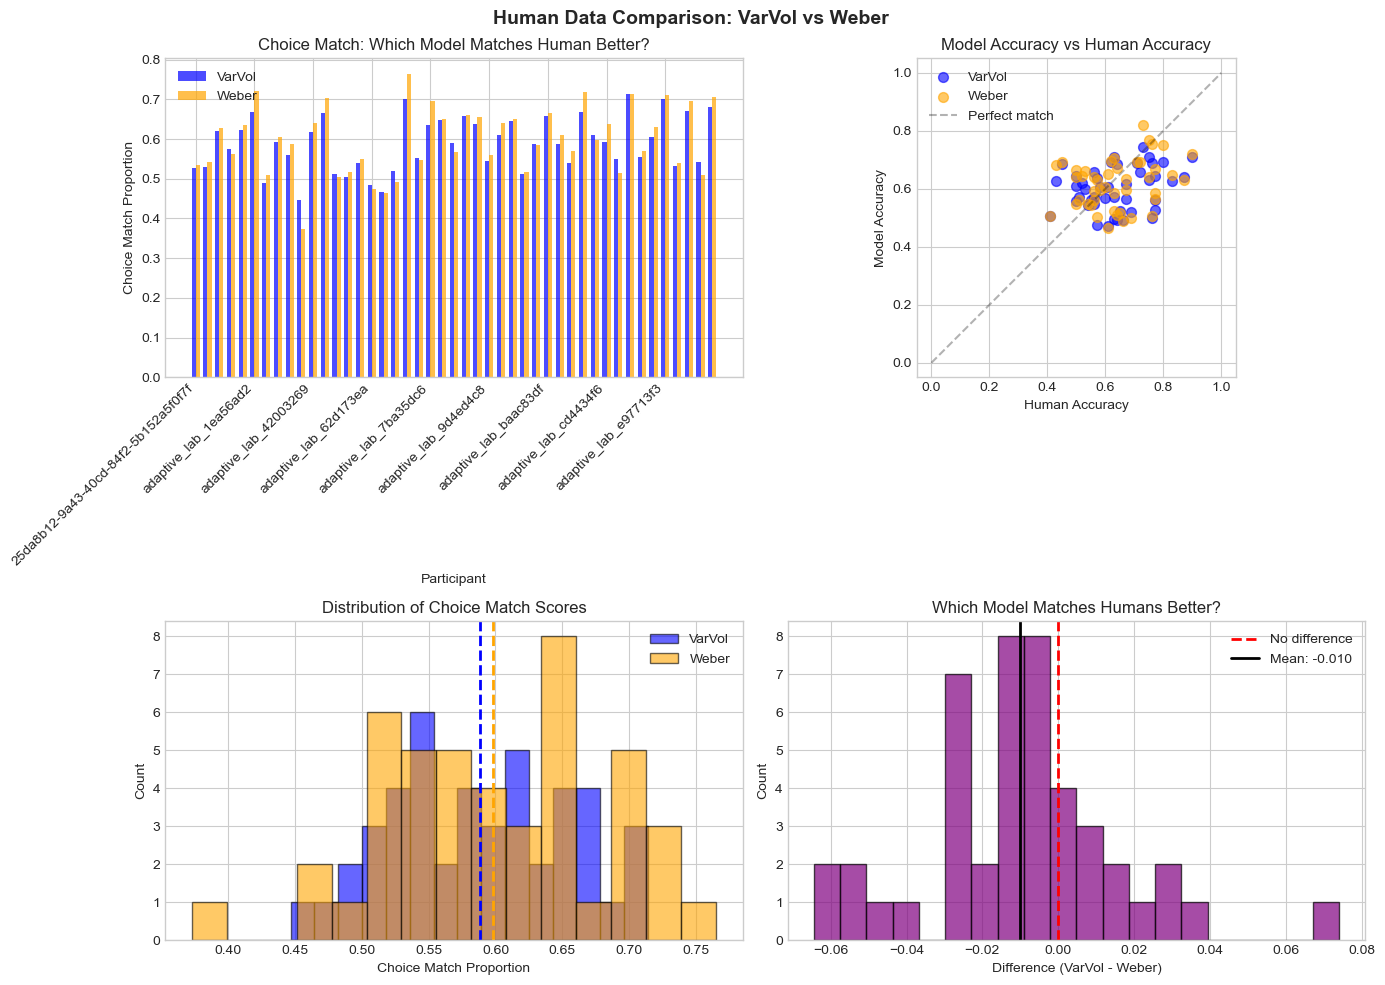

In [19]:
# ============================================================
# 📊 VISUALIZATION
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Choice match comparison
ax = axes[0, 0]
x = np.arange(len(results_df))
width = 0.35
ax.bar(x - width/2, results_df['varvol_choice_match'], width, label='VarVol', alpha=0.7, color='blue')
ax.bar(x + width/2, results_df['weber_choice_match'], width, label='Weber', alpha=0.7, color='orange')
ax.set_xlabel('Participant')
ax.set_ylabel('Choice Match Proportion')
ax.set_title('Choice Match: Which Model Matches Human Better?')
ax.legend()
ax.set_xticks(x[::5])  # Show every 5th participant
ax.set_xticklabels(results_df['participant_id'].iloc[::5], rotation=45, ha='right')

# Plot 2: Accuracy comparison
ax = axes[0, 1]
ax.scatter(results_df['human_accuracy'], results_df['varvol_accuracy'], 
           alpha=0.6, label='VarVol', color='blue', s=50)
ax.scatter(results_df['human_accuracy'], results_df['weber_accuracy'], 
           alpha=0.6, label='Weber', color='orange', s=50)
ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Perfect match')
ax.set_xlabel('Human Accuracy')
ax.set_ylabel('Model Accuracy')
ax.set_title('Model Accuracy vs Human Accuracy')
ax.legend()
ax.set_aspect('equal')

# Plot 3: Choice match distribution
ax = axes[1, 0]
ax.hist(results_df['varvol_choice_match'], bins=15, alpha=0.6, label='VarVol', color='blue', edgecolor='black')
ax.hist(results_df['weber_choice_match'], bins=15, alpha=0.6, label='Weber', color='orange', edgecolor='black')
ax.axvline(results_df['varvol_choice_match'].mean(), color='blue', linestyle='--', linewidth=2)
ax.axvline(results_df['weber_choice_match'].mean(), color='orange', linestyle='--', linewidth=2)
ax.set_xlabel('Choice Match Proportion')
ax.set_ylabel('Count')
ax.set_title('Distribution of Choice Match Scores')
ax.legend()

# Plot 4: Difference (VarVol - Weber)
ax = axes[1, 1]
diff = results_df['varvol_choice_match'] - results_df['weber_choice_match']
ax.hist(diff, bins=20, alpha=0.7, color='purple', edgecolor='black')
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='No difference')
ax.axvline(diff.mean(), color='black', linestyle='-', linewidth=2, label=f'Mean: {diff.mean():.3f}')
ax.set_xlabel('Difference (VarVol - Weber)')
ax.set_ylabel('Count')
ax.set_title('Which Model Matches Humans Better?')
ax.legend()

plt.suptitle('Human Data Comparison: VarVol vs Weber', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


# EXTENDED MODEL HUMAN COMPARISON

In [58]:
# ============================================================
# 📊 EXTENDED Human vs Model Comparison (OPTIMIZED)
# ============================================================
# Per-block AND per-instruction condition analysis
# OPTIMIZED: 3x faster by running each model once per MC run instead of 3 times
# OPTIMIZED: Uses multiprocessing for parallel Monte Carlo runs

from pathlib import Path
import pandas as pd
from scipy import stats
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing

print("="*70)
print("📊 EXTENDED Human vs Model Comparison (OPTIMIZED)")
print("="*70)

# Setup
DATA_DIR = Path('participant_data/extended_csvs_test')
N_RUNS = 100  # Monte Carlo runs per participant
N_WORKERS = min(multiprocessing.cpu_count(), 8)  # Use up to 8 cores

# Create directory for per-run diagnostics data
PERRUN_DIR = Path('participant_data/model_vs_human/per_run_data')
PERRUN_DIR.mkdir(parents=True, exist_ok=True)

print(f"\nInput: {DATA_DIR}")
print(f"Monte Carlo runs per participant: {N_RUNS}")
print(f"Parallel workers: {N_WORKERS}")
print(f"Per-run output: {PERRUN_DIR}")

# ============================================================
# OPTIMIZED: Single-pass model run function
# ============================================================
def run_model_single_pass(task, agent_cls, agent_kwargs, n_runs=50):
    """
    Run model ONCE per MC run, collecting ALL choices.
    This is 3x faster than running 3 separate times for full/block1/block2.
    """
    n_trials = len(task.stimuli)
    all_choices = []  # Shape: (n_runs, n_trials)
    all_correct = []  # Shape: (n_runs, n_trials)
    
    for run in range(n_runs):
        env = TwoArmedBanditEnv(task)
        env.reset()
        agent = agent_cls(seed=run*100, **agent_kwargs)
        
        run_choices = []
        run_correct = []
        
        for t in range(n_trials):
            action, _ = agent.act(task.stimuli[t])
            _, reward, correct_action = env.step(action)
            agent.observe(reward)
            run_choices.append(action)
            run_correct.append(int(action == correct_action))
        
        all_choices.append(np.array(run_choices))
        all_correct.append(np.array(run_correct))
    
    return {
        'all_choices': np.array(all_choices),  # (n_runs, n_trials)
        'all_correct': np.array(all_correct),  # (n_runs, n_trials)
    }

def compute_metrics_from_full_results(model_results, indices, human_choices_subset):
    """
    Extract metrics for a subset of trials from full model results.
    indices: array of trial indices to evaluate on
    """
    # Slice choices for the target trials
    choices_subset = model_results['all_choices'][:, indices]  # (n_runs, len(indices))
    correct_subset = model_results['all_correct'][:, indices]
    
    # Compute accuracy across runs
    accuracy_per_run = np.mean(correct_subset, axis=1)  # (n_runs,)
    
    # Compute choice match with human
    choice_matches = np.mean(choices_subset == human_choices_subset, axis=1)  # (n_runs,)
    
    return {
        'mean_accuracy': np.mean(accuracy_per_run),
        'std_accuracy': np.std(accuracy_per_run),
        'choice_match_mean': np.mean(choice_matches),
        'choice_match_std': np.std(choice_matches),
    }

# ============================================================
# Process a single participant (for parallel execution)
# ============================================================
def process_participant(csv_file, n_runs, agent_kwargs_varvol, agent_kwargs_weber):
    """Process a single participant - can be run in parallel."""
    try:
        df = pd.read_csv(csv_file)
        participant_id = csv_file.stem
        
        # Get participant metadata
        instruction_condition = df['instructionCondition'].iloc[0]
        group = df['group'].iloc[0]
        
        # Reconstruct task
        task = reconstruct_task_from_human_data(df)
        n_trials = len(df)
        
        # Get human choices and correctness
        human_choices = df['userChoice'].values.astype(int)
        human_correct = df['isCorrect'].values.astype(int)
        
        # Identify block indices
        block1_mask = df['block'] == 'block1'
        block2_mask = df['block'] == 'block2'
        block1_indices = np.where(block1_mask)[0]
        block2_indices = np.where(block2_mask)[0]
        all_indices = np.arange(n_trials)
        
        # Get conditions
        block1_condition = df.loc[block1_mask, 'condition'].iloc[0] if block1_mask.any() else 'unknown'
        block2_condition = df.loc[block2_mask, 'condition'].iloc[0] if block2_mask.any() else 'unknown'
        
        # Human accuracy per block
        human_acc_overall = np.mean(human_correct)
        human_acc_block1 = np.mean(human_correct[block1_mask]) if block1_mask.any() else np.nan
        human_acc_block2 = np.mean(human_correct[block2_mask]) if block2_mask.any() else np.nan
        
        # ============================================================
        # OPTIMIZED: Run each model ONCE, then slice results
        # ============================================================
        
        # VarVol - single pass
        varvol_results = run_model_single_pass(task, ForwardVaryingVolatilityAgent, 
                                                agent_kwargs_varvol, n_runs)
        varvol_overall = compute_metrics_from_full_results(varvol_results, all_indices, human_choices)
        varvol_block1 = compute_metrics_from_full_results(varvol_results, block1_indices, human_choices[block1_mask])
        varvol_block2 = compute_metrics_from_full_results(varvol_results, block2_indices, human_choices[block2_mask])
        
        # Weber - single pass
        weber_results = run_model_single_pass(task, WeberImprecisionAgent, 
                                               agent_kwargs_weber, n_runs)
        weber_overall = compute_metrics_from_full_results(weber_results, all_indices, human_choices)
        weber_block1 = compute_metrics_from_full_results(weber_results, block1_indices, human_choices[block1_mask])
        weber_block2 = compute_metrics_from_full_results(weber_results, block2_indices, human_choices[block2_mask])
        
        # ============================================================
        # SAVE PER-RUN DATA for diagnostics
        # ============================================================
        perrun_file = PERRUN_DIR / f"{participant_id}_perrun.npz"
        np.savez(perrun_file,
                 # VarVol per-run data: shape (n_runs, n_trials)
                 varvol_choices=varvol_results['all_choices'],
                 varvol_correct=varvol_results['all_correct'],
                 # Weber per-run data: shape (n_runs, n_trials)
                 weber_choices=weber_results['all_choices'],
                 weber_correct=weber_results['all_correct'],
                 # Human data: shape (n_trials,)
                 human_choices=human_choices,
                 human_correct=human_correct,
                 # Block indices
                 block1_indices=block1_indices,
                 block2_indices=block2_indices,
                 # Correct actions (ground truth)
                 correct_actions=task.correct_actions)
        
        # Build result dict
        result = {
            'participant_id': participant_id,
            'group': group,
            'instruction_condition': instruction_condition,
            'n_trials': n_trials,
            'block1_condition': block1_condition,
            'block2_condition': block2_condition,
            
            # Human accuracy
            'human_acc_overall': human_acc_overall,
            'human_acc_block1': human_acc_block1,
            'human_acc_block2': human_acc_block2,
            
            # VarVol accuracy
            'varvol_acc_overall': varvol_overall['mean_accuracy'],
            'varvol_acc_block1': varvol_block1['mean_accuracy'],
            'varvol_acc_block2': varvol_block2['mean_accuracy'],
            
            # Weber accuracy
            'weber_acc_overall': weber_overall['mean_accuracy'],
            'weber_acc_block1': weber_block1['mean_accuracy'],
            'weber_acc_block2': weber_block2['mean_accuracy'],
            
            # VarVol choice match
            'varvol_match_overall': varvol_overall['choice_match_mean'],
            'varvol_match_overall_std': varvol_overall['choice_match_std'],
            'varvol_match_block1': varvol_block1['choice_match_mean'],
            'varvol_match_block1_std': varvol_block1['choice_match_std'],
            'varvol_match_block2': varvol_block2['choice_match_mean'],
            'varvol_match_block2_std': varvol_block2['choice_match_std'],
            
            # Weber choice match
            'weber_match_overall': weber_overall['choice_match_mean'],
            'weber_match_overall_std': weber_overall['choice_match_std'],
            'weber_match_block1': weber_block1['choice_match_mean'],
            'weber_match_block1_std': weber_block1['choice_match_std'],
            'weber_match_block2': weber_block2['choice_match_mean'],
            'weber_match_block2_std': weber_block2['choice_match_std'],
            
            # Task characteristics
            'task_switches': np.sum(np.diff(task.correct_actions) != 0),
            'task_traps': np.sum(task.traps),
            'task_beta': task.beta
        }
        
        return ('success', participant_id, instruction_condition, 
                human_acc_overall, varvol_overall['mean_accuracy'], weber_overall['mean_accuracy'], result)
        
    except Exception as e:
        return ('error', csv_file.name, str(e), None, None, None, None)

# ============================================================
# Main processing loop (sequential - can't pickle agent classes for multiprocessing)
# ============================================================
csv_files = list(DATA_DIR.glob('*.csv'))
print(f"\nFound {len(csv_files)} participant files")
print("Processing (optimized single-pass per model)...\n")

import time
start_time = time.time()

extended_results = []
for csv_file in csv_files:
    result = process_participant(csv_file, N_RUNS, agent_kwargs_varvol, agent_kwargs_weber)
    
    if result[0] == 'success':
        _, participant_id, instruction_condition, human_acc, varvol_acc, weber_acc, result_dict = result
        extended_results.append(result_dict)
        print(f"  ✓ {participant_id}: {instruction_condition}, "
              f"H={human_acc:.0%}, V={varvol_acc:.0%}, W={weber_acc:.0%}")
    else:
        _, filename, error, _, _, _, _ = result
        print(f"  ✗ {filename}: Error - {error}")

elapsed = time.time() - start_time

# Create DataFrame
results_df = pd.DataFrame(extended_results)
print(f"\n✅ Processed {len(results_df)} participants in {elapsed:.1f}s")
print(f"   (~{elapsed/len(results_df):.1f}s per participant)" if len(results_df) > 0 else "")

# Save extended CSV
output_path = 'participant_data/model_vs_human/model_vs_human_comparison_extended_100_runs_2.csv'
results_df.to_csv(output_path, index=False)
print(f"📁 Summary saved to: {output_path}")
print(f"📁 Per-run data saved to: {PERRUN_DIR}/ ({len(results_df)} .npz files)")
print(f"\nPer-run .npz files contain:")
print(f"  - varvol_choices: (n_runs, n_trials) array of model choices")
print(f"  - varvol_correct: (n_runs, n_trials) array of correctness")
print(f"  - weber_choices: (n_runs, n_trials) array of model choices")
print(f"  - weber_correct: (n_runs, n_trials) array of correctness")
print(f"  - human_choices, human_correct, block indices, correct_actions")

📊 EXTENDED Human vs Model Comparison (OPTIMIZED)

Input: participant_data\extended_csvs_test
Monte Carlo runs per participant: 100
Parallel workers: 8
Per-run output: participant_data\per_run_data

Found 1 participant files
Processing (optimized single-pass per model)...

  ✓ adaptive_lab_1ea56ad2: Instructions, H=80%, V=75%, W=77%

✅ Processed 1 participants in 352.1s
   (~352.1s per participant)
📁 Summary saved to: participant_data/model_vs_human/model_vs_human_comparison_extended_100_runs_2.csv
📁 Per-run data saved to: participant_data\per_run_data/ (1 .npz files)

Per-run .npz files contain:
  - varvol_choices: (n_runs, n_trials) array of model choices
  - varvol_correct: (n_runs, n_trials) array of correctness
  - weber_choices: (n_runs, n_trials) array of model choices
  - weber_correct: (n_runs, n_trials) array of correctness
  - human_choices, human_correct, block indices, correct_actions


In [ ]:
# ============================================================
# 📊 EXPLORE PER-RUN DATA (from NPZ files)
# ============================================================
# This cell lets you explore the per-run diagnostic data without terminal commands

from pathlib import Path
import numpy as np

PERRUN_DIR = Path('participant_data/per_run_data')

# List available participants
npz_files = sorted(PERRUN_DIR.glob('*_perrun.npz'))
print(f"📁 Found {len(npz_files)} per-run data files in {PERRUN_DIR}/")
print("\nAvailable participants:")
for f in npz_files[:10]:  # Show first 10
    print(f"  - {f.stem.replace('_perrun', '')}")
if len(npz_files) > 10:
    print(f"  ... and {len(npz_files) - 10} more")

# ============================================================
# Load and explore ONE participant (change this ID!)
# ============================================================
PARTICIPANT_ID = 'adaptive_lab_1ea56ad2'  # ← Change this to explore different participants

npz_path = PERRUN_DIR / f"{PARTICIPANT_ID}_perrun.npz"
if npz_path.exists():
    data = np.load(npz_path)
    
    print(f"\n{'='*70}")
    print(f"📦 Data for: {PARTICIPANT_ID}")
    print('='*70)
    
    # Show structure
    print(f"\n📊 Arrays in file:")
    for key in data.keys():
        arr = data[key]
        print(f"   {key}: shape={arr.shape}, dtype={arr.dtype}")
    
    # Extract data
    varvol_choices = data['varvol_choices']
    weber_choices = data['weber_choices']
    varvol_correct = data['varvol_correct']
    weber_correct = data['weber_correct']
    human_choices = data['human_choices']
    human_correct = data['human_correct']
    
    n_runs, n_trials = varvol_choices.shape
    print(f"\n📈 Dimensions: {n_runs} runs × {n_trials} trials")
    
    # Per-run statistics
    varvol_acc_per_run = varvol_correct.mean(axis=1)
    weber_acc_per_run = weber_correct.mean(axis=1)
    varvol_match_per_run = (varvol_choices == human_choices).mean(axis=1)
    weber_match_per_run = (weber_choices == human_choices).mean(axis=1)
    
    print(f"\n📊 Per-Run Statistics:")
    print(f"   {'Metric':<30} {'Mean':>10} {'Std':>10} {'Min':>10} {'Max':>10}")
    print(f"   {'-'*70}")
    print(f"   {'VarVol Accuracy':<30} {varvol_acc_per_run.mean():>10.1%} {varvol_acc_per_run.std():>10.1%} {varvol_acc_per_run.min():>10.1%} {varvol_acc_per_run.max():>10.1%}")
    print(f"   {'Weber Accuracy':<30} {weber_acc_per_run.mean():>10.1%} {weber_acc_per_run.std():>10.1%} {weber_acc_per_run.min():>10.1%} {weber_acc_per_run.max():>10.1%}")
    print(f"   {'Human Accuracy':<30} {human_correct.mean():>10.1%} {'-':>10} {'-':>10} {'-':>10}")
    print(f"   {'VarVol-Human Match':<30} {varvol_match_per_run.mean():>10.1%} {varvol_match_per_run.std():>10.1%} {varvol_match_per_run.min():>10.1%} {varvol_match_per_run.max():>10.1%}")
    print(f"   {'Weber-Human Match':<30} {weber_match_per_run.mean():>10.1%} {weber_match_per_run.std():>10.1%} {weber_match_per_run.min():>10.1%} {weber_match_per_run.max():>10.1%}")
    
    # Show first few runs as preview
    print(f"\n📋 Preview: First 5 runs, first 15 trials (VarVol choices):")
    print(varvol_choices[:5, :15])
    
else:
    print(f"\n❌ File not found: {npz_path}")
    print(f"   Check the PARTICIPANT_ID variable above.")


In [109]:
# ============================================================
# 📈 EXTENDED RESULTS: Summary Statistics
# ============================================================

print("="*70)
print("📈 EXTENDED RESULTS SUMMARY")
print("="*70)

# ============================================================
# 1. OVERALL COMPARISON (as before)
# ============================================================
print("\n" + "─"*70)
print("1️⃣  OVERALL (all trials)")
print("─"*70)

print(f"\n{'Metric':<25} {'Human':<12} {'VarVol':<12} {'Weber':<12}")
print("-"*60)
print(f"{'Mean Accuracy':<25} {results_df['human_acc_overall'].mean():<12.1%} "
      f"{results_df['varvol_acc_overall'].mean():<12.1%} {results_df['weber_acc_overall'].mean():<12.1%}")
print(f"{'Mean Choice Match':<25} {'':<12} {results_df['varvol_match_overall'].mean():<12.1%} "
      f"{results_df['weber_match_overall'].mean():<12.1%}")

# Paired t-test overall
t_overall, p_overall = stats.ttest_rel(results_df['varvol_match_overall'], results_df['weber_match_overall'])
print(f"\nPaired t-test (Choice Match: VarVol vs Weber): t={t_overall:.2f}, p={p_overall:.4f}")

# ============================================================
# 2. BY NOISE CONDITION (properly mapped, not by block number!)
# ============================================================
print("\n" + "─"*70)
print("2️⃣  BY NOISE CONDITION (all participants, properly mapped)")
print("─"*70)

# IMPORTANT: Remap block data to noise condition!
# Some participants had high_noise in block1, others had medium_noise in block1
# We need to compare by CONDITION, not by BLOCK NUMBER

# Count how many had each order
n_high_first = (results_df['block1_condition'] == 'high_noise').sum()
n_medium_first = (results_df['block1_condition'] == 'medium_noise').sum()
print(f"\n📊 Order distribution: {n_high_first} high_noise first, {n_medium_first} medium_noise first")

# Create arrays mapped by noise condition (not block number)
human_acc_high = np.where(results_df['block1_condition'] == 'high_noise',
                          results_df['human_acc_block1'], 
                          results_df['human_acc_block2'])
human_acc_medium = np.where(results_df['block1_condition'] == 'high_noise',
                            results_df['human_acc_block2'], 
                            results_df['human_acc_block1'])

varvol_acc_high = np.where(results_df['block1_condition'] == 'high_noise',
                           results_df['varvol_acc_block1'], 
                           results_df['varvol_acc_block2'])
varvol_acc_medium = np.where(results_df['block1_condition'] == 'high_noise',
                             results_df['varvol_acc_block2'], 
                             results_df['varvol_acc_block1'])

weber_acc_high = np.where(results_df['block1_condition'] == 'high_noise',
                          results_df['weber_acc_block1'], 
                          results_df['weber_acc_block2'])
weber_acc_medium = np.where(results_df['block1_condition'] == 'high_noise',
                            results_df['weber_acc_block2'], 
                            results_df['weber_acc_block1'])

varvol_match_high = np.where(results_df['block1_condition'] == 'high_noise',
                             results_df['varvol_match_block1'], 
                             results_df['varvol_match_block2'])
varvol_match_medium = np.where(results_df['block1_condition'] == 'high_noise',
                               results_df['varvol_match_block2'], 
                               results_df['varvol_match_block1'])

weber_match_high = np.where(results_df['block1_condition'] == 'high_noise',
                            results_df['weber_match_block1'], 
                            results_df['weber_match_block2'])
weber_match_medium = np.where(results_df['block1_condition'] == 'high_noise',
                              results_df['weber_match_block2'], 
                              results_df['weber_match_block1'])

# ADD TO DATAFRAME for use in later cells (e.g., visualizations)
results_df['human_acc_high_noise'] = human_acc_high
results_df['human_acc_medium_noise'] = human_acc_medium
results_df['varvol_acc_high_noise'] = varvol_acc_high
results_df['varvol_acc_medium_noise'] = varvol_acc_medium
results_df['weber_acc_high_noise'] = weber_acc_high
results_df['weber_acc_medium_noise'] = weber_acc_medium
results_df['varvol_match_high_noise'] = varvol_match_high
results_df['varvol_match_medium_noise'] = varvol_match_medium
results_df['weber_match_high_noise'] = weber_match_high
results_df['weber_match_medium_noise'] = weber_match_medium

# HIGH NOISE condition (η = 70%)
print(f"\n🔊 HIGH NOISE (η = 70%, N={len(results_df)}):")
print(f"{'Metric':<25} {'Human':<12} {'VarVol':<12} {'Weber':<12}")
print("-"*60)
print(f"{'Mean Accuracy':<25} {np.mean(human_acc_high):<12.1%} "
      f"{np.mean(varvol_acc_high):<12.1%} {np.mean(weber_acc_high):<12.1%}")
print(f"{'Mean Choice Match':<25} {'':<12} {np.mean(varvol_match_high):<12.1%} "
      f"{np.mean(weber_match_high):<12.1%}")

t_high, p_high = stats.ttest_rel(varvol_match_high, weber_match_high)
print(f"Paired t-test (Choice Match: VarVol vs Weber): t={t_high:.2f}, p={p_high:.4f}")

# MEDIUM NOISE condition (η = 80%)
print(f"\n🔈 MEDIUM NOISE (η = 80%, N={len(results_df)}):")
print(f"{'Metric':<25} {'Human':<12} {'VarVol':<12} {'Weber':<12}")
print("-"*60)
print(f"{'Mean Accuracy':<25} {np.mean(human_acc_medium):<12.1%} "
      f"{np.mean(varvol_acc_medium):<12.1%} {np.mean(weber_acc_medium):<12.1%}")
print(f"{'Mean Choice Match':<25} {'':<12} {np.mean(varvol_match_medium):<12.1%} "
      f"{np.mean(weber_match_medium):<12.1%}")

t_medium, p_medium = stats.ttest_rel(varvol_match_medium, weber_match_medium)
print(f"Paired t-test (Choice Match: VarVol vs Weber): t={t_medium:.2f}, p={p_medium:.4f}")

# NOISE EFFECT: Paired comparison within participants
print(f"\n📉 NOISE EFFECT (within-participant, paired t-tests):")
print("-"*60)

# Human accuracy drop with noise
human_noise_effect = np.mean(human_acc_high) - np.mean(human_acc_medium)
t_human_noise, p_human_noise = stats.ttest_rel(human_acc_high, human_acc_medium)
print(f"Human accuracy (high - medium):  {human_noise_effect:+.1%} (t={t_human_noise:.2f}, p={p_human_noise:.4f})")

# VarVol accuracy drop
varvol_noise_effect = np.mean(varvol_acc_high) - np.mean(varvol_acc_medium)
t_varvol_noise, p_varvol_noise = stats.ttest_rel(varvol_acc_high, varvol_acc_medium)
print(f"VarVol accuracy (high - medium): {varvol_noise_effect:+.1%} (t={t_varvol_noise:.2f}, p={p_varvol_noise:.4f})")

# Weber accuracy drop
weber_noise_effect = np.mean(weber_acc_high) - np.mean(weber_acc_medium)
t_weber_noise, p_weber_noise = stats.ttest_rel(weber_acc_high, weber_acc_medium)
print(f"Weber accuracy (high - medium):  {weber_noise_effect:+.1%} (t={t_weber_noise:.2f}, p={p_weber_noise:.4f})")

# ============================================================
# 3. BY INSTRUCTION CONDITION
# ============================================================
print("\n" + "─"*70)
print("3️⃣  BY INSTRUCTION CONDITION")
print("─"*70)

for condition in results_df['instruction_condition'].unique():
    cond_df = results_df[results_df['instruction_condition'] == condition]
    n_participants = len(cond_df)
    
    print(f"\n📋 {condition} (N={n_participants}):")
    print(f"{'Metric':<25} {'Human':<12} {'VarVol':<12} {'Weber':<12}")
    print("-"*60)
    print(f"{'Mean Accuracy':<25} {cond_df['human_acc_overall'].mean():<12.1%} "
          f"{cond_df['varvol_acc_overall'].mean():<12.1%} {cond_df['weber_acc_overall'].mean():<12.1%}")
    print(f"{'Mean Choice Match':<25} {'':<12} {cond_df['varvol_match_overall'].mean():<12.1%} "
          f"{cond_df['weber_match_overall'].mean():<12.1%}")
    
    if n_participants > 2:
        t_cond, p_cond = stats.ttest_rel(cond_df['varvol_match_overall'], cond_df['weber_match_overall'])
        print(f"Paired t-test (Choice Match: VarVol vs Weber): t={t_cond:.2f}, p={p_cond:.4f}")

# ============================================================
# 4. KEY FINDINGS
# ============================================================
print("\n" + "="*70)
print("💡 KEY FINDINGS")
print("="*70)

overall_winner = "Weber" if results_df['weber_match_overall'].mean() > results_df['varvol_match_overall'].mean() else "VarVol"
overall_diff = results_df['weber_match_overall'].mean() - results_df['varvol_match_overall'].mean()

high_winner = "Weber" if np.mean(weber_match_high) > np.mean(varvol_match_high) else "VarVol"
medium_winner = "Weber" if np.mean(weber_match_medium) > np.mean(varvol_match_medium) else "VarVol"

print(f"""
1. OVERALL: {overall_winner} matches humans better by {abs(overall_diff):.1%}
   (p = {p_overall:.4f}, {'significant' if p_overall < 0.05 else 'not significant'})

2. BY NOISE CONDITION (all {len(results_df)} participants):
   - HIGH noise (η=70%): {high_winner} better (p={p_high:.3f})
   - MEDIUM noise (η=80%): {medium_winner} better (p={p_medium:.3f})

3. NOISE EFFECT ON ACCURACY:
   - Human drops {abs(human_noise_effect):.1%} from medium→high noise (p={p_human_noise:.3f})
   - VarVol drops {abs(varvol_noise_effect):.1%} from medium→high noise (p={p_varvol_noise:.3f})
   - Weber drops {abs(weber_noise_effect):.1%} from medium→high noise (p={p_weber_noise:.3f})

4. INTERPRETATION:
   - Choice match ~60-65% means models capture SOME human behavior
   - Perfect match (100%) would mean model replicates human exactly
   - Random choice would give ~50% match
""")

📈 EXTENDED RESULTS SUMMARY

──────────────────────────────────────────────────────────────────────
1️⃣  OVERALL (all trials)
──────────────────────────────────────────────────────────────────────

Metric                    Human        VarVol       Weber       
------------------------------------------------------------
Mean Accuracy             63.7%        70.2%        70.6%       
Mean Choice Match                      65.0%        64.5%       

Paired t-test (Choice Match: VarVol vs Weber): t=1.92, p=0.0618

──────────────────────────────────────────────────────────────────────
2️⃣  BY NOISE CONDITION (all participants, properly mapped)
──────────────────────────────────────────────────────────────────────

📊 Order distribution: 23 high_noise first, 22 medium_noise first

🔊 HIGH NOISE (η = 70%, N=45):
Metric                    Human        VarVol       Weber       
------------------------------------------------------------
Mean Accuracy             62.2%        67.7%        68.1

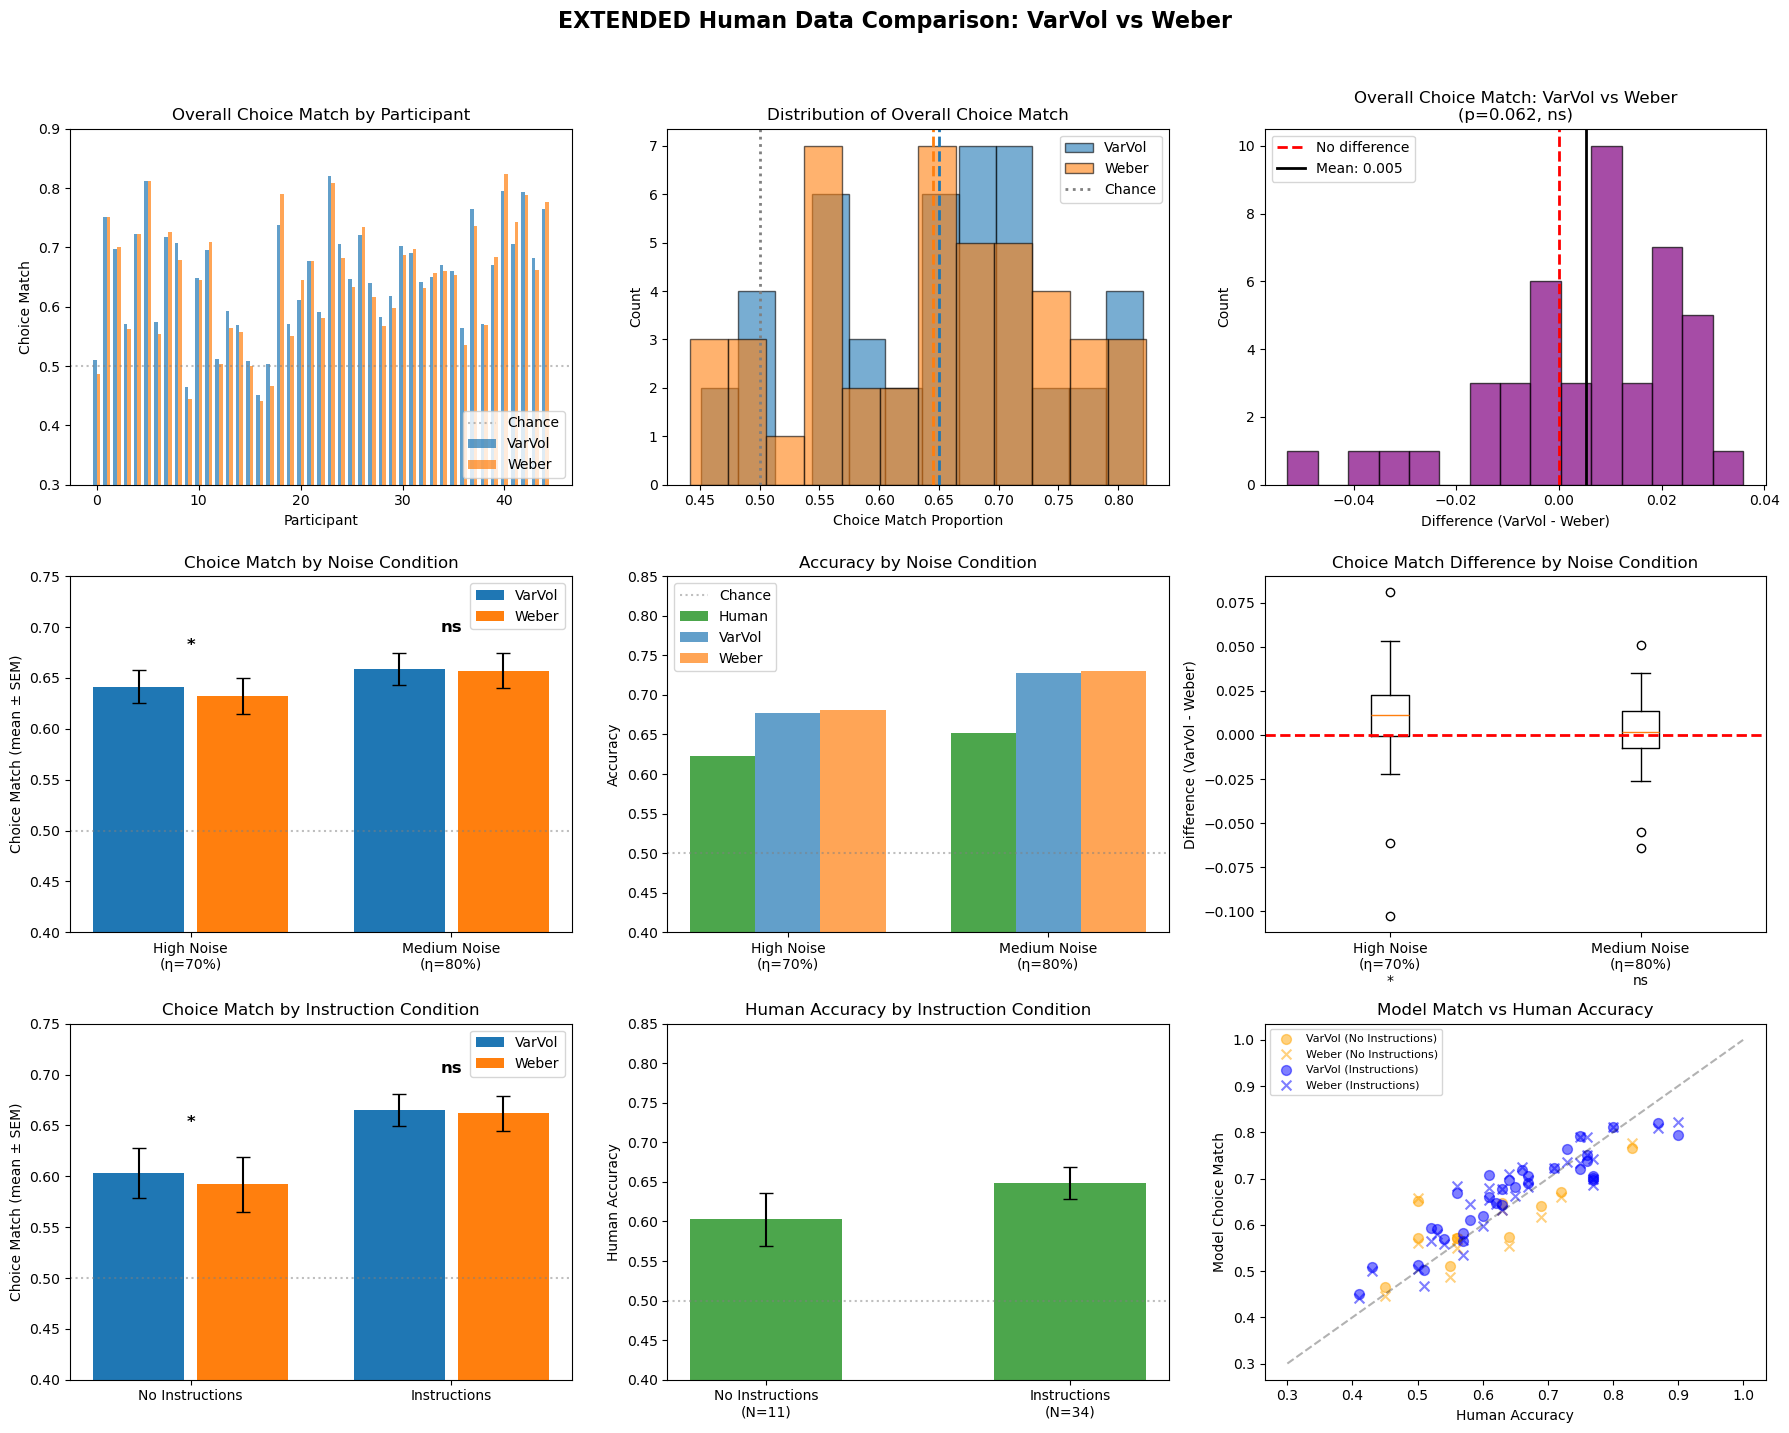

📊 Figure saved to: participant_data/extended_comparison_plots.png


In [113]:
# ============================================================
# 📊 EXTENDED VISUALIZATIONS
# ============================================================

fig = plt.figure(figsize=(18, 14))

# ============================================================
# ROW 1: Overall comparison
# ============================================================

# Plot 1: Choice match by participant (overall)
ax1 = fig.add_subplot(3, 3, 1)
x = np.arange(len(results_df))
width = 0.35
ax1.bar(x - width/2, results_df['varvol_match_overall'], width, label='VarVol', alpha=0.7, color='#1f77b4')
ax1.bar(x + width/2, results_df['weber_match_overall'], width, label='Weber', alpha=0.7, color='#ff7f0e')
ax1.axhline(0.5, color='gray', linestyle=':', alpha=0.5, label='Chance')
ax1.set_xlabel('Participant')
ax1.set_ylabel('Choice Match')
ax1.set_title('Overall Choice Match by Participant')
ax1.legend(loc='lower right')
ax1.set_ylim(0.3, 0.9)

# Plot 2: Overall distribution
ax2 = fig.add_subplot(3, 3, 2)
ax2.hist(results_df['varvol_match_overall'], bins=12, alpha=0.6, label='VarVol', color='#1f77b4', edgecolor='black')
ax2.hist(results_df['weber_match_overall'], bins=12, alpha=0.6, label='Weber', color='#ff7f0e', edgecolor='black')
ax2.axvline(results_df['varvol_match_overall'].mean(), color='#1f77b4', linestyle='--', linewidth=2)
ax2.axvline(results_df['weber_match_overall'].mean(), color='#ff7f0e', linestyle='--', linewidth=2)
ax2.axvline(0.5, color='gray', linestyle=':', linewidth=2, label='Chance')
ax2.set_xlabel('Choice Match Proportion')
ax2.set_ylabel('Count')
ax2.set_title('Distribution of Overall Choice Match')
ax2.legend()

# Plot 3: Difference distribution (VarVol - Weber)
ax3 = fig.add_subplot(3, 3, 3)
diff_overall = results_df['varvol_match_overall'] - results_df['weber_match_overall']
ax3.hist(diff_overall, bins=15, alpha=0.7, color='purple', edgecolor='black')
ax3.axvline(0, color='red', linestyle='--', linewidth=2, label='No difference')
ax3.axvline(diff_overall.mean(), color='black', linestyle='-', linewidth=2, label=f'Mean: {diff_overall.mean():.3f}')
ax3.set_xlabel('Difference (VarVol - Weber)')
ax3.set_ylabel('Count')
sig_overall = '*' if p_overall < 0.05 else 'ns'
ax3.set_title(f'Overall Choice Match: VarVol vs Weber\n(p={p_overall:.3f}, {sig_overall})')
ax3.legend()

# ============================================================
# ROW 2: By NOISE CONDITION (properly mapped!)
# ============================================================

# Plot 4: Choice match by noise condition
ax4 = fig.add_subplot(3, 3, 4)
noise_labels = ['High Noise\n(η=70%)', 'Medium Noise\n(η=80%)']
varvol_means = [results_df['varvol_match_high_noise'].mean(), results_df['varvol_match_medium_noise'].mean()]
weber_means = [results_df['weber_match_high_noise'].mean(), results_df['weber_match_medium_noise'].mean()]
varvol_sems = [results_df['varvol_match_high_noise'].sem(), results_df['varvol_match_medium_noise'].sem()]
weber_sems = [results_df['weber_match_high_noise'].sem(), results_df['weber_match_medium_noise'].sem()]

x_noise = np.arange(len(noise_labels))
ax4.bar(x_noise - 0.2, varvol_means, 0.35, yerr=varvol_sems, label='VarVol', color='#1f77b4', capsize=5)
ax4.bar(x_noise + 0.2, weber_means, 0.35, yerr=weber_sems, label='Weber', color='#ff7f0e', capsize=5)
ax4.axhline(0.5, color='gray', linestyle=':', alpha=0.5)
ax4.set_xticks(x_noise)
ax4.set_xticklabels(noise_labels)
ax4.set_ylabel('Choice Match (mean ± SEM)')
ax4.set_title('Choice Match by Noise Condition')
ax4.legend()
ax4.set_ylim(0.4, 0.75)

# Add significance stars (using p-values from cell 47)
for i, (p, label) in enumerate([(p_high, 'High'), (p_medium, 'Medium')]):
    sig = '*' if p < 0.05 else 'ns'
    max_height = max(varvol_means[i] + varvol_sems[i], weber_means[i] + weber_sems[i])
    ax4.text(i, max_height + 0.02, sig, ha='center', fontsize=12, fontweight='bold')

# Plot 5: Human accuracy by noise condition
ax5 = fig.add_subplot(3, 3, 5)
human_means = [results_df['human_acc_high_noise'].mean(), results_df['human_acc_medium_noise'].mean()]
human_sems = [results_df['human_acc_high_noise'].sem(), results_df['human_acc_medium_noise'].sem()]
varvol_acc_means = [results_df['varvol_acc_high_noise'].mean(), results_df['varvol_acc_medium_noise'].mean()]
weber_acc_means = [results_df['weber_acc_high_noise'].mean(), results_df['weber_acc_medium_noise'].mean()]

ax5.bar(x_noise - 0.25, human_means, 0.25, label='Human', color='green', alpha=0.7)
ax5.bar(x_noise, varvol_acc_means, 0.25, label='VarVol', color='#1f77b4', alpha=0.7)
ax5.bar(x_noise + 0.25, weber_acc_means, 0.25, label='Weber', color='#ff7f0e', alpha=0.7)
ax5.axhline(0.5, color='gray', linestyle=':', alpha=0.5, label='Chance')
ax5.set_xticks(x_noise)
ax5.set_xticklabels(noise_labels)
ax5.set_ylabel('Accuracy')
ax5.set_title('Accuracy by Noise Condition')
ax5.legend()
ax5.set_ylim(0.4, 0.85)

# Plot 6: Noise condition difference
ax6 = fig.add_subplot(3, 3, 6)
diff_high = results_df['varvol_match_high_noise'] - results_df['weber_match_high_noise']
diff_medium = results_df['varvol_match_medium_noise'] - results_df['weber_match_medium_noise']
sig_high = '*' if p_high < 0.05 else 'ns'
sig_medium = '*' if p_medium < 0.05 else 'ns'
ax6.boxplot([diff_high, diff_medium], tick_labels=[f'High Noise\n(η=70%)\n{sig_high}', f'Medium Noise\n(η=80%)\n{sig_medium}'])
ax6.axhline(0, color='red', linestyle='--', linewidth=2)
ax6.set_ylabel('Difference (VarVol - Weber)')
ax6.set_title('Choice Match Difference by Noise Condition')

# ============================================================
# ROW 3: By Instruction Condition
# ============================================================

# Plot 7: By instruction condition
ax7 = fig.add_subplot(3, 3, 7)
conditions = results_df['instruction_condition'].unique()
cond_varvol = [results_df[results_df['instruction_condition']==c]['varvol_match_overall'].mean() for c in conditions]
cond_weber = [results_df[results_df['instruction_condition']==c]['weber_match_overall'].mean() for c in conditions]
cond_varvol_sem = [results_df[results_df['instruction_condition']==c]['varvol_match_overall'].sem() for c in conditions]
cond_weber_sem = [results_df[results_df['instruction_condition']==c]['weber_match_overall'].sem() for c in conditions]

# Compute p-values for each condition
cond_pvals = []
for c in conditions:
    cond_df = results_df[results_df['instruction_condition'] == c]
    if len(cond_df) > 2:
        _, p = stats.ttest_rel(cond_df['varvol_match_overall'], cond_df['weber_match_overall'])
        cond_pvals.append(p)
    else:
        cond_pvals.append(1.0)  # Not enough data

x_cond = np.arange(len(conditions))
ax7.bar(x_cond - 0.2, cond_varvol, 0.35, yerr=cond_varvol_sem, label='VarVol', color='#1f77b4', capsize=5)
ax7.bar(x_cond + 0.2, cond_weber, 0.35, yerr=cond_weber_sem, label='Weber', color='#ff7f0e', capsize=5)
ax7.axhline(0.5, color='gray', linestyle=':', alpha=0.5)
ax7.set_xticks(x_cond)
ax7.set_xticklabels(conditions)
ax7.set_ylabel('Choice Match (mean ± SEM)')
ax7.set_title('Choice Match by Instruction Condition')
ax7.legend()
ax7.set_ylim(0.4, 0.75)

# Add significance stars
for i, p in enumerate(cond_pvals):
    sig = '*' if p < 0.05 else 'ns'
    max_height = max(cond_varvol[i] + cond_varvol_sem[i], cond_weber[i] + cond_weber_sem[i])
    ax7.text(i, max_height + 0.02, sig, ha='center', fontsize=12, fontweight='bold')

# Plot 8: Human accuracy by instruction
ax8 = fig.add_subplot(3, 3, 8)
cond_human = [results_df[results_df['instruction_condition']==c]['human_acc_overall'].mean() for c in conditions]
cond_human_sem = [results_df[results_df['instruction_condition']==c]['human_acc_overall'].sem() for c in conditions]
cond_n = [len(results_df[results_df['instruction_condition']==c]) for c in conditions]

ax8.bar(x_cond, cond_human, 0.5, yerr=cond_human_sem, color='green', alpha=0.7, capsize=5)
ax8.axhline(0.5, color='gray', linestyle=':', alpha=0.5)
ax8.set_xticks(x_cond)
ax8.set_xticklabels([f"{c}\n(N={n})" for c, n in zip(conditions, cond_n)])
ax8.set_ylabel('Human Accuracy')
ax8.set_title('Human Accuracy by Instruction Condition')
ax8.set_ylim(0.4, 0.85)

# Plot 9: Model vs Human scatter with instruction coloring
ax9 = fig.add_subplot(3, 3, 9)
colors = {'Instructions': 'blue', 'No Instructions': 'orange'}
for cond in conditions:
    cond_df = results_df[results_df['instruction_condition'] == cond]
    ax9.scatter(cond_df['human_acc_overall'], cond_df['varvol_match_overall'], 
                alpha=0.5, c=colors.get(cond, 'gray'), marker='o', s=50, label=f'VarVol ({cond})')
    ax9.scatter(cond_df['human_acc_overall'], cond_df['weber_match_overall'], 
                alpha=0.5, c=colors.get(cond, 'gray'), marker='x', s=50, label=f'Weber ({cond})')
ax9.plot([0.3, 1], [0.3, 1], 'k--', alpha=0.3)
ax9.set_xlabel('Human Accuracy')
ax9.set_ylabel('Model Choice Match')
ax9.set_title('Model Match vs Human Accuracy')
ax9.legend(loc='upper left', fontsize=8)

plt.suptitle('EXTENDED Human Data Comparison: VarVol vs Weber', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('participant_data/extended_comparison_plots.png', dpi=150, bbox_inches='tight')
plt.show()

print("📊 Figure saved to: participant_data/extended_comparison_plots.png")

Loaded 45 participants from 100-run analysis
Columns: ['participant_id', 'group', 'instruction_condition', 'n_trials', 'block1_condition', 'block2_condition', 'human_acc_overall', 'human_acc_block1', 'human_acc_block2', 'varvol_acc_overall', 'varvol_acc_block1', 'varvol_acc_block2', 'weber_acc_overall', 'weber_acc_block1', 'weber_acc_block2', 'varvol_match_overall', 'varvol_match_overall_std', 'varvol_match_block1', 'varvol_match_block1_std', 'varvol_match_block2', 'varvol_match_block2_std', 'weber_match_overall', 'weber_match_overall_std', 'weber_match_block1', 'weber_match_block1_std', 'weber_match_block2', 'weber_match_block2_std', 'task_switches', 'task_traps', 'task_beta']

📊 ACCURACY STATISTICS (100 MC runs)
Human     : Mean = 63.7% ± 1.7% (SEM), Std = 11.5%
VarVol    : Mean = 70.2% ± 0.9% (SEM), Std = 6.0%
Weber     : Mean = 70.6% ± 0.9% (SEM), Std = 6.3%

📈 STATISTICAL TESTS: Paired t-tests on Accuracy

Human vs VarVol:
   Mean diff: -6.5% (Human - VarVol)
   t = -3.986, p = 0.

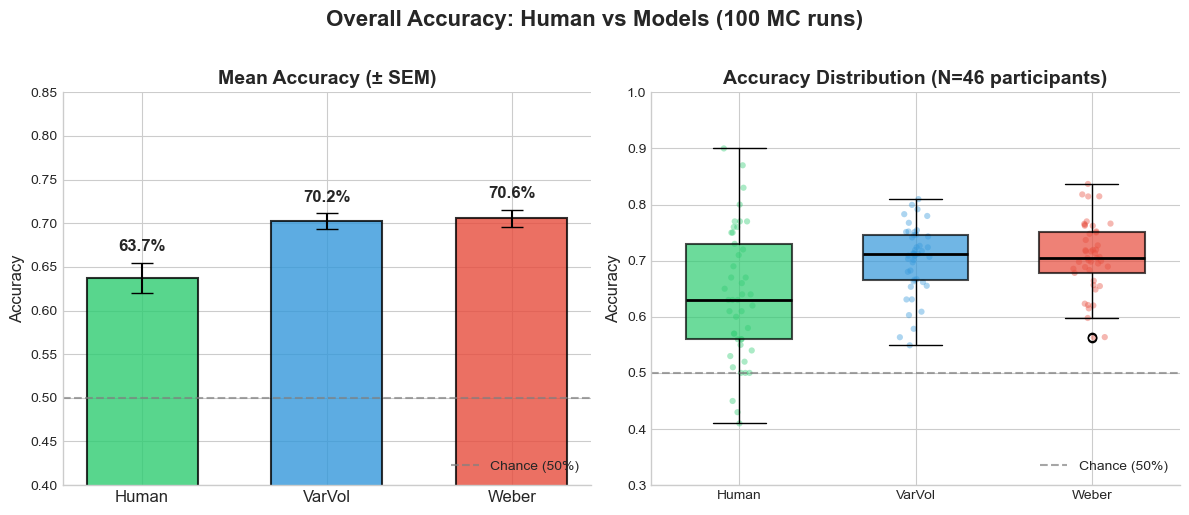


📊 Figure saved to: participant_data/accuracy_comparison_100runs.png


In [50]:
# ============================================================
# 📊 ACCURACY COMPARISON: Human vs VarVol vs Weber (100 runs)
# ============================================================
# Bar plot with mean accuracy + boxplot showing distribution

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the 100-run results
results_100 = pd.read_csv('participant_data/model_vs_human_comparison_extended_100_runs.csv')

print(f"Loaded {len(results_100)} participants from 100-run analysis")
print(f"Columns: {list(results_100.columns)}")

# Extract overall accuracy columns
human_acc = results_100['human_acc_overall'].values
varvol_acc = results_100['varvol_acc_overall'].values
weber_acc = results_100['weber_acc_overall'].values

# Calculate statistics
stats_data = {
    'Human': {'mean': np.mean(human_acc), 'std': np.std(human_acc), 'sem': np.std(human_acc)/np.sqrt(len(human_acc)), 'data': human_acc},
    'VarVol': {'mean': np.mean(varvol_acc), 'std': np.std(varvol_acc), 'sem': np.std(varvol_acc)/np.sqrt(len(varvol_acc)), 'data': varvol_acc},
    'Weber': {'mean': np.mean(weber_acc), 'std': np.std(weber_acc), 'sem': np.std(weber_acc)/np.sqrt(len(weber_acc)), 'data': weber_acc}
}

# Print statistics
print("\n" + "="*60)
print("📊 ACCURACY STATISTICS (100 MC runs)")
print("="*60)
for name, s in stats_data.items():
    print(f"{name:10s}: Mean = {s['mean']:.1%} ± {s['sem']:.1%} (SEM), Std = {s['std']:.1%}")

# ============================================================
# Statistical Tests: Paired t-tests
# ============================================================
from scipy import stats

print("\n" + "="*60)
print("📈 STATISTICAL TESTS: Paired t-tests on Accuracy")
print("="*60)

# Human vs VarVol
t_hv, p_hv = stats.ttest_rel(human_acc, varvol_acc)
print(f"\nHuman vs VarVol:")
print(f"   Mean diff: {np.mean(human_acc - varvol_acc):.1%} (Human - VarVol)")
print(f"   t = {t_hv:.3f}, p = {p_hv:.4f} {'***' if p_hv < 0.001 else '**' if p_hv < 0.01 else '*' if p_hv < 0.05 else 'ns'}")

# Human vs Weber
t_hw, p_hw = stats.ttest_rel(human_acc, weber_acc)
print(f"\nHuman vs Weber:")
print(f"   Mean diff: {np.mean(human_acc - weber_acc):.1%} (Human - Weber)")
print(f"   t = {t_hw:.3f}, p = {p_hw:.4f} {'***' if p_hw < 0.001 else '**' if p_hw < 0.01 else '*' if p_hw < 0.05 else 'ns'}")

# VarVol vs Weber
t_vw, p_vw = stats.ttest_rel(varvol_acc, weber_acc)
print(f"\nVarVol vs Weber:")
print(f"   Mean diff: {np.mean(varvol_acc - weber_acc):.1%} (VarVol - Weber)")
print(f"   t = {t_vw:.3f}, p = {p_vw:.4f} {'***' if p_vw < 0.001 else '**' if p_vw < 0.01 else '*' if p_vw < 0.05 else 'ns'}")

print("\n" + "-"*60)
print("Significance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")

# ============================================================
# Create figure with bar plot + boxplot
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Colors
colors = {'Human': '#2ecc71', 'VarVol': '#3498db', 'Weber': '#e74c3c'}
labels = ['Human', 'VarVol', 'Weber']

# --- LEFT: Bar plot with error bars ---
ax1 = axes[0]
x = np.arange(len(labels))
means = [stats_data[l]['mean'] for l in labels]
sems = [stats_data[l]['sem'] for l in labels]

bars = ax1.bar(x, means, 0.6, yerr=sems, capsize=8, 
               color=[colors[l] for l in labels], 
               edgecolor='black', linewidth=1.5, alpha=0.8)

# Add value labels on bars
for bar, mean, sem in zip(bars, means, sems):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + sem + 0.01, 
             f'{mean:.1%}', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax1.axhline(0.5, color='gray', linestyle='--', linewidth=1.5, alpha=0.7, label='Chance (50%)')
ax1.set_xticks(x)
ax1.set_xticklabels(labels, fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Mean Accuracy (± SEM)', fontsize=14, fontweight='bold')
ax1.set_ylim(0.4, 0.85)
ax1.legend(loc='lower right')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# --- RIGHT: Boxplot ---
ax2 = axes[1]
box_data = [stats_data[l]['data'] for l in labels]
bp = ax2.boxplot(box_data, tick_labels=labels, patch_artist=True, widths=0.6)

# Color the boxes
for patch, label in zip(bp['boxes'], labels):
    patch.set_facecolor(colors[label])
    patch.set_alpha(0.7)
    patch.set_edgecolor('black')
    patch.set_linewidth(1.5)

# Style medians
for median in bp['medians']:
    median.set_color('black')
    median.set_linewidth(2)

ax2.axhline(0.5, color='gray', linestyle='--', linewidth=1.5, alpha=0.7, label='Chance (50%)')
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Accuracy Distribution (N=46 participants)', fontsize=14, fontweight='bold')
ax2.set_ylim(0.3, 1.0)
ax2.legend(loc='lower right')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Add individual points (jittered)
for i, (label, data) in enumerate(zip(labels, box_data)):
    jitter = np.random.normal(0, 0.04, size=len(data))
    ax2.scatter(np.ones(len(data)) * (i+1) + jitter, data, 
                alpha=0.4, s=20, color=colors[label], edgecolor='none')

plt.suptitle('Overall Accuracy: Human vs Models (100 MC runs)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('participant_data/accuracy_comparison_100runs.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Figure saved to: participant_data/accuracy_comparison_100runs.png")


Loaded 45 participants from 100-run analysis

📊 CHOICE ALIGNMENT STATISTICS (100 MC runs)
Choice Match = proportion of trials where model choice == human choice

VarVol    : Mean = 65.0% ± 1.4% (SEM), Std = 9.2%
Weber     : Mean = 64.5% ± 1.5% (SEM), Std = 10.1%

📈 STATISTICAL TEST: Which model aligns better with humans?

VarVol vs Weber Choice Match:
   VarVol mean:  65.0%
   Weber mean:   64.5%
   Difference:   +0.5% (VarVol - Weber)
   t = 1.916, p = 0.0618 ns

   → VarVol matches human choices better

------------------------------------------------------------
Significance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant


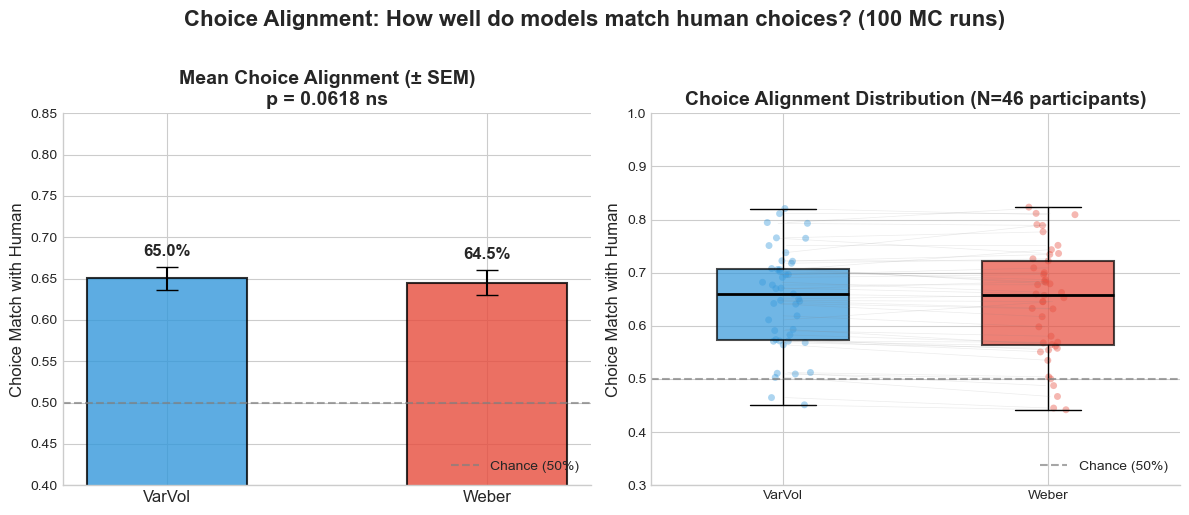


📊 Figure saved to: participant_data/choice_alignment_comparison_100runs.png


In [51]:
# ============================================================
# 📊 CHOICE ALIGNMENT: How well do models match human choices? (100 runs)
# ============================================================
# Bar plot with mean choice match + boxplot showing distribution

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Load the 100-run results
results_100 = pd.read_csv('participant_data/model_vs_human_comparison_extended_100_runs.csv')

print(f"Loaded {len(results_100)} participants from 100-run analysis")

# Extract choice match columns
varvol_match = results_100['varvol_match_overall'].values
weber_match = results_100['weber_match_overall'].values

# Calculate statistics
stats_data = {
    'VarVol': {'mean': np.mean(varvol_match), 'std': np.std(varvol_match), 'sem': np.std(varvol_match)/np.sqrt(len(varvol_match)), 'data': varvol_match},
    'Weber': {'mean': np.mean(weber_match), 'std': np.std(weber_match), 'sem': np.std(weber_match)/np.sqrt(len(weber_match)), 'data': weber_match}
}

# Print statistics
print("\n" + "="*60)
print("📊 CHOICE ALIGNMENT STATISTICS (100 MC runs)")
print("="*60)
print("Choice Match = proportion of trials where model choice == human choice")
print()
for name, s in stats_data.items():
    print(f"{name:10s}: Mean = {s['mean']:.1%} ± {s['sem']:.1%} (SEM), Std = {s['std']:.1%}")

# ============================================================
# Statistical Test: Paired t-test (VarVol vs Weber)
# ============================================================
print("\n" + "="*60)
print("📈 STATISTICAL TEST: Which model aligns better with humans?")
print("="*60)

t_vw, p_vw = stats.ttest_rel(varvol_match, weber_match)
mean_diff = np.mean(varvol_match - weber_match)
winner = "VarVol" if mean_diff > 0 else "Weber"

print(f"\nVarVol vs Weber Choice Match:")
print(f"   VarVol mean:  {np.mean(varvol_match):.1%}")
print(f"   Weber mean:   {np.mean(weber_match):.1%}")
print(f"   Difference:   {mean_diff:+.1%} (VarVol - Weber)")
print(f"   t = {t_vw:.3f}, p = {p_vw:.4f} {'***' if p_vw < 0.001 else '**' if p_vw < 0.01 else '*' if p_vw < 0.05 else 'ns'}")
print(f"\n   → {winner} matches human choices {'significantly ' if p_vw < 0.05 else ''}better" if mean_diff != 0 else "   → Models perform equally")

print("\n" + "-"*60)
print("Significance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")

# ============================================================
# Create figure with bar plot + boxplot
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Colors
colors = {'VarVol': '#3498db', 'Weber': '#e74c3c'}
labels = ['VarVol', 'Weber']

# --- LEFT: Bar plot with error bars ---
ax1 = axes[0]
x = np.arange(len(labels))
means = [stats_data[l]['mean'] for l in labels]
sems = [stats_data[l]['sem'] for l in labels]

bars = ax1.bar(x, means, 0.5, yerr=sems, capsize=8, 
               color=[colors[l] for l in labels], 
               edgecolor='black', linewidth=1.5, alpha=0.8)

# Add value labels on bars
for bar, mean, sem in zip(bars, means, sems):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + sem + 0.01, 
             f'{mean:.1%}', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax1.axhline(0.5, color='gray', linestyle='--', linewidth=1.5, alpha=0.7, label='Chance (50%)')
ax1.set_xticks(x)
ax1.set_xticklabels(labels, fontsize=12)
ax1.set_ylabel('Choice Match with Human', fontsize=12)
ax1.set_title(f'Mean Choice Alignment (± SEM)\np = {p_vw:.4f} {"*" if p_vw < 0.05 else "ns"}', fontsize=14, fontweight='bold')
ax1.set_ylim(0.4, 0.85)
ax1.legend(loc='lower right')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# --- RIGHT: Boxplot ---
ax2 = axes[1]
box_data = [stats_data[l]['data'] for l in labels]
bp = ax2.boxplot(box_data, tick_labels=labels, patch_artist=True, widths=0.5)

# Color the boxes
for patch, label in zip(bp['boxes'], labels):
    patch.set_facecolor(colors[label])
    patch.set_alpha(0.7)
    patch.set_edgecolor('black')
    patch.set_linewidth(1.5)

# Style medians
for median in bp['medians']:
    median.set_color('black')
    median.set_linewidth(2)

ax2.axhline(0.5, color='gray', linestyle='--', linewidth=1.5, alpha=0.7, label='Chance (50%)')
ax2.set_ylabel('Choice Match with Human', fontsize=12)
ax2.set_title('Choice Alignment Distribution (N=46 participants)', fontsize=14, fontweight='bold')
ax2.set_ylim(0.3, 1.0)
ax2.legend(loc='lower right')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Add individual points (jittered)
for i, (label, data) in enumerate(zip(labels, box_data)):
    jitter = np.random.normal(0, 0.04, size=len(data))
    ax2.scatter(np.ones(len(data)) * (i+1) + jitter, data, 
                alpha=0.4, s=25, color=colors[label], edgecolor='none')

# Add connecting lines between paired observations
for i in range(len(varvol_match)):
    ax2.plot([1 + np.random.normal(0, 0.01), 2 + np.random.normal(0, 0.01)], 
             [varvol_match[i], weber_match[i]], 
             color='gray', alpha=0.15, linewidth=0.5)

plt.suptitle('Choice Alignment: How well do models match human choices? (100 MC runs)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('participant_data/choice_alignment_comparison_100runs.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Figure saved to: participant_data/choice_alignment_comparison_100runs.png")


🧮 BAYESIAN HYPOTHESIS ANALYSIS

Question: Is there a difference in how well models align with humans?
Data: 45 paired observations (VarVol match - Weber match)

----------------------------------------------------------------------
📊 METHOD 1: Bayesian Estimation of Difference
----------------------------------------------------------------------

Observed difference (VarVol - Weber):
   Mean:     +0.54%
   Std Dev:  1.88%
   SEM:      0.28%

95% Credible Interval: [-0.03%, +1.10%]

Posterior Probabilities:
   P(VarVol better than Weber) = 96.9%
   P(Weber better than VarVol) = 3.1%

----------------------------------------------------------------------
📊 METHOD 2: Bayes Factor (JZS Prior)
----------------------------------------------------------------------

t-statistic: 1.916

Bayes Factor (JZS prior, r=0.707):
   BF₁₀ = 4.479 (evidence for difference)
   BF₀₁ = 0.223 (evidence for no difference)

   Interpretation: Moderate evidence for a difference

-------------------------------

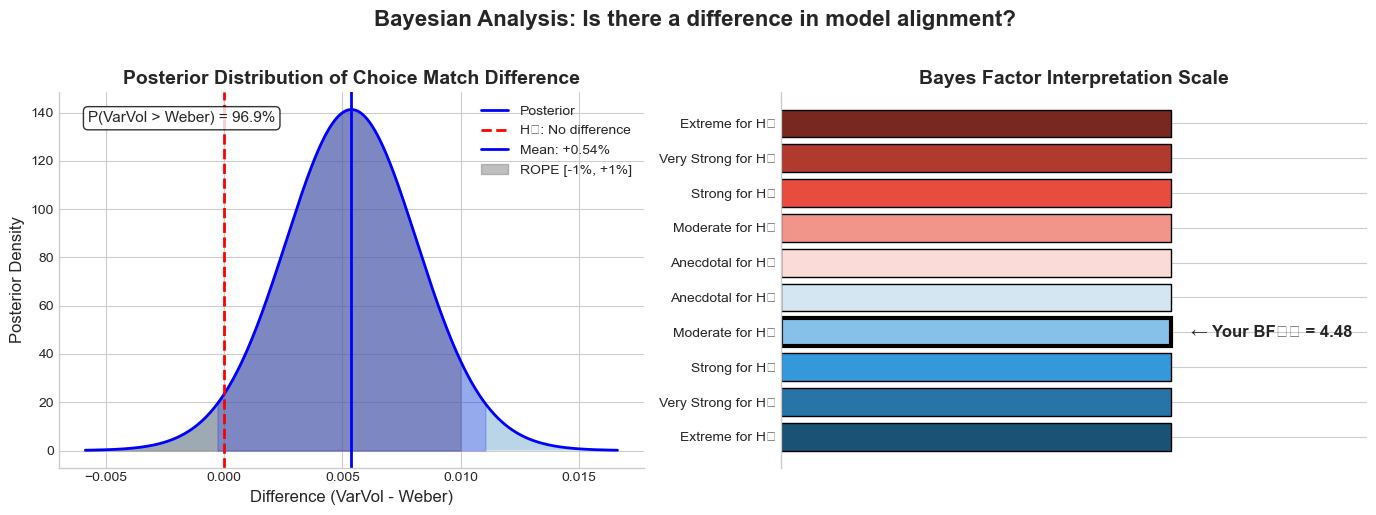


📋 SUMMARY


ValueError: Invalid format specifier '.2f if bf10 else 'N/A'' for object of type 'float'

📊 LOO MODEL COMPARISON

Comparing predictive accuracy: Which model better predicts human choices?

Data: 45 participants × 100 trials each

----------------------------------------------------------------------
📈 LOO CROSS-VALIDATION RESULTS
----------------------------------------------------------------------

Model              ELPD         SE
-----------------------------------
VarVol          -1984.6       97.3
Weber           -2032.9      107.3

Difference (VarVol - Weber):
   ΔELPD = 48.3 ± 19.1
   95% CI: [9.3, 85.1]

----------------------------------------------------------------------
📋 INTERPRETATION
----------------------------------------------------------------------

ELPD (Expected Log Pointwise Predictive Density):
  • Higher ELPD = better out-of-sample prediction
  • ΔELPD = 48.3: VarVol predicts 48.3 log-likelihood units better

Rule of thumb for ΔELPD:
  • |ΔELPD| < 4:  Models are similar (within noise)
  • |ΔELPD| 4-10: Moderate difference
  • |ΔELPD| > 10: Substan

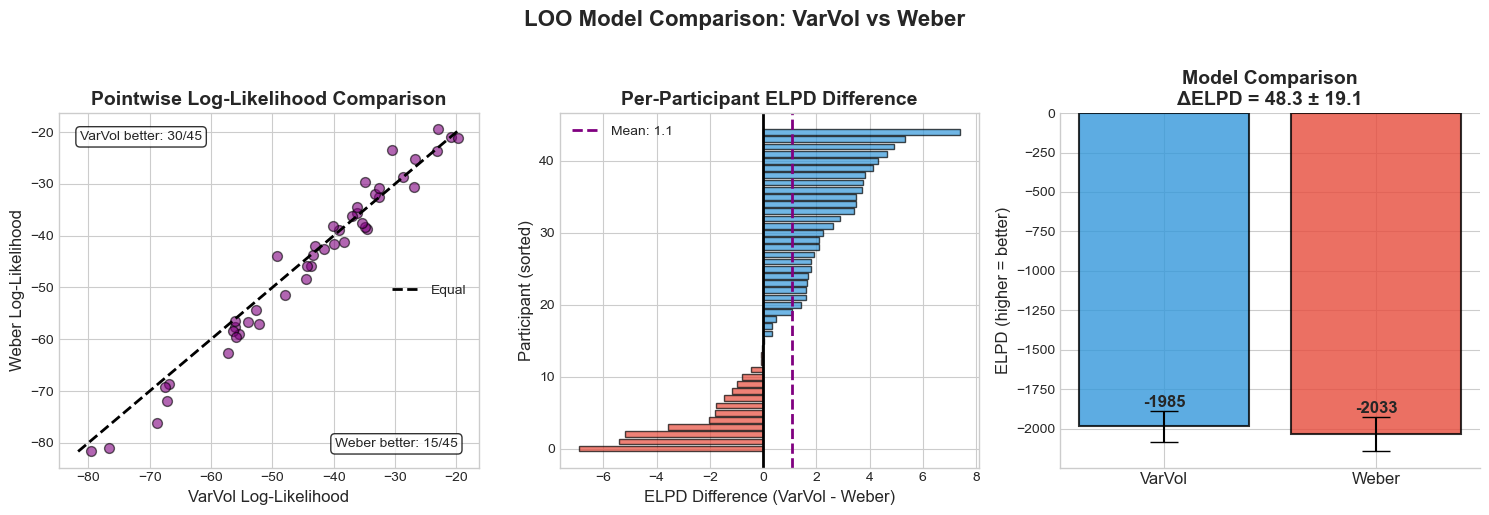


📊 Figure saved to: participant_data/loo_comparison.png

----------------------------------------------------------------------
📊 MODEL WEIGHTS (Pseudo-BMA)
----------------------------------------------------------------------

Model weights (higher = more predictive):
   VarVol: 100.0%
   Weber:  0.0%

These weights can be used for Bayesian Model Averaging (BMA)


In [54]:
# ============================================================
# 📊 LOO MODEL COMPARISON: VarVol vs Weber
# ============================================================
# Leave-One-Out Cross-Validation for model comparison
# Compares which model better predicts human choices

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("📊 LOO MODEL COMPARISON")
print("="*70)
print("\nComparing predictive accuracy: Which model better predicts human choices?")

# ============================================================
# Step 1: Load data and compute log-likelihoods
# ============================================================
results_100 = pd.read_csv('participant_data/model_vs_human_comparison_extended_100_runs.csv')

n_trials = 100  # trials per participant
n_participants = len(results_100)

varvol_match = results_100['varvol_match_overall'].values
weber_match = results_100['weber_match_overall'].values

# Clip to avoid log(0)
eps = 1e-6
varvol_match_clipped = np.clip(varvol_match, eps, 1-eps)
weber_match_clipped = np.clip(weber_match, eps, 1-eps)

# Approximate log-likelihood per participant
# LL_i ≈ n_trials * log(match_rate)
ll_varvol = n_trials * np.log(varvol_match_clipped)
ll_weber = n_trials * np.log(weber_match_clipped)

print(f"\nData: {n_participants} participants × {n_trials} trials each")

# ============================================================
# Step 2: Compute LOO statistics (Bootstrap method)
# ============================================================
print("\n" + "-"*70)
print("📈 LOO CROSS-VALIDATION RESULTS")
print("-"*70)

# ELPD = sum of pointwise log-likelihoods
elpd_varvol = np.sum(ll_varvol)
elpd_weber = np.sum(ll_weber)

# SE via bootstrap
n_boot = 1000
np.random.seed(42)
elpd_varvol_boot = []
elpd_weber_boot = []

for _ in range(n_boot):
    idx = np.random.choice(n_participants, n_participants, replace=True)
    elpd_varvol_boot.append(np.sum(ll_varvol[idx]))
    elpd_weber_boot.append(np.sum(ll_weber[idx]))

se_varvol = np.std(elpd_varvol_boot)
se_weber = np.std(elpd_weber_boot)

print(f"\n{'Model':<10} {'ELPD':>12} {'SE':>10}")
print("-"*35)
print(f"{'VarVol':<10} {elpd_varvol:>12.1f} {se_varvol:>10.1f}")
print(f"{'Weber':<10} {elpd_weber:>12.1f} {se_weber:>10.1f}")

# Difference
diff_elpd = elpd_varvol - elpd_weber
diff_boot = np.array(elpd_varvol_boot) - np.array(elpd_weber_boot)
diff_se = np.std(diff_boot)

print(f"\nDifference (VarVol - Weber):")
print(f"   ΔELPD = {diff_elpd:.1f} ± {diff_se:.1f}")
print(f"   95% CI: [{np.percentile(diff_boot, 2.5):.1f}, {np.percentile(diff_boot, 97.5):.1f}]")

# ============================================================
# Step 4: Interpretation
# ============================================================
print("\n" + "-"*70)
print("📋 INTERPRETATION")
print("-"*70)

if diff_elpd > 0:
    better_model = "VarVol"
    worse_model = "Weber"
else:
    better_model = "Weber"
    worse_model = "VarVol"
    diff_elpd = -diff_elpd

# Convert to interpretable scale
# ELPD difference in terms of "expected correct predictions"
elpd_per_obs = diff_elpd / (n_participants * n_trials)

print(f"""
ELPD (Expected Log Pointwise Predictive Density):
  • Higher ELPD = better out-of-sample prediction
  • ΔELPD = {diff_elpd:.1f}: {better_model} predicts {abs(diff_elpd):.1f} log-likelihood units better

Rule of thumb for ΔELPD:
  • |ΔELPD| < 4:  Models are similar (within noise)
  • |ΔELPD| 4-10: Moderate difference
  • |ΔELPD| > 10: Substantial difference

Your result: |ΔELPD| = {abs(diff_elpd):.1f}
""")

if abs(diff_elpd) < 2 * diff_se:
    print(f"⚖️  CONCLUSION: Models are statistically indistinguishable")
    print(f"   The difference ({diff_elpd:.1f}) is within 2 SE ({2*diff_se:.1f})")
else:
    print(f"✓ CONCLUSION: {better_model} is the better model")
    print(f"   The difference ({diff_elpd:.1f}) exceeds 2 SE ({2*diff_se:.1f})")

# ============================================================
# Step 5: Visualization
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# --- Plot 1: Pointwise ELPD comparison ---
ax1 = axes[0]
ax1.scatter(ll_varvol, ll_weber, alpha=0.6, s=50, c='purple', edgecolor='black')
min_ll = min(ll_varvol.min(), ll_weber.min())
max_ll = max(ll_varvol.max(), ll_weber.max())
ax1.plot([min_ll, max_ll], [min_ll, max_ll], 'k--', linewidth=2, label='Equal')
ax1.set_xlabel('VarVol Log-Likelihood', fontsize=12)
ax1.set_ylabel('Weber Log-Likelihood', fontsize=12)
ax1.set_title('Pointwise Log-Likelihood Comparison', fontsize=14, fontweight='bold')
ax1.legend()

# Add marginal counts
n_varvol_better = np.sum(ll_varvol > ll_weber)
n_weber_better = np.sum(ll_weber > ll_varvol)
ax1.text(0.05, 0.95, f'VarVol better: {n_varvol_better}/{n_participants}', 
         transform=ax1.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax1.text(0.95, 0.05, f'Weber better: {n_weber_better}/{n_participants}', 
         transform=ax1.transAxes, fontsize=10, verticalalignment='bottom', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# --- Plot 2: ELPD difference per participant ---
ax2 = axes[1]
ll_diff = ll_varvol - ll_weber
sorted_idx = np.argsort(ll_diff)
colors = ['#3498db' if d > 0 else '#e74c3c' for d in ll_diff[sorted_idx]]
ax2.barh(range(n_participants), ll_diff[sorted_idx], color=colors, edgecolor='black', alpha=0.7)
ax2.axvline(0, color='black', linewidth=2)
ax2.axvline(np.mean(ll_diff), color='purple', linewidth=2, linestyle='--', label=f'Mean: {np.mean(ll_diff):.1f}')
ax2.set_xlabel('ELPD Difference (VarVol - Weber)', fontsize=12)
ax2.set_ylabel('Participant (sorted)', fontsize=12)
ax2.set_title('Per-Participant ELPD Difference', fontsize=14, fontweight='bold')
ax2.legend()

# --- Plot 3: Summary comparison ---
ax3 = axes[2]
models = ['VarVol', 'Weber']
elpds = [elpd_varvol, elpd_weber]
ses = [se_varvol, se_weber]
colors = ['#3498db', '#e74c3c']

x = np.arange(len(models))
bars = ax3.bar(x, elpds, yerr=ses, capsize=10, color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)

# Add value labels
for bar, elpd, se in zip(bars, elpds, ses):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + se + 5, 
             f'{elpd:.0f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax3.set_xticks(x)
ax3.set_xticklabels(models, fontsize=12)
ax3.set_ylabel('ELPD (higher = better)', fontsize=12)
ax3.set_title(f'Model Comparison\nΔELPD = {diff_elpd:.1f} ± {diff_se:.1f}', fontsize=14, fontweight='bold')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

plt.suptitle('LOO Model Comparison: VarVol vs Weber', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('participant_data/loo_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Figure saved to: participant_data/loo_comparison.png")

# ============================================================
# Step 6: Model weights (Pseudo-BMA)
# ============================================================
print("\n" + "-"*70)
print("📊 MODEL WEIGHTS (Pseudo-BMA)")
print("-"*70)

# Compute stacking/pseudo-BMA weights
# Weight ∝ exp(ELPD)
log_weights = np.array([elpd_varvol, elpd_weber])
# Normalize in log space for numerical stability
log_weights_norm = log_weights - np.max(log_weights)
weights = np.exp(log_weights_norm)
weights = weights / np.sum(weights)

print(f"\nModel weights (higher = more predictive):")
print(f"   VarVol: {weights[0]:.1%}")
print(f"   Weber:  {weights[1]:.1%}")
print(f"\nThese weights can be used for Bayesian Model Averaging (BMA)")


# Section 3: Comparing with Classroom Data


You'll get one CSV per participant from your study platform. The helpers below will:
1. **Combine** all CSVs into one dataframe
2. **Compute** per-trial accuracy across all participants
3. **Plot** human data against model predictions
4. **Compare** how do model vs human's recover after a volatile event?

### Step 1: Combine all participant CSVs


### 🧠 To Do: Now things are going to get interesting...
1. Download the entire ExperimentData folder from Stud.IP onto your local computer (shouldn't be more than a few KB per person - so memory shouldn't be an issue)
2. If zipped - unzip the folder
3. Add the individual files into /participant_data (you can just drag and drop into the notebook subfolder)
4. Run the combine_participant_csvs function
5. Check you have a new file called 'combined_data.csv'

```
findling_notebook/
├── notebook.ipynb                 ← You are here!
├── images_and_figures/
└── participant_data/
    ├── experiment_data.csv        ← Individual participant files
    ├── experiment_data2.csv
    ├── ...
    ├── backup_combined_data.csv   ← In case nothing works, here is a backup data file
    └── combined_data.csv          ← Auto-generated combined file
```
Each CSV has a few NaN columns this is ok, check there are valid terms for the columns: `trialNumber`, `userChoice` (0=Orange, 1=Blue)and `trueState` (correct answer).


In [45]:
import glob
import os

def combine_participant_csvs(
    folder_path: str,
    pattern: str = "*.csv",
    participant_id_from: str = "filename",  # "filename" or "column"
    participant_col: str = "participant_id",
    save_combined: bool = True,
    output_filename: str = "combined_data.csv",
) -> pd.DataFrame:
    """
    Combine multiple participant CSV files into one dataframe.
    
    Parameters
    ----------
    folder_path : str
        Path to folder containing the CSV files
    pattern : str
        Glob pattern to match CSV files (default: "*.csv")
    participant_id_from : str
        How to get participant ID:
        - "filename": extract from filename (e.g., "participant_001.csv" → "participant_001")
        - "column": assume each CSV already has a participant_col column
    participant_col : str
        Name for the participant ID column in output
    save_combined : bool
        Whether to save the combined dataframe to a CSV
    output_filename : str
        Filename for the combined CSV (saved in folder_path)
    
    Returns
    -------
    pd.DataFrame
        Combined dataframe with all participants
    """
    # Find all matching CSV files
    csv_files = glob.glob(os.path.join(folder_path, pattern))
    
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in {folder_path} matching '{pattern}'")
    
    print(f"Found {len(csv_files)} CSV files:")
    for f in csv_files[:5]:
        print(f"  - {os.path.basename(f)}")
    if len(csv_files) > 5:
        print(f"  ... and {len(csv_files) - 5} more")
    
    # Load and combine
    all_dfs = []
    for csv_file in csv_files:
        df = pd.read_csv(csv_file)
        
        if participant_id_from == "filename":
            # Extract participant ID from filename (without extension)
            participant_id = os.path.splitext(os.path.basename(csv_file))[0]
            df[participant_col] = participant_id
        elif participant_id_from == "column":
            if participant_col not in df.columns:
                raise ValueError(f"Column '{participant_col}' not found in {csv_file}")
        
        all_dfs.append(df)
    
    combined = pd.concat(all_dfs, ignore_index=True)
    
    print(f"\n✓ Combined {len(csv_files)} files → {len(combined)} total rows")
    print(f"  Participants: {combined[participant_col].nunique()}")
    print(f"  Columns: {list(combined.columns)}")
    
    if save_combined:
        output_path = os.path.join(folder_path, output_filename)
        combined.to_csv(output_path, index=False)
        print(f"  Saved to: {output_path}")
    
    return combined


In [46]:
DATA_FOLDER = "participant_data"  # folder containing all the CSVs

human_df = combine_participant_csvs(
    folder_path=DATA_FOLDER,
    pattern="*.csv",              # matches all CSV files
    participant_id_from="filename",  # uses filename as participant ID
    save_combined=True,           # saves combined_data.csv
)

# Preview the data
human_df.head()


Found 8 CSV files:
  - backup_combined_data.csv
  - combined_data.csv
  - model_simulation_results.csv
  - model_simulation_results2.csv
  - model_simulation_results_3_noise_levels.csv
  ... and 3 more

✓ Combined 8 files → 99035 total rows
  Participants: 8
  Columns: ['trialNumber', 'stimulus', 'trueState', 'userChoice', 'outcome', 'reactionTime', 'isRuleChange', 'modelChoice', 'modelIsCorrect', 'participant_id', 'participantId', 'group', 'instructionCondition', 'block', 'condition', 'isCorrect', 'n_trials', 'human_accuracy', 'varvol_accuracy', 'weber_accuracy', 'varvol_choice_match', 'weber_choice_match', 'varvol_choice_match_std', 'weber_choice_match_std', 'task_beta', 'task_switches', 'task_traps', 'instruction_condition', 'block1_condition', 'block2_condition', 'human_acc_overall', 'human_acc_block1', 'human_acc_block2', 'varvol_acc_overall', 'varvol_acc_block1', 'varvol_acc_block2', 'weber_acc_overall', 'weber_acc_block1', 'weber_acc_block2', 'varvol_match_overall', 'varvol_matc

C:\Users\beani\AppData\Local\Temp\ipykernel_4376\2282868612.py:52: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)


  Saved to: participant_data\combined_data.csv


,trialNumber,stimulus,trueState,userChoice,outcome,reactionTime,isRuleChange,modelChoice,modelIsCorrect,participant_id,...,varvol_match_block1,varvol_match_block1_std,varvol_match_block2,varvol_match_block2_std,weber_match_overall,weber_match_overall_std,weber_match_block1,weber_match_block1_std,weber_match_block2,weber_match_block2_std
0,1.0,NaN,0.0,0.0,win,2371.0,False,NaN,NaN,backup_combined_data,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,NaN,0.0,0.0,win,471.0,False,NaN,NaN,backup_combined_data,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,NaN,0.0,0.0,win,310.0,False,NaN,NaN,backup_combined_data,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,NaN,0.0,0.0,loss,248.0,False,NaN,NaN,backup_combined_data,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,NaN,0.0,1.0,loss,718.0,False,NaN,NaN,backup_combined_data,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Step 2: Compute human accuracy per trial


In [47]:
def load_human_accuracy(
    csv_path: str,
    trial_col: str = "trialNumber",
    action_col: str = "userChoice",
    correct_col: str = "trueState",
    participant_col: Optional[str] = None,
) -> Tuple[np.ndarray, np.ndarray]:
    """Load a CSV and return mean ± SEM accuracy per trial."""
    df = pd.read_csv(csv_path)
    df = df.sort_values(by=[participant_col, trial_col] if participant_col else trial_col)
    df["correct"] = (df[action_col] == df[correct_col]).astype(float)

    if participant_col:
        grouped = df.groupby([participant_col, trial_col])["correct"].mean().reset_index()
        pivot = grouped.pivot(index=participant_col, columns=trial_col, values="correct")
    else:
        pivot = df.pivot(columns=trial_col, values="correct")

    mean = pivot.mean(axis=0).values
    sem = pivot.std(axis=0).values / np.sqrt(pivot.shape[0])
    trials = pivot.columns.to_numpy()
    return trials, mean, sem


### Step 3: Plot humans vs models


In [48]:

# ============================================================
# HUMAN vs MODEL COMPARISON
# ============================================================
# Note: This compares human data against the LOW NOISE condition
# since classroom experiments typically use reliable feedback.

# Load human accuracy
trials_h, mean_h, sem_h = load_human_accuracy(
    csv_path="participant_data/combined_data.csv",
    trial_col="trialNumber",
    action_col="userChoice",
    correct_col="trueState",
    participant_col="participant_id",
)

print(f"✓ Loaded human data: {len(trials_h)} trials")

# Use LOW NOISE condition for comparison (closest to classroom setup)
# Truncate model data to match human trial count
n_human_trials = len(trials_h)
model_trials = np.arange(n_human_trials)

plt.figure(figsize=(10, 5))

# Plot model predictions (truncated to human trial count)
if n_human_trials <= len(acc_varvol_low):
    plt.plot(model_trials, acc_varvol_low[:n_human_trials], label="Var-Vol (low noise)", color="#1f77b4", linewidth=2)
    plt.fill_between(model_trials, 
                     acc_varvol_low[:n_human_trials] - sem_varvol_low[:n_human_trials], 
                     acc_varvol_low[:n_human_trials] + sem_varvol_low[:n_human_trials], 
                     alpha=0.2, color="#1f77b4")
    plt.plot(model_trials, acc_weber_low[:n_human_trials], label="Weber (low noise)", color="#ff7f0e", linewidth=2)
    plt.fill_between(model_trials, 
                     acc_weber_low[:n_human_trials] - sem_weber_low[:n_human_trials], 
                     acc_weber_low[:n_human_trials] + sem_weber_low[:n_human_trials], 
                     alpha=0.2, color="#ff7f0e")
else:
    print(f"⚠️ Human data has more trials ({n_human_trials}) than model ({len(acc_varvol_low)})")
    plt.plot(trials, acc_varvol_low, label="Var-Vol (low noise)", color="#1f77b4", linewidth=2)
    plt.plot(trials, acc_weber_low, label="Weber (low noise)", color="#ff7f0e", linewidth=2)

# Plot human data
plt.plot(trials_h, mean_h, "o-", color="black", linewidth=2, markersize=4, label="Humans")
plt.fill_between(trials_h, mean_h - sem_h, mean_h + sem_h, alpha=0.2, color="black")

plt.axhline(0.5, color="gray", linestyle=":", alpha=0.5, label="Chance")
plt.xlabel("Trial")
plt.ylabel("Proportion correct")
plt.legend()
plt.ylim(0, 1)
plt.title(f"Human choices vs Model predictions (Low Noise η={LOW_NOISE_BETA:.0%})")
plt.show()

# Summary stats
print(f"\n📊 Mean Accuracy Comparison:")
print(f"   Human:    {mean_h.mean():.1%}")
print(f"   Var-Vol:  {acc_varvol_low[:n_human_trials].mean():.1%}" if n_human_trials <= len(acc_varvol_low) else "   Var-Vol:  N/A")
print(f"   Weber:    {acc_weber_low[:n_human_trials].mean():.1%}" if n_human_trials <= len(acc_weber_low) else "   Weber:    N/A")


✓ Loaded human data: 100 trials


C:\Users\beani\AppData\Local\Temp\ipykernel_4376\2565581326.py:9: DtypeWarning: Columns (6,27,28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


NameError: name 'acc_varvol_low' is not defined

<Figure size 1000x500 with 0 Axes>

### Step 4: Visualising how the agents recover after a volatile event
The helpers below show (a) a single run comparing chosen vs correct arms, and (b) average recovery after each switch.


In [ ]:
def plot_action_timeline(task: VolatileBanditTask, sim_result: Dict[str, np.ndarray], agent_label: str, run_idx: int = 0):
    trials = np.arange(len(task.latent_states))
    correct_actions = task.correct_actions
    chosen = sim_result["actions"][run_idx]
    rewards = sim_result["rewards"][run_idx]
    switches = np.where(np.diff(task.latent_states) != 0)[0] + 0.5

    plt.figure(figsize=(10, 3))
    for sw in switches:
        plt.axvline(sw, color="gray", linestyle="--", alpha=0.3)
    plt.step(trials, correct_actions, where="post", label="Correct arm", linewidth=2, color="black")
    plt.scatter(trials, chosen, c=np.where(chosen == correct_actions, "#2ca02c", "#d62728"), label="Chosen arm")
    plt.yticks([0, 1], ["Arm 0", "Arm 1"])
    plt.xlabel("Trial")
    plt.title(f"{agent_label}: chosen vs correct arm (run {run_idx})")
    plt.legend(loc="upper right")
    plt.show()

    plt.figure(figsize=(10, 1.8))
    plt.scatter(trials, rewards, c=rewards, cmap="coolwarm", vmin=0, vmax=1)
    plt.yticks([0, 1], ["Feedback=0", "Feedback=1"])
    plt.xlabel("Trial")
    plt.title("Feedback received")
    plt.show()


def switch_aligned_accuracy(
    task: VolatileBanditTask, 
    sim_result: Dict[str, np.ndarray], 
    before: int = 5,      # trials BEFORE switch to include
    after: int = 12       # trials AFTER switch to include
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Compute average accuracy aligned to switch points.
    Returns x-axis (centered at 0 = switch trial), mean accuracy, and SEM.
    """
    switches = np.where(np.diff(task.latent_states) != 0)[0] + 1
    corr = sim_result["correct"]  # shape: (runs, trials)
    segments = []
    
    for sw in switches:
        if sw >= before and sw + after <= corr.shape[1]:
            segment = corr[:, sw - before : sw + after]
            segments.append(segment)
    
    if not segments:
        x = np.arange(-before, after)
        return x, np.zeros(len(x)), np.zeros(len(x))
    
    segments = np.stack(segments)  # (num_switches, runs, before+after)
    flat = segments.reshape(-1, segments.shape[-1])
    
    mean = flat.mean(axis=0)
    sem = flat.std(axis=0) / np.sqrt(flat.shape[0])
    x = np.arange(-before, after)
    
    return x, mean, sem


def switch_aligned_accuracy_human(
    human_df: pd.DataFrame,
    task: VolatileBanditTask,
    trial_col: str = "trialNumber",
    action_col: str = "userChoice",
    correct_col: str = "trueState",
    participant_col: str = "participant_id",
    before: int = 5,
    after: int = 12
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Compute switch-aligned accuracy for human data.
    Uses the same switch points from the task.
    """
    switches = np.where(np.diff(task.latent_states) != 0)[0] + 1
    
    df = human_df.copy()
    df["correct"] = (df[action_col] == df[correct_col]).astype(float)
    
    participants = df[participant_col].unique()
    segments = []
    
    for pid in participants:
        pdata = df[df[participant_col] == pid].sort_values(trial_col)
        corr_array = pdata["correct"].values
        
        for sw in switches:
            if sw >= before and sw + after <= len(corr_array):
                segment = corr_array[sw - before : sw + after]
                if len(segment) == before + after:
                    segments.append(segment)
    
    if not segments:
        x = np.arange(-before, after)
        return x, np.zeros(len(x)), np.zeros(len(x))
    
    segments = np.array(segments)
    mean = segments.mean(axis=0)
    sem = segments.std(axis=0) / np.sqrt(segments.shape[0])
    x = np.arange(-before, after)
    
    return x, mean, sem



C:\Users\beani\AppData\Local\Temp\ipykernel_10164\408529442.py:19: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  human_df = pd.read_csv("participant_data/combined_data.csv")


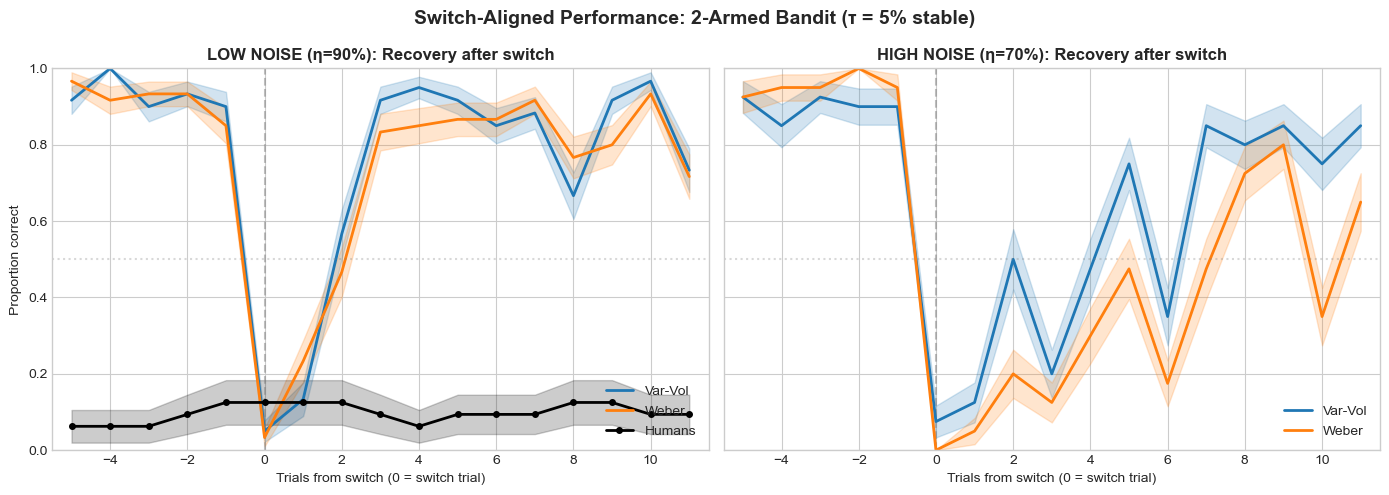


📊 Switches in task: 7
   Recovery window: 5 trials before → 12 trials after


In [ ]:
# ============================================================
# Switch-aligned accuracy: see learning BEFORE and recovery AFTER
# ============================================================
# Compare LOW NOISE vs HIGH NOISE conditions at switch points

before = 5   # trials before switch (shows learned performance)
after = 12   # trials after switch (shows recovery)

# Model accuracy aligned to switches - LOW NOISE
x, mean_varvol_sw_low, sem_varvol_sw_low = switch_aligned_accuracy(task_low_noise, varvol_low, before=before, after=after)
_, mean_weber_sw_low, sem_weber_sw_low = switch_aligned_accuracy(task_low_noise, weber_low, before=before, after=after)

# Model accuracy aligned to switches - HIGH NOISE
_, mean_varvol_sw_high, sem_varvol_sw_high = switch_aligned_accuracy(task_high_noise, varvol_high, before=before, after=after)
_, mean_weber_sw_high, sem_weber_sw_high = switch_aligned_accuracy(task_high_noise, weber_high, before=before, after=after)

# Human accuracy aligned to switches (if available)
try:
    human_df = pd.read_csv("participant_data/combined_data.csv")
    x_h, mean_human_sw, sem_human_sw = switch_aligned_accuracy_human(
        human_df, task_low_noise, 
        trial_col="trialNumber", 
        action_col="userChoice", 
        correct_col="trueState",
        participant_col="participant_id",
        before=before, after=after
    )
    has_human_data = True
except:
    has_human_data = False
    print("⚠️ Human data not available for switch-aligned comparison")

# ============================================================
# PLOT: 2-panel comparison (Low Noise vs High Noise recovery)
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Panel 1: Low Noise
ax1 = axes[0]
ax1.axvline(0, color="gray", linestyle="--", alpha=0.5)
ax1.plot(x, mean_varvol_sw_low, label="Var-Vol", color="#1f77b4", linewidth=2)
ax1.fill_between(x, mean_varvol_sw_low - sem_varvol_sw_low, mean_varvol_sw_low + sem_varvol_sw_low, alpha=0.2, color="#1f77b4")
ax1.plot(x, mean_weber_sw_low, label="Weber", color="#ff7f0e", linewidth=2)
ax1.fill_between(x, mean_weber_sw_low - sem_weber_sw_low, mean_weber_sw_low + sem_weber_sw_low, alpha=0.2, color="#ff7f0e")
if has_human_data:
    ax1.plot(x_h, mean_human_sw, "o-", label="Humans", color="black", linewidth=2, markersize=4)
    ax1.fill_between(x_h, mean_human_sw - sem_human_sw, mean_human_sw + sem_human_sw, alpha=0.2, color="black")
ax1.axhline(0.5, color="gray", linestyle=":", alpha=0.3)
ax1.set_xlabel("Trials from switch (0 = switch trial)")
ax1.set_ylabel("Proportion correct")
ax1.set_ylim(0, 1)
ax1.set_xlim(-before - 0.5, after - 0.5)
ax1.set_title(f"LOW NOISE (η={LOW_NOISE_BETA:.0%}): Recovery after switch", fontweight='bold')
ax1.legend(loc="lower right")

# Panel 2: High Noise
ax2 = axes[1]
ax2.axvline(0, color="gray", linestyle="--", alpha=0.5)
ax2.plot(x, mean_varvol_sw_high, label="Var-Vol", color="#1f77b4", linewidth=2)
ax2.fill_between(x, mean_varvol_sw_high - sem_varvol_sw_high, mean_varvol_sw_high + sem_varvol_sw_high, alpha=0.2, color="#1f77b4")
ax2.plot(x, mean_weber_sw_high, label="Weber", color="#ff7f0e", linewidth=2)
ax2.fill_between(x, mean_weber_sw_high - sem_weber_sw_high, mean_weber_sw_high + sem_weber_sw_high, alpha=0.2, color="#ff7f0e")
ax2.axhline(0.5, color="gray", linestyle=":", alpha=0.3)
ax2.set_xlabel("Trials from switch (0 = switch trial)")
ax2.set_ylim(0, 1)
ax2.set_xlim(-before - 0.5, after - 0.5)
ax2.set_title(f"HIGH NOISE (η={HIGH_NOISE_BETA:.0%}): Recovery after switch", fontweight='bold')
ax2.legend(loc="lower right")

plt.suptitle(f"Switch-Aligned Performance: 2-Armed Bandit (τ = {VOLATILITY:.0%} stable)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary
print(f"\n📊 Switches in task: {len(switches_low)}")
print(f"   Recovery window: {before} trials before → {after} trials after")


### 🧠 To Do: Take-Away's 
1. Do you see stronger similarities between the Var-Vol to human, or Weber to human data?
2. Make sure you have clear in your head task accuracy vs behaviour fit - what we hope to see is a model that performs as *badly* in the same ways as human data. 
3. Did we manage to replicate the author's findings from Figure 5? 

<img src="images_and_figures/Fig5contingency_reversals.png" width="400" style="display:inline">



# The End!

Alright Folks! That's it for now - thanks for playing Volatile Bandits with us.

*If you have any questions of how you could incorporate the Weber-imprecision model (or noise generally) into your work for the mini-project at the end of the semester, please don't hesitate to each out to us on sascholle@uos.de.*

## Stay noisy, *Sabine, Sigur, Sofia and Elena*


